<a href="https://colab.research.google.com/github/menotti/ld/blob/main/Livro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Instalações (_executar antes de qualquer outro exemplo_)
!pip install git+https://github.com/lesc-ufv/cad4u/ &> /dev/null
!git clone https://github.com/lesc-ufv/cad4u/ &> /dev/null
%load_ext plugin
!sudo apt update &> /dev/null
!sudo apt install imagemagick pdf2svg texlive-latex-extra &> /dev/null
!pip install git+https://github.com/mkrphys/ipython-tikzmagic.git &> /dev/null
%load_ext tikzmagic
#!pip install schemdraw[matplotlib]==0.14 &> /dev/null
!pip install schemdraw[svgmath]  &> /dev/null
!pip install truth-table-generator &> /dev/null

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets.widgets.widget_string import Label
from IPython.display import display

import random
import ttg

import schemdraw
from schemdraw import elements as elm
from schemdraw import logic
from schemdraw import flow
from schemdraw.parsing import logicparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def questao_aleatorio_lista_dropdown(l,cabecalho=""):
  x = random.randrange(len(l))
  print(cabecalho+l[x][0]+"?")

  r = ["Selecione"]
  for i in l:
    r.append(i[1])

  def op(resposta):
    if (resposta== l[x][1]):
      return "Correto !"
    else:
      return "Tente novamente !"

  interact(op,resposta=r)


<font color='red'>Esta é uma versão preliminar do livro. Apesar de completa, ela ainda não estão revisada. Esperamos que possa aproveitar o conteúdo e nos fornecer <i>feedback</i> na forma de comentários nas respectivas células.</font>

# Introdução à Lógica Digital com Verilog

## Professores: [Ricardo dos Santos Ferreira - UFV](mailto:ricardo@ufv.br) e [Ricardo Menotti - UFSCar](mailto:menotti@ufscar.br)



Neste livro vamos tratar especificamente de Circuitos Digitais, sem nos preocupar com a conversão de/para analógico. Vamos usar a linguagem de descrição de hardware (HDL) Verilog para implementar e testar os circuitos usando simulações. Não é necessário ter qualquer tipo de hardware específico para usar livro, apenas um computador conectado à Internet. Estamos planejando um versão baseada em um kit didático de FPGAs, no qual todas as práticas poderão ser feitas em laboratório. Se você tem interesse em comercializar um kit de baixo custo com o livro, entre em contato pelos e-mails acima.

## Informação analógica e digital

Os sistemas digitais são a base dos dispositivos eletrônicos modernos que usamos em nosso cotidiano, tais como computadores, *smartphones* e eletrodomésticos em geral. Com o advento da Internet das Coisas, eles passaram também a serem embarcados em veículos e em diversos pontos das casas e cidades em geral, formando o conceito de Cidades Inteligentes.

No entanto, a maioria dos fenômenos que notamos ao nosso redor tem características analógicas e precisam ser digitalizadas para serem processadas. Este processo também pode ser chamado de discretização e, apesar da desvantagem de se perder a precisão ou continuidade da informação, apresenta a vantagem de a tornar mais tolerante aos ruídos e mais fácil de manipular e armazenar. A figura a seguir mostra o exemplo de uma informação analógica (linha pontilhada) e sua discretização para armazenamento e/ou processamento digital.

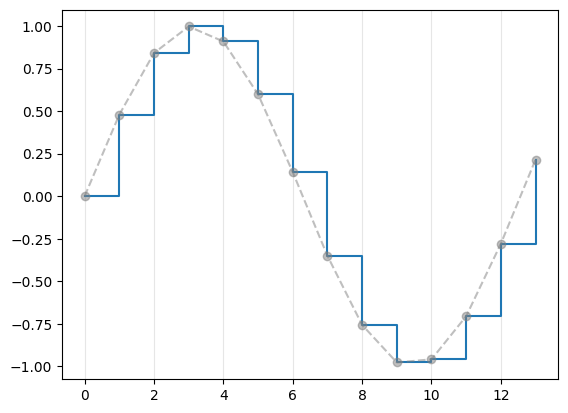

In [2]:
#@title
x = np.arange(14)
y = np.sin(x / 2)

plt.step(x, y, where='post', label='post')
plt.plot(x, y, 'o--', color='grey', alpha=0.5)

plt.grid(axis='x', color='0.9')
plt.show()

## Variáveis lógicas

Para os sistemas digitais, a menor unidade de informação é o **bit** (acrônimo para ***binary digit***) que pode assumir valor **0** ou **1**. Usaremos diagramas de Venn para representar variáveis e funções lógicas, também chamadas de booleanas (a seguir detalharemos o termo). Dizemos que uma variável tem o nível lógico **0** ou **baixo** quando tem o valor **falso** e que tem o nível lógico **1** ou **alto** quando tem o valor **verdadeiro**. No par de diagramas de Venn a seguir representamos $x=1$ e $y=0$, respectivamente. Usamos uma barra superior para demonstar a negação de uma variável, ou seja, seu inverso. Portanto, neste caso, $\bar{x}=0$ e $\bar{y}=1$.

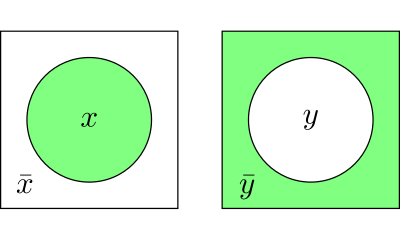

In [3]:
#@title
%%tikz -S test_output.tikz -f svg

\filldraw[fill=white] (-1,-1) rectangle (1,1);
\node[fill=green!50,draw,circle,label=below left:$\bar{x}$,minimum size=40pt] at (0,0) {$x$};

\filldraw[fill=green!50] (1.5,-1) rectangle (3.5,1);
\node[fill=white,draw,circle,label=below left:$\bar{y}$,minimum size=40pt] at (2.5,0) {$y$};

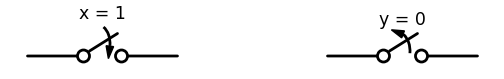

In [4]:
#@title
with schemdraw.Drawing() as d:
    d += elm.Switch(action='close').label('x = 1')
    d += elm.Gap(label=' ')
    d += elm.Switch(action='open').label('y = 0')

## Implementação em Verilog

**Verilog** é uma **linguagem de descrição de hardware (HDL)** e será adotada neste livro para implementação e testes dos circuitos digitais. Apesar de sua sintaxe lembrar a da linguagem C em alguns aspectos, Verilog não é uma linguagem de programação. Trata-se de outro paradigma, pois enquanto um programa em uma linguagem imperativa como C remete a uma sequência de instruções (carater temporal), uma linguagem de descrição de hardware descreve componentes e ligações entre eles (carater espacial). Um projeto digital em Verilog possui um ou mais módulos. A seguir está a descrição de um módulo com uma entrada que é apenas propagada para sua saída. O comando de célula `%%print_verilog` é usado para desenhar o circuito e pode ser útil para conferir a sintaxe da linguagem, que será ensinada a medida que avançamos.

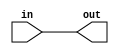

In [126]:
%%print_verilog

module foo(input in, output out);
  // isso é um comentário
  assign out = in;
endmodule

## Funções lógicas

As variáveis lógicas podem ser usadas como entradas nas funções lógicas, gerando novas variáveis. As funções básicas são **AND**, **OR** e **NOT**, como veremos a seguir.

### Função **AND** (E)

A função lógica **AND** resulta em uma saída verdadeira quando **todas suas entradas são verdadeiras**. Ela pode ser representada pelo símbolo $\&$, por um ponto, (e.g. $a.b$) ou sua representação pode ser simplesmente omitida. A seguir é listada a tabela verdade com todas as combinações possíveis entre duas variáveis lógicas $a$ e $b$. Note que a tabela tem $2^n$ linhas, onde $n$ é o número de entradas, e que ela está ordenada pelos valores das variáveis de entrada $a$ e $b$.

$a$|$b$|$a\&b$
---|---|---
 0 | 0 | 0
 0 | 1 | 0
 1 | 0 | 0
 1 | 1 | 1

Nos diagramas de Venn, a função **AND** é calculada com a operação de ***intersecção*** entre as variáveis. No diagrama a seguir é apresentada a operação **AND** entre as variáveis $a$ e $b$. Note que, assim como a tabela verdade, o diagrama tem tem $2^n$ regiões, onde $n$ é o número de variáveis.

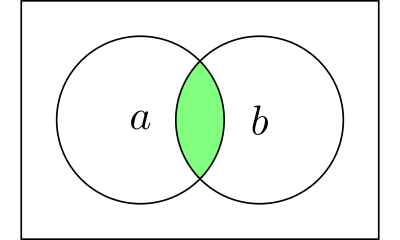

In [6]:
#@title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=white] (-1,-1) rectangle (2,1);
\begin{scope}
  \clip (0,0) circle (20pt);
  \filldraw[green!50] (1,0) circle (20pt);
\end{scope}
\node[draw,circle,minimum size=40pt] at (0,0) {$a$};
\node[draw,circle,minimum size=40pt] at (1,0) {$b$};

A função lógica **AND** pode ser melhor compreendida pela ligação de duas ou mais chaves em série, ou seja, sua saída será verdadeira quando ***todas as chaves estiverem ligadas***. A implementação desta função em um circuito é feita por meio de sua respectiva **porta lógica**, cuja representação gráfica é a seguinte:

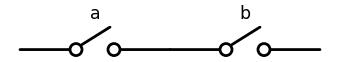

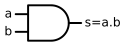

In [7]:
#@title
with schemdraw.Drawing() as d:
    d += elm.Switch().label('a')
    d += elm.Switch().label('b')

from schemdraw.parsing import logicparse
logicparse('a and b', outlabel='s=a.b')

Por fim, cabe ressaltar que esta função é N-ária, onde o número de entradas é maior ou igual a 2. A seguir estão as diferentes representações da função **AND** na forma ternária.

$a$|$b$|$c$|$\mbox{$a$.$b$.$c$}$
---|---|---|---
 0 | 0 | 0 | 0
 0 | 0 | 1 | 0
 0 | 1 | 0 | 0
 0 | 1 | 1 | 0
 1 | 0 | 0 | 0
 1 | 0 | 1 | 0
 1 | 1 | 0 | 0
 1 | 1 | 1 | 1

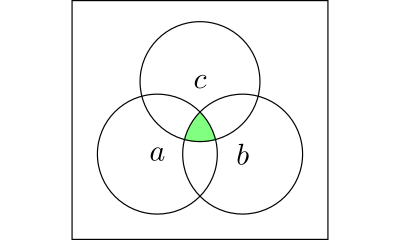

In [8]:
#@title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=white] (-1,-1) rectangle (2,1.8);
\begin{scope}
  \clip (0,0) circle (20pt);
  \clip (1,0) circle (20pt);
  \filldraw[green!50] (0.5,0.85) circle (20pt);
\end{scope}
\node[draw,circle,minimum size=40pt] at (0,0) {$a$};
\node[draw,circle,minimum size=40pt] at (1,0) {$b$};
\node[draw,circle,minimum size=40pt] at (0.5,0.85) {$c$};

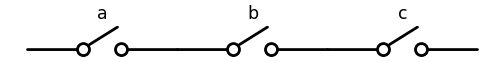

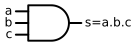

In [9]:
#@title
from schemdraw import elements as elm

with schemdraw.Drawing() as d:
    d += elm.Switch().label('a')
    d += elm.Switch().label('b')
    d += elm.Switch().label('c')

from schemdraw.parsing import logicparse
logicparse('a and b and c', outlabel='s=a.b.c')

Para implementar uma função lógica AND em Verilog podemos usar seu operador (`&`) entre os operandos em uma atribuição contínua (`assign`) ou instanciar uma primitiva básica `and` que pode ter duas ou mais entradas. Note que, por conter um número variável de entradas, a primeira porta das primitivas básicas é sempre a saída. Vejamos sua implementação em Verilog (o parâmetro `-n and3.v` usado na célula, indica que vamos salvar o arquivo com este nome para usar posteriormente):

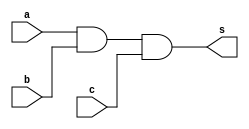

In [10]:
%%print_verilog -n and3.v

module and3(
  input a, b, c,
  output s);
  // atribuição contínua usando o operador &
  assign s = a & b & c;
  // alternativa em Verilog Estrutural (instanciando a primitiva básica)
  // and (s, a, b, c);
endmodule

Vejamos sua simulação a seguir. Para isso, vamos escrever um ***test bench*** que fornece todas as entradas possíveis, já que neste caso são apenas $2^3$. Um ***test bench*** é um módulo que instancia outro módulo a ser testado, normalmente com o nome de `dut` (*design under test*) ou `uut` (*unit under test*) e fornece estímulos a ele. O teste pode também verificar automaticamente se as saídas obtidas são as esperadas, mas por enquanto vamos fazer isso visualmente do diagrama de formas de onda (*waveform*) que geraremos com o comando de célula `%%wavedrom`. Podemos notar as seguintes particularidades:

  1. O arquivo que contém o módulo a ser testado (`dut`) é incluído (linha 2);
  1. O módulo `tb_and3` não tem portas, pois ele mesmo gera os estímulos (linha 4);
  1. As entradas devem ser declaradas como `reg`, pois vamos atribuir valores a elas ao longo do teste (linha 5);
  1. As saídas devem ser declaradas como `wire`, pois apenas conduzem o valores obtido do `dut` (linha 6);
  1. O `dut` é instanciado, usamos a mesma ordem das portas da declaração original do módulo (linha 7);
  1. Um bloco `initial` é disparado uma única vez no início da simulação, `begin/end` delimitam seu alcance (linhas 9-22);
  1. A função `$dumpvars` é usada para gerar um arquivo `.vcd` com a saída da simulação (linha 11);
  1. O comando `#5` indica um atraso antes de atribuir os valores às entradas, por isso no início da simulação elas aparecem hachuradas (linhas 12-19);
  1. Todos os valores possíveis para a função são informados na mesma ordem da tabela verdade (linhas 12-19);
  1. A função `$finish` termina a simulação;

VCD info: dumpfile dump.vcd opened for output.



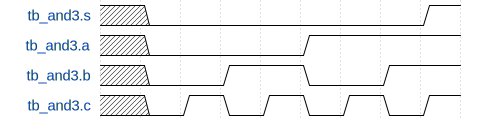

In [127]:
%%wavedrom
`include "and3.v"

module tb_and3;
  reg a, b, c;
  wire s;
  and3 dut(a, b, c, s);

  initial
  begin
    $dumpvars(0);
    #5 a=0; b=0; c=0;
    #5 a=0; b=0; c=1;
    #5 a=0; b=1; c=0;
    #5 a=0; b=1; c=1;
    #5 a=1; b=0; c=0;
    #5 a=1; b=0; c=1;
    #5 a=1; b=1; c=0;
    #5 a=1; b=1; c=1;
    $finish;
  end
endmodule

<h3>Função <b>OR</b> (OU)</h3>

A função lógica **OR** resulta em uma saída verdadeira quando **ao menos uma de suas entradas é verdadeira**. Ela pode ser representada pelo símbolo  $+$ ou $|$. A seguir é listada a tabela verdade com todas as combinações possíveis entre duas variáveis lógicas $a$ e $b$. Note que a tabela tem $2^n$ linhas, onde $n$ é o número de entradas, e que ela está ordenada pelos valores das variáveis de entrada $a$ e $b$.

$a$|$b$|$\mbox{$a$+$b$}$
---|---|---
 0 | 0 | 0
 0 | 1 | 1
 1 | 0 | 1
 1 | 1 | 1

Nos diagramas de Venn, a função **OR** é calculada com a operação de ***união*** entre as variáveis. No diagrama a seguir é apresentada a operação **OR** entre as variáveis $a$ e $b$. Note que, assim como a tabela verdade, o diagrama tem tem $2^n$ regiões, onde $n$ é o número de variáveis.


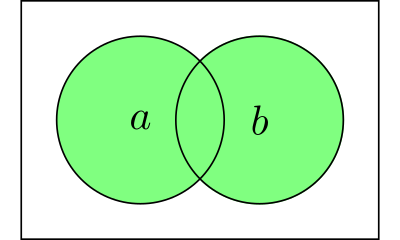

In [12]:
#@title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=white] (-1,-1) rectangle (2,1);
\filldraw[green!50] (1,0) circle (20pt); % fundo B verde
\node[fill=green!50,draw,circle,minimum size=40pt] at (0,0) {$a$}; % A sobrescrevendo B
\node[draw,circle,minimum size=40pt] at (1,0) {$b$}; % B sem preenchimento para repor a linha

A função lógica **OR** pode ser melhor compreendida pela ligação de duas ou mais chaves em paralelo, ou seja, sua saída será verdadeira quando ***qualquer uma das chaves estiver ligada***. A representação gráfica da respectiva **porta lógica** é a seguinte:

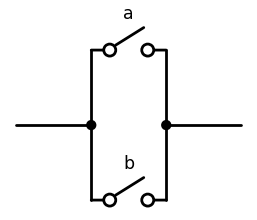

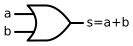

In [13]:
#@title
with schemdraw.Drawing() as d:
    d.config(unit=1.5)
    d += elm.Line().dot()
    d.push()
    d += elm.Line().up()
    d += elm.Switch().right().label('a')
    d += elm.Line().down()
    d.pop()
    d += elm.Line().down()
    d += elm.Switch().right().label('b')
    d += elm.Line().up().dot()
    d += elm.Line().right()

from schemdraw.parsing import logicparse
logicparse('a or b', outlabel='s=a+b')

Por fim, cabe ressaltar que esta função é também N-ária, onde o número de entradas é maior ou igual a 2. A seguir estão as diferentes representações da função **OR** na forma ternária.

$a$|$b$|$c$|$\mbox{$a$+$b$+$c$}$
---|---|---|:-:
 0 | 0 | 0 | 0
 0 | 0 | 1 | 1
 0 | 1 | 0 | 1
 0 | 1 | 1 | 1
 1 | 0 | 0 | 1
 1 | 0 | 1 | 1
 1 | 1 | 0 | 1
 1 | 1 | 1 | 1

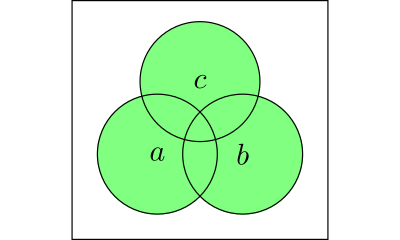

In [14]:
#@title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=white] (-1,-1) rectangle (2,1.8);
\filldraw[green!50] (0,0) circle (20pt); % fundo verde A
\filldraw[green!50] (1,0) circle (20pt); % fundo verde B
\node[fill=green!50,draw,circle,minimum size=40pt] at (0.5,0.85) {$c$}; % C sobrescrevendo ambos
\node[draw,circle,minimum size=40pt] at (1,0) {$b$}; % B sem preechimento para repor a linha
\node[draw,circle,minimum size=40pt] at (0,0) {$a$}; % A sem preechimento para repor a linha

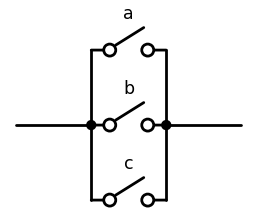

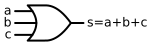

In [15]:
#@title
with schemdraw.Drawing() as d:
    d.config(unit=1.5)
    d += elm.Line().dot()
    d.push()
    d.push()
    d += elm.Line().up()
    d += elm.Switch().right().label('a')
    d += elm.Line().down()
    d.pop()
    d += elm.Switch().label('b')
    d.pop()
    d += elm.Line().down()
    d += elm.Switch().right().label('c')
    d += elm.Line().up().dot()
    d += elm.Line().right()

from schemdraw.parsing import logicparse
logicparse('a or b or c', outlabel='s=a+b+c')

O operador lógico OR em Verilog é denotado pelo caracter `|`. Vamos aproveitar a ocasião para aprender dois novos conceitos em Verilog. O primeiro é o de barramento (*bus*). No exemplo a seguir construimos uma porta OR de três entradas, no entanto, declaramos uma única porta de entrada com 3 fios. Os colchetes com o intervalo são usados na declaração antes do nome da porta para especificar a largura `[2:0]`. Eles também são usados para acessar uma parte do barramento (e. g. `[1:0]`) ou cada fio individualmente. O segundo conceito apresentado é que os operadores lógicos podem ser usados na forma de redução em um barramento. Na linha 9 escrevemos `|a`, o que quer dizer OR entre todos os bits de `a`.

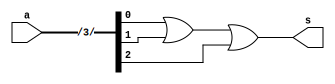

In [16]:
%%print_verilog -n or3.v

module or3(
  input [2:0] a,
  output s);
  // atribuição usando o operador |
  assign s = a[0] | a[1] | a[2];
  // atribuição usando o operador de redução |
  // assign s = |a;
  // estrutural
  // or G(s,a[0],a[1],a[2]);
endmodule

Vamos testar este módulo de forma um pouco diferente, usando o comando de célula `%%verilog`, para aprender duas novas funções de console da linguagem. O ***test bench*** usado é praticamente o mesmo da função AND com as seguintes diferenças:
  1. Usamos as mesmas variáveis de entrada/saída (linhas 5-6), mas ao instanciar o `dut` concatenamos as variáveis `{a, b, c}` para obter um barramento com 3 fios, conforme a entrada esperada;
  1. Não precisamos da função `$dumpvars` já que não vamos plotar o diagrama de formas de onda;
  1. Usamos a função `$display` para imprimir um cabeçalho na console (linha 11);
  1. Usamos a função `$monitor` para imprimir as variáveis sempre que alguma delas mudar de valor (linha 12);
  1. Removemos o atraso da primeira linha para que as entradas já comecem com valor definidos ao invés de `x` (linha 13).

In [17]:
%%verilog
`include "or3.v"

module tb_or3;
  reg a, b, c;
  wire s;
  or3 dut({a, b, c}, s);

  initial
  begin
    $display("a|b|c||s\n-+-+-++-");
    $monitor("%b|%b|%b||%b", a, b, c, s);
       a=0; b=0; c=0;
    #5 a=0; b=0; c=1;
    #5 a=0; b=1; c=0;
    #5 a=0; b=1; c=1;
    #5 a=1; b=0; c=0;
    #5 a=1; b=0; c=1;
    #5 a=1; b=1; c=0;
    #5 a=1; b=1; c=1;
    $finish;
  end
endmodule

a|b|c||s
-+-+-++-
0|0|0||0
0|0|1||1
0|1|0||1
0|1|1||1
1|0|0||1
1|0|1||1
1|1|0||1
1|1|1||1



<h3>Função <b>NOT</b> (NÃO)</h3>

A função lógica **NOT** possui uma única entrada ou operando (função unária) e resulta no inverso ou complemento da sua entrada. Ela pode ser representada pelo símbolo  $\sim$ ou $!$ antes da variável, pelo símbolo $'$ após ela, ou ainda por um barra sobre o que se deseja negar/inverter. Portanto, sua tabela verdade tem apenas duas possibilidades:

$a$|$\bar{a}$
---|---
 0 | 1
 1 | 0

Supondo que deseja-se obter o inverso da função $a+b$, podemos escrever $\sim(a+b)$ ou $!(a+b)$ ou $(a+b)'$ ou ainda $\overline{a+b}$, neste caso, sem a necessidade de parênteses.

Como veremos a seguir, se aplicamos esta função em um diagrama de Venn invertemos suas regiões, assim como acontece em uma tabela verdade (invertemos a coluna inteira). Também veremos, mais adiante, que inverter a saída de uma função nem sempre equivale a inverter suas entradas.

A representação gráfica desta função como **porta lógica** é apresentada a seguir.

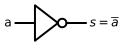

In [18]:
#@title
logicparse('not a', outlabel='$s=\overline{a}$')

Quando aplicada a entrada ou saída de outra porta lógica no circuito pode ser abreviada, incluindo somente a $\circ$ (bolinha).

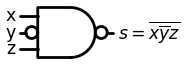

In [19]:
#@title
with schemdraw.Drawing() as d:
    d += logic.Nand(inputs=3, inputnots=[2]).label('x', loc='in1').label('y', loc='in2').label('z', loc='in3').label('$s=\overline{x\overline{y}z}$', loc='out')

Em Verilog podemos usar tanto `!` quanto `~` para o operador NOT. Podemos declarar sinais internos usando a palavra `wire` e fazer ligações com eles.

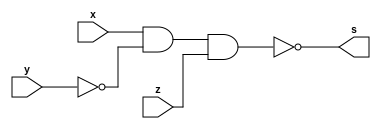

In [20]:
%%print_verilog -n not_xnyz.v

module not_xnyz(
  input x, y, z,
  output s);
  // declaramos um fio e o atribuimos
  wire not_y;
  assign not_y = !y;
  // atribuição usando o operador ~
  assign s = ~(x & not_y & z);
endmodule

Vamos usar praticamente o mesmo ***test bench*** com esta função, mas note que ela tem entradas com nomes diferentes. Podemos instanciar o módulo normalmente (`dut`), a ligação é feita pela posição, não importam os nomes (linha 7). Ou podemos usar uma notação alternativa, na qual escolhemos explicitamente quais portas serão ligadas em quais sinais (linha 8). Nesta segunda notação usamos um `.` seguido do nome original da porta (interno) e escevemos a seguir entre parênteses o nome do sinal (externo) a ser ligado nesta porta. Nela as portas podem ser ligadas em qualquer ordem, inclusive podemos omitir portas que não desejarmos ligar. Note que usamos um nome de instância diferente (`uut`) já que este não pode se repetir. Note também que os dois módulos compartilham as mesmas entradas, mas precisamos de saídas distintas para eles, senão causaríamos um curto-circuito entre as saídas.

In [21]:
%%verilog
`include "not_xnyz.v"

module tb_not_xnyz;
  reg a, b, c;
  wire s, t;
  not_xnyz dut(a, b, c, s);
  not_xnyz uut(.s(t), .x(a), .y(b), .z(c));

  initial
  begin
    $display("x|y|z||s|t\n-+-+-++-+-");
    $monitor("%b|%b|%b||%b|%b", a, b, c, s, t);
       a=0; b=0; c=0;
    #5 a=0; b=0; c=1;
    #5 a=0; b=1; c=0;
    #5 a=0; b=1; c=1;
    #5 a=1; b=0; c=0;
    #5 a=1; b=0; c=1;
    #5 a=1; b=1; c=0;
    #5 a=1; b=1; c=1;
    $finish;
  end
endmodule

x|y|z||s|t
-+-+-++-+-
0|0|0||1|1
0|0|1||1|1
0|1|0||1|1
0|1|1||1|1
1|0|0||1|1
1|0|1||0|0
1|1|0||1|1
1|1|1||1|1



<h3>Demais funções lógicas (XOR, NAND, NOR e XNOR)</h3>

<h4>Portas lógicas universais</h4>

Além das portas lógicas relativas às funções **NOT**, **AND** e **OR**, consideradas primitivas básicas, há também as variações **NAND** e **NOR**, negações das duas últimas. Elas são chamadas portas universais, pois a partir delas podemos construir as outras três, como veremos adiante. A seguir é apresentada uma tabela verdade com as suas respectivas saídas para duas entradas (compare com as tabelas originais das funções **AND** e **OR**):

$a$|$b$|$\overline{\mbox{$a$.$b$}}$|$\overline{\mbox{$a$+$b$}}$
---|---|---|---
 0 | 0 | 1 | 1
 0 | 1 | 1 | 0
 1 | 0 | 1 | 0
 1 | 1 | 0 | 0

Suas portas lógicas são representadas das seguintes formas:

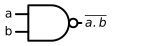

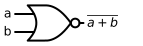

In [22]:
#@title
d = logicparse('a nand b', outlabel='$\overline{a.b}$')
d += elm.Gap(label=' ')

e = logicparse('a nor b', outlabel='$\overline{a+b}$')
e += elm.Gap(label=' ')

display(d, e)

As portas universais são úteis aos fabricantes de semicondutores, pois assim só precisam fabricar um único tipo de porta lógica e podem usá-las para obter as demais. A seguir está a construção das primitivas **NOT**, **AND** e **OR** a partir das portas universais **NAND** e **NOR**:

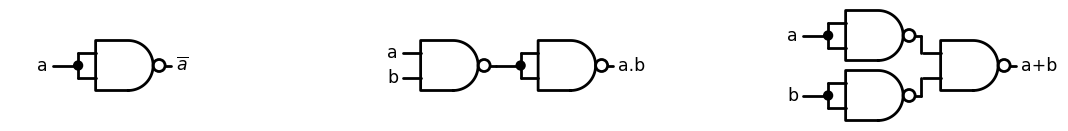

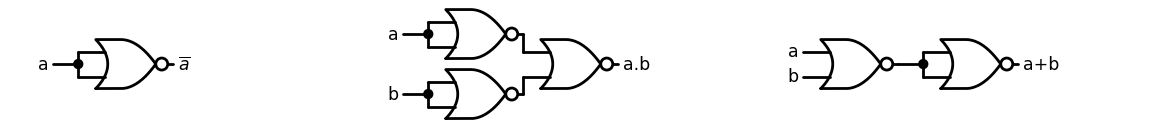

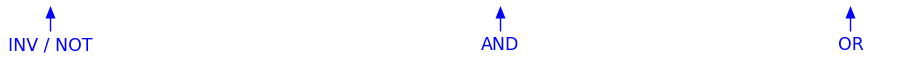

In [23]:
#@title
with schemdraw.Drawing() as d:
    # not
    d.config(unit=0.5)
    d += elm.Line().dot().label('a', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += logic.Nand().label('$\overline{a}$', loc='right')
    # and
    d.here = (7,0)
    d += logic.Nand().label('a', loc='in1').label('b', loc='in2')
    d += elm.Line().dot()
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += logic.Nand().label('a.b', loc='right')
    d += elm.Gap(label=' ').length(5)
    # or
    d.here = (15,-0.6)
    d += elm.Line().dot().label('b', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += (p1 := logic.Nand())
    d.push()
    d += elm.Line().up().length(0.35)
    d.pop()
    d.here = (15,0.6)
    d += elm.Line().dot().label('a', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += (p2 := logic.Nand())
    d.push()
    d += elm.Line().down().length(0.35)
    d.pop()
    d.here = (17.4,0)
    d += logic.Nand().label('a+b', loc='right')

with schemdraw.Drawing() as d:
    # not
    d.config(unit=0.5)
    d += elm.Line().dot().label('a', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += logic.Nor().label('$\overline{a}$', loc='right')
    # or
    d.here = (15,0)
    d += logic.Nor().label('a', loc='in1').label('b', loc='in2')
    d += elm.Line().dot()
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += logic.Nor().label('a+b', loc='right')
    d += elm.Gap(label=' ').length(5)
    # and
    d.here = (7,-0.6)
    d += elm.Line().dot().label('b', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += (p1 := logic.Nor())
    d.push()
    d += elm.Line().up().length(0.35)
    d.pop()
    d.here = (7,0.6)
    d += elm.Line().dot().label('a', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += (p2 := logic.Nor())
    d.push()
    d += elm.Line().down().length(0.35)
    d.pop()
    d.here = (9.4,0)
    d += logic.Nor().label('a.b', loc='right')

with schemdraw.Drawing() as d:
    # not
    d += elm.Annotate().label('INV / NOT').delta(dx=0, dy=-0.5).linewidth(1).color('blue')
    # and
    d.here = (9,0)
    d += elm.Annotate().label('AND').delta(dx=0, dy=-0.5).linewidth(1).color('blue')
    # or
    d.here = (16,0)
    d += elm.Annotate().label('OR').delta(dx=0, dy=-0.5).linewidth(1).color('blue')


Embora nossa ferramenta não use os símbolos próprios dessas portas para contruir o desenho do circuito, ela reconhece as primitivas básicas `nand` e `nor` da linguagem Verilog. No exemplo a seguir usamos também o operador de concatenação `{}` para unir dois fios e gerar um barramento.

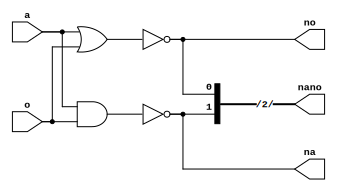

In [24]:
%%print_verilog -n nandnor.v

module nandnor(
  input a, o,
  output na, no,
  output [1:0] nano);
  nand (na, a, o);
  nor (no, a, o);
  assign nano = {na,no};
endmodule

Escreva um ***test bench*** para esta função na célula abaixo, combinando os conceitos aprendidos para plotar a forma de onda e também para imprimir na console, compare sua saída com a do gabarito logo abaixo. Note que ele usa vetores para a saída `nano`, então os valores são plotados em hexadecimal.

In [ ]:
%%wavedrom
`include "nandnor.v"

// escreva seu test bench aqui

VCD info: dumpfile dump.vcd opened for output.
a|o||na|no|nano
-+-++--+--+----
x|x|| x| x|  x
0|0|| 1| 1|  3
0|1|| 1| 0|  2
1|0|| 1| 0|  2
1|1|| 0| 0|  0



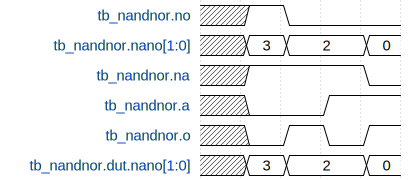

In [26]:
#@title
%%wavedrom
`include "nandnor.v"

module tb_nandnor;
  reg a, o;
  wire na, no;
  wire [1:0] nano;
  nandnor dut(a, o, na, no, nano);

  initial
  begin
    $dumpvars(0);
    $display("a|o||na|no|nano\n-+-++--+--+----");
    $monitor("%b|%b||%2b|%2b|%3d", a, o, na, no, nano);
    #5 a=0; o=0;
    #5 a=0; o=1;
    #5 a=1; o=0;
    #5 a=1; o=1;
    $finish;
  end
endmodule

<h4>Portas lógicas aritméticas</h4>

A função lógica **XOR** (OU exclusivo), representada pelos símbolos $\oplus$ ou $\underline{\lor}$ e sua complementar **XNOR** são  chamadas portas artiméticas. Por definição, a saída da função lógica **XOR** é verdadeira ***se e somente se apenas uma das entradas forem verdadeiras***\*. A partir desta definição, podemos obter sua tabela verdade:

$a$|$b$|$a$ $\oplus$ $b$
---|---|:-:
 0 | 0 | 0
 0 | 1 | 1
 1 | 0 | 1
 1 | 1 | 0

 A representação gráfica das portas lógicas XOR e XNOR são as seguintes:

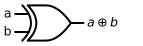

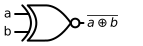

In [27]:
#@title
d = logicparse('a xor b', outlabel='$a \oplus b$')
d += elm.Gap(label=' ')

e = logicparse('a xnor b', outlabel='$\overline{a \oplus b}$')
e += elm.Gap(label=' ')

display(d, e)

A porta **XOR**, quando construída com mais de duas entradas, pode ser interpretada de duas formas distintas:

1. Conforme a definição anterior\*;
2. Como uma geradora de paridade ímpar, ou seja, sua saída será verdadeira quando o número de entradas verdadeiras for ímpar.

O mesmo acontece com a porta **XNOR**, porém com o inverso das saídas nos dois casos.

A primeira interpretação está mais ligada ao rigor matemático e não é seguida pelas linguagens de descrição de hardware e seus simuladores, que costumam implementar portas de várias entradas pela cascata de portas de duas entradas, resultando nos geradores de paridade mencionados.

Estranhamente nossa ferramenta de desenho tem símbolos próprios para essas duas portas lógicas.

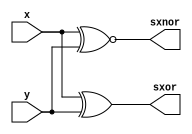

In [28]:
%%print_verilog

module exnor(
  input x, y,
  output sxor, sxnor);
  assign sxor = x ^ y;
  assign sxnor = x ~^ y;
endmodule

<h2>Gere uma tabela verdade com n entradas para as funções lógicas e observe cada uma delas para ver se compreendeu:</h2>

In [29]:
#@title
def n_bits_table(n,op):
  if ( int(n) > 7 ):
    print("A tabela cresce exponencialmente, use valores pequenos de n")
    return
  vars = []
  eq = ""
  pre = ""
  suf = ""
  if op== 'nand' or op== 'nor':
    pre = "not("
    op = op[1:]
    suf = ")"
  eq = pre
  for i in range(int(n)):
    vars.append("a"+str(i))
    eq += " a"+str(i)+" "+op
  vars.reverse()
  eq = eq[:-3]
  eq += suf
  leq = []
  leq.append(eq)
  table = ttg.Truths(vars,leq)
# table.as_pandas().style.set_properties(**{'text-align':'center'}).hide_index()
  pd = table.as_pandas()
  pd = pd.reindex(index=pd.index[::-1])
  l = []
  for i in range(pd.shape[0]):
    l.append(i)
  pd['linha'] = l
  pd = pd.set_index('linha')
  print (pd.to_string(justify='center'))

print("Selecione a operação lógica e digite um valor para n")
dummy = interact(n_bits_table,n="3",op=['and','or','xor','nand','nor'])


Selecione a operação lógica e digite um valor para n


interactive(children=(Text(value='3', description='n'), Dropdown(description='op', options=('and', 'or', 'xor'…

## Formas de Representação

Como já vimos, uma função lógica ou Booleana pode ter diversas formas de representação: equação, tabela verdade, portas lógicas e circuitos com chaves em série e paralelo. Existem outras formas que veremos a seguir.

Cada representação tem vantagens e desvantagens para especificação e manipulação. Por exemplo, a tabela verdade é a espeficação completa da função. A tabela pode ser usada para verificar a equivalência de duas funções.  Porém o número de linhas cresce exponencialmente com o número de entradas. Uma tabela com $n$ variáveis terá $2^n$ linhas.

Uma equação pode ser uma forma mais compacta que a tabela. Além disso, permite usar álgebra booleana para manipulá-la e simplificá-la.

Para exemplificar os conceitos aprendidos até agora, vamos considerar a função lógica $f$ dada (qual foi o critério para obter esta função não vem ao caso agora) pela tabela a seguir:

 a | b | c ||$f$
---|---|---||---
 0 | 0 | 0 || 0
 0 | 0 | 1 || 0
 0 | 1 | 0 || 0
 0 | 1 | 1 || 0
 1 | 0 | 0 || 1
 1 | 0 | 1 || 1
 1 | 1 | 0 || 1
 1 | 1 | 1 || 0

A partir desta tabela, podemos obter o diagrama de Venn correspondente:







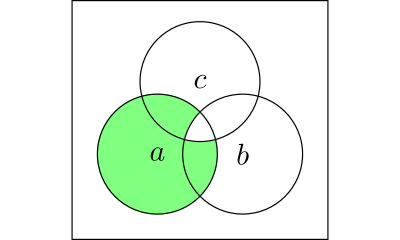

In [30]:
#@title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=white] (-1,-1) rectangle (2,1.8);
\filldraw[green!50] (0,0) circle (20pt);
\begin{scope}
  \clip (0,0) circle (20pt);
  \clip (1,0) circle (20pt);
  \filldraw[white] (0.5,0.85) circle (20pt);
\end{scope}
\node[draw,circle,minimum size=40pt] at (0,0) {$a$};
\node[draw,circle,minimum size=40pt] at (1,0) {$b$};
\node[draw,circle,minimum size=40pt] at (0.5,0.85) {$c$};

Note que há uma correspondência exata entre as duas representações, pois cada linha da tabela verdade tem uma área correspondente no diagrama de Venn e vice-versa.

Se quisermos uma expressão possível para esta função lógica, podemos olhar para suas saídas verdadeiras e fazer uma união entre elas (veremos como isso se chama mais adiante). Obtemos a expressão $a\bar{b}\bar{c}+a\bar{b}c+ab\bar{c}$, que corresponde ao circuito:

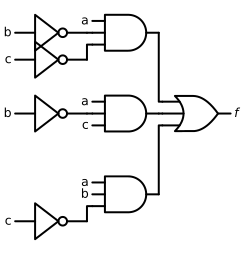

In [31]:
#@title
logicparse('a and not b and not c or a and not b and c or a and b and not c', outlabel='$f$')

No entanto, esta não é a única forma de implementar esta função lógica e, se observarmos a tabela verdade atentamente, podemos concluir que as expressões $a(\bar{b}+\bar{c})$ e $a\bar{b}+a\bar{c}$ apresentam exatamente a mesma saídas e seus circuitos correspondentes são muito mais simples:

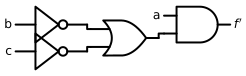

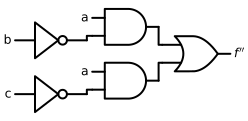

In [32]:
#@title
x=logicparse('a and (not b or not c)', outlabel="$f'$")
y=logicparse('a and not b or a and not c', outlabel="$f''$")
display(x,y)

Podemos usar Diagramas de Venn ou Tabelas Verdade para conferir se a funções são realmente equivalentes. No caso dos diagramas, pegamos cada uma das variáveis separadamente, em sua forma original ou negada, e as combinamos por meio da união (OR) ou intersecção (AND) das áreas até obter a função resultante. Embora os diagramas intermediários possam ser diferentes, o resultante deve ser exatamente igual ao que apresentamos no início desta seção. Usando a Tabela Verdade o processo é similar, vamos adicionando colunas para os termos da expressão até obter a expressão final:

a|b|c||$f$||$\bar{b}$|$\bar{c}$|$\mbox{$\bar{b}$+$\bar{c}$}$|$\mbox{$a(\bar{b}$+$\bar{c}$)}$|$a\bar{b}$|$a\bar{c}$|$a\bar{b}+a\bar{c}$|
-|-|-||------------||---|---|:-:|:-:|:-:|:-:|:-:|
0|0|0||$\textbf{0}$||1|1|1|$\textbf{0}$|0|0|$\textbf{0}$|
0|0|1||$\textbf{0}$||1|0|1|$\textbf{0}$|0|0|$\textbf{0}$|
0|1|0||$\textbf{0}$||0|1|1|$\textbf{0}$|0|0|$\textbf{0}$|
0|1|1||$\textbf{0}$||0|0|0|$\textbf{0}$|0|0|$\textbf{0}$|
1|0|0||$\textbf{1}$||1|1|1|$\textbf{1}$|1|1|$\textbf{1}$|
1|0|1||$\textbf{1}$||1|0|1|$\textbf{1}$|1|0|$\textbf{1}$|
1|1|0||$\textbf{1}$||0|1|1|$\textbf{1}$|0|1|$\textbf{1}$|
1|1|1||$\textbf{0}$||0|0|0|$\textbf{0}$|0|0|$\textbf{0}$|

Vejamos suas implementações a seguir para provar também a equivalencia:

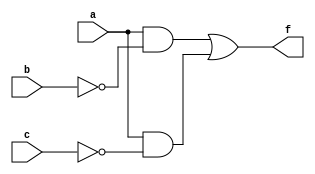

In [33]:
%%print_verilog -n fabc.v

module fabc(input a, b, c, output f);
  assign f = (a & ~b & ~c) | (a & ~b & c) | (a & b & ~c);
endmodule

module fabc1(input a, b, c, output f);
  assign f = a & (~b | ~c);
endmodule

module fabc2(input a, b, c, output f);
  assign f = (a & ~b) | (a & ~c);
endmodule

Em nosso teste, vamos usar um arquivo texto (`values.tv`) contendo o que chamamos de **vetores de teste** (*tv = test vectors*). Nele colocamos os valores em binário ou hexadecimal de acordo com a tabela verdade da função. As três primeiras colunas correspondem às entradas `a`, `b` e `c` e a última coluna é a saída esperada, ou seja, $\sum m(4,5,6)$. O caracter `_` é ignorado neste tipo de arquivo e foi usado apenas para separar as entradas da saída esperada.

In [34]:
%%writefile values.tv
000_0
001_0
010_0
011_0
100_1
101_1
110_1
111_0


Writing values.tv


Por conter um arquivo externo com os estímulos e as saídas esperadas, o teste a seguir tem algumas novas particularidades:
  1. Além das entradas, declaramos um `reg` para a saída esperada `e` (linha 5);
  1. Para carregar os valores do arquivo, declaramos um vetor de barramentos, algo como uma matriz, chamada `values` (linha 7). Nesta declaração temos um primeiro índice antes do nome `[3:0]` que especifica a largura do arquivo que vamos ler. O segundo índice, que fica depois do nome `[0:7]`, indica o número de linhas do arquivo e tem o seu intervalo especificado em ordem crescente (ao contrário da largura);
  1. Declaramos um variável inteira, que em Verilog tem 32 bits, para percorrer os casos de teste (linha 8);
  1. Instanciamos as três funções, note que cada uma precisa de um nome de instância diferente (linhas 10-12);
  1. Usamos a função `$readmemb` para carregar o conteúdo do arquivo para o vetor de testes (linha 17);
  1. Usamos um bloco de repetição `for` para:

      a) Carregar as entradas das funções e a saída esperada do vetor de testes (linhas 20-23);    
      b) Aguardar `#5`;  
      c) Verificar se a saída de cada uma das funções corresponde à saída esperada (linhas 25-30).

Nós criamos este arquivo externo de vetor de testes especialmente para informar as saídas esperadas, pois as entradas poderiam ser obtidas diretamente a partir dos bits da variável `i`, conforme os comentários no código:

VCD info: dumpfile dump.vcd opened for output.



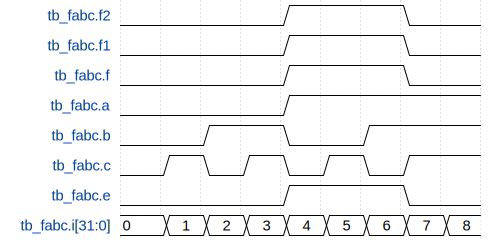

In [35]:
%%wavedrom
`include "fabc.v"

module tb_fabc;
  reg a, b, c, e;
  wire f, f1, f2;
  reg [3:0] values [0:7];
  integer i;

  fabc  dut (a, b, c, f);
  fabc1 dut1(a, b, c, f1);
  fabc2 dut2(a, b, c, f2);

  initial
  begin
    $dumpvars(1);
    $readmemb("values.tv", values);
    for (i=0; i<8; i=i+1)
    begin
      a = values[i][3]; // o mesmo que i[2];
      b = values[i][2]; // o mesmo que i[1];
      c = values[i][1]; // o mesmo que i[0];
      e = values[i][0];
      #5;
      if (f != e)
        $display("Erro no vetor %0d da função fabc, esperado %b, obtido %b!", i, e, f);
      if (f1 != e)
        $display("Erro no vetor %0d da função fabc1, esperado %b, obtido %b!", i, e, f);
      if (f2 != e)
        $display("Erro no vetor %0d da função fabc2, esperado %b, obtido %b!", i, e, f);
    end
    $finish;
  end
endmodule

## Formas canônicas (*mintermos* e *maxtermos*)

Chamamos de **forma canônica** da função lógica aquela que tem todos termos completos (com todas as variáveis). Ela pode ser gerada pela soma dos produtos (**SOP**), realizando um **somatório dos *mintermos***  (saidas 1) ou pelo produto das somas (**POS**), realizando o **produto dos *maxtermos*** (saidas 0). Vejamos a lista completa desses termos para uma função de três entradas:

\#|a|b|c||*mintermo*|*maxtermo*|
-|-|-|-||:-:|:-:|
0|0|0|0||$\bar{a}\bar{b}\bar{c}$|$\mbox{$a$+$b$+$c$}$|
1|0|0|1||$\bar{a}\bar{b}c$      |$\mbox{$a$+$b$+$\bar{c}$}$|
2|0|1|0||$\bar{a}b\bar{c}$      |$\mbox{$a$+$\bar{b}$+$c$}$|
3|0|1|1||$\bar{a}bc$            |$\mbox{$a$+$\bar{b}$+$\bar{c}$}$|
4|1|0|0||$a\bar{b}\bar{c}$      |$\mbox{$\bar{a}$+$b$+$c$}$|
5|1|0|1||$a\bar{b}c$            |$\mbox{$\bar{a}$+$b$+$\bar{c}$}$|
6|1|1|0||$ab\bar{c}$            |$\mbox{$\bar{a}$+$\bar{b}$+$c$}$|
7|1|1|1||$abc$                  |$\mbox{$\bar{a}$+$\bar{b}$+$\bar{c}$}$|

Voltando à nossa função do exemplo anterior $a\bar{b}\bar{c}+a\bar{b}c+ab\bar{c}$, notamos que ela está na forma canônica de SOP e podemos escrevê-la assim: $f(a,b,c) = \sum m(4,5,6)$, ou seja, uma soma (OR) das saídas **1**. Também podemos escrevê-la na forma canônica de POS como $(a+b+c)(a+b+\bar{c})(a+\bar{b}+c)(a+\bar{b}+\bar{c})(\bar{a}+\bar{b}+\bar{c})$ ou assim: $f(a,b,c) = \Pi M(0,1,2,3,7)$ que significa o produto (AND) das saídas **0**.



## Minimização de funções lógicas

A partir da função do exemplo anterior, pudemos notar que a forma canônica não é a que apresenta o menor custo de implementação e que consegimos representar a mesma função com um número menor de portas lógicas. A seguir veremos algumas formas de simplificação de funções lógicas.



### Álgebra Booleana

George Boole, um matemático inglês, introduziu em 1847 o sistema algébrico que mais tarde receberia o seu nome (**Álgebra de Boole**). A partir das funções lógicas básica já abordadas:

* OU (OR)
  - 0 + 0 = 0
  - 0 + 1 = 1
  - 1 + 0 = 1
  - 1 + 1 = 1 $\dagger$
* E (AND)
  - 0 . 0 = 0
  - 0 . 1 = 0
  - 1 . 0 = 0
  - 1 . 1 = 1
* NÃO (NOT)
  - ~0 = 1
  - ~1 = 0

podemos inferir alguns dos seus teoremas fundamentais:

* Idempotente
  - a + a = a $\dagger$
  - a . a = a $\dagger$
* Absorvente
  - a + 1 = 1 $\dagger$
  - a . 0 = 0
* Neutro
  - a + 0 = a
  - a . 1 = a
* Complementar
  - a + ~a = 1
  - a . ~a = 0
* Dupla negação
  - ~ (~a) = a

e também alguns axiomas:

* Comutatividade
  - a + b = b + a
  - a . b = b . a
* Associatividade
  - (a + b) + c = a + (b + c)
  - (a . b) . c = a . (b . c)
* Absortividade
  - a + (a . b) = a $\dagger$
  - a . (a + b) = a $\dagger$
* Distributividade
  - a + (b . c) = (a + b) . (a + c) $\dagger$
  - a . (b + c) = (a . b) + (a . c)
* De Morgan
  - ~a + ~b = ~(a . b)
  - ~a . ~b = ~(a + b)

$\dagger$ note que estas propriedades não são válidas na álgebra convencional.

### Manipulação algébrica de funções lógicas

Podemos usar a Álgebra Booleana para simplificar expressões lógicas. Voltando ao nosso exemplo, podemos partir da expressão original, na forma canônica:

$a\bar{b}\bar{c}+a\bar{b}c+ab\bar{c}$

colocando $a$ em evidência a partir da **distributividade** temos

$a(\bar{b}\bar{c}+\bar{b}c+b\bar{c})$

replicamos o termo $\bar{b}\bar{c}$ usando a **idempotente** e temos

$a(\bar{b}\bar{c}+\bar{b}\bar{c}+\bar{b}c+b\bar{c})$

trocamos a ordem dos termos usando a **comutatividade** temos

$a(\bar{b}\bar{c}+\bar{b}c+\bar{b}\bar{c}+b\bar{c})$

trocamos a ordem das variáveis dos dois últimos termos usando **comutatividade** e temos

$a(\bar{b}\bar{c}+\bar{b}c+\bar{c}\bar{b}+\bar{c}b)$

usando novamente a **distributividade** dentro dos parênteses temos

$a(\bar{b}[\bar{c}+c]+\bar{c}[\bar{b}+b])$

a partir da **complementar** temos

$a(\bar{b}.1+\bar{c}.1)$

finalmente a partir do elemento **neutro** temos

$a(\bar{b}+\bar{c})$

que é justamente uma das funções equivalentes do nosso exemplo anterior, já demonstrado na tabela verdade. A outra função equivalente também listada na mesma tabela pode ser obtida usando a **distributividade** para obter

$a\bar{b}+a\bar{c}$

Embora a manipulação algébrica seja uma alternativa viável para simplificar expressões, nem sempre a ordem das transformações é evidente, pois a técnica requer um pouco de prática. Para demonstrar que duas funções são equivalente temos a mesma dificuldade, mas neste caso podemos levar ambos os lados para a forma canônica, ordenar os termos e eliminar os repetidos para facilitar a prova.


Se você quiser fazer mais manipulações com a álgebra Booleana usando alguns pacotes em Python, [visite este Colab](https://colab.research.google.com/drive/1y31hX5Wq2WycFEMu-wza-aKWvCQWlSQw?usp=sharing).



### Mapas de Karnaugh

Os **Mapas de Karnaugh** são representações espaciais das funções lógicas que facilitam identificar variáveis irrelevantes nos termos e simplificá-los.

Nos mapas de Karnaugh, quando temos duas variáveis em uma dimensão, as duas últimas colunas são invertidas, para que possamos notar as vizinhanças corretamente. Além disso, a primeira e a última coluna são consideradas vizinhas, como se o mapa formasse um cilindo. Assim, a ordem dos *mintermos* em um mapa de três variáveis é a seguinte:


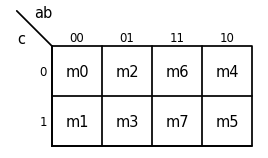

In [36]:
#@title
logic.Kmap(names='abc',
           truthtable=[('000', 'm0'),
                       ('001', 'm1'),
                       ('010', 'm2'),
                       ('011', 'm3'),
                       ('100', 'm4'),
                       ('101', 'm5'),
                       ('110', 'm6'),
                       ('111', 'm7')])

Vamos usar novamente nossa função $f(a,b,c) = \sum m(4,5,6)$ para demonstrar sua simplificação em um mapa de 3 variáveis. Preenchendo a saída da tabela verdade no mapa temos:

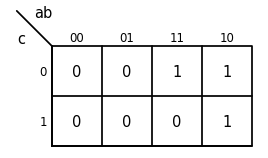

In [37]:
#@title
logic.Kmap(names='abc',
           truthtable=[('100', '1'),
                       ('101', '1'),
                       ('110', '1')])

Agora vamos listar alguns conceitos importantes para poder usar os Mapas de Karnaugh efetivamente:

*   **Implicante**: conjunto contíguo de $2^n$ mintermos;
*   **Implicante primo**: aquele que não pode ser expandido;
*   **Implicante primo essencial**: aquele que tem ao menos um mintermo que não faz parte de nenhum outro implicante;
*   **Cobertura**: conjunto de implicantes que define o valor 1 para a função.



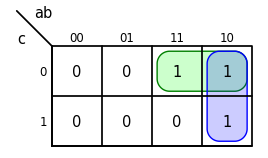

In [38]:
#@title
logic.Kmap(names='abc',
           truthtable=[('100', '1'),
                       ('101', '1'),
                       ('110', '1')],
           groups={'1.0': {'color' : 'green', 'fill': '#00ff0033'},
                   '10.': {'color' : 'blue', 'fill': '#0000ff33'}})

$\color{green}{a\bar{b}}+\color{blue}{a\bar{c}}$

Cada implicante no mapa corresponde a um termo da nossa função. Se ele só tem um mintermo, logo tem todas as variáveis. Se ele tem dois mintermos, verificamos qual a variável que muda de um para outro e a eliminamos. Assim, a cada expansão de um implicante uma variável é eliminada.

Para minimizar a função usando um Mapa de Karnaugh, preenchemos suas saídas no mapa, de acordo com a posição correta de cada mintermo/maxtermo. Depois encontramos os **implicantes primos essenciais** e verificamos se eles oferecem a **cobertura da função**. Se necessário, incluimos **implicantes primos não essenciais** até obter a cobertura da função.

O mesmo procedimento pode ser realizado para obter um **produto das somas** mínimo, **selecionando os maxtermos** ao invés dos mintermos e segundo os mesmos passos. Neste caso, os termos extraído são de soma e têm as variáveis invertidas.

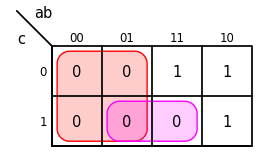

In [39]:
#@title
logic.Kmap(names='abc',
           truthtable=[('100', '1'),
                       ('101', '1'),
                       ('110', '1')],
           groups={'0..': {'color' : 'red', 'fill': '#ff000033'},
                   '.11': {'color' : 'magenta', 'fill': '#ff00ff33'}})

$\color{red}{a}.\color{magenta}{(\bar{b}+\bar{c})}$

## Funções com especificações incompletas (*don't care*)

Em alguma situações, podemos especificar funções lógicas em que a saída não importa para determinadas entradas. Pense, por exemplo, em um portão de correr com sensores de final de curso dos dois lados. Eles nunca seriam acionados ao mesmo tempo, já que o portão chegará ao final do trilho de um lado ou do outro em determinado momento, mas nunca aos dois lados ao mesmo tempo.

Voltando a nossa função inicial, imagine que queremos garantir que ela seja 1 para os mesmos mintermos 4, 5 e 6, e 0 para os demais, porém a saída para as entradas em que ($b=1, c=1$) não nos importa, já que sabemos que elas nunca acontecem. Especificamos a função assim $f(a,b,c) = \sum m(4,5,6)+d(3,7)$

No Mapa de Karnaugh usamos a letra `d` neste mintermo, que se torna um curinga, ou seja, pode ou não ser usado de acordo com a conveniência.

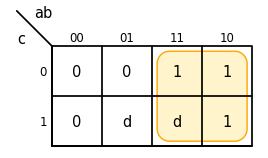

In [40]:
#@title
logic.Kmap(names='abc',
           truthtable=[('100', '1'),
                       ('101', '1'),
                       ('110', '1'),
                       ('011', 'd'),
                       ('111', 'd')],
           groups={'1..': {'color' : 'orange', 'fill': '#ffcc0033'}})


## Exercícios de fixação

### Para cada uma das funções a seguir, forneça:

- Sua tabela verdade com as colunas passo a passo;
- Seu diagrama de Venn final, obtido a partir dos respectivos diagramas de cada termo;
- Seu circuito correspondente;
- Sua forma mínima em SOP ou POS;
- Seu circuito correspondente (após simplificação);
- Suas implementações em Verilog;
- Um *test bench* que compare suas implementações.

1. $f(x,y,z)=\sum m(0,1,4,5)$
2. $f(x,y,z)=\sum m(0,1,2,3,4,6)$
5. $f(x,y,z)=\sum m(0,1,2,6)+D(3,4)$
3. $f(x,y,z)=\Pi M(0,1,4,5)$
4. $f(x,y,z)=\Pi M(0,1,2,4,5,7)$
6. $f(x,y,z)=\Pi M(0,1,2,4)+D(3,5,7)$

Você pode usar a célula abaixo para corrigir parte dos exercícios, basta digitar a função lógica que obteve e conferir a tabela verdade (*se tiver dúvidas, confira na mão, pois a ferramenta usada tem problemas de associatividade*). Se preferir, você pode também usar este [Colab com tabelas verdade](https://colab.research.google.com/drive/1zQVrOKWSwL47gXALfVCIzidrcG3vXqq3?usp=sharing).

In [41]:
#@title
from IPython.display import Markdown
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd

def dm(s):
  display(Markdown(s))

def eqn_bits_table(n,eq):
  if ( int(n) > 7 ):
    print("A tabela cresce exponencialmente, use valores pequenos de n")
    return
  vars = []
  for i in range(int(n)):
    vars.append("a"+str(i))

  vars.reverse()
  leq = []
  leq.append(eq)
  table = ttg.Truths(vars,leq)
# table.as_pandas().style.set_properties(**{'text-align':'center'}).hide_index()
  pd = table.as_pandas()
  pd = pd.reindex(index=pd.index[::-1])
  l = []
  for i in range(pd.shape[0]):
    l.append(i)
  pd['linha'] = l
  pd = pd.set_index('linha')
  print (pd.to_string(justify='center'))

dm('## Gerando a tabela para uma equação com N variáveis')

dm("Escreva uma equação com n variáveis")
dm("Exemplo n=3, equacao a0 or a1 and a2")

dummy = interact(eqn_bits_table,n="3",eq="a0 or a1 and a2")


## Gerando a tabela para uma equação com N variáveis

Escreva uma equação com n variáveis

Exemplo n=3, equacao a0 or a1 and a2

interactive(children=(Text(value='3', description='n'), Text(value='a0 or a1 and a2', description='eq'), Outpu…

# Sistemas de Numeração

Estamos acostumados com o sistema decimal para contar coisas e fazer operações matemáticas. Os computadores, como já vimos, trabalham com o sistema binário (base dois). Algumas linguagens computacionais compreendem base oito e dezesseis, pois são potências de dois e podem ser representadas facilmente por conjuntos de bits. Vejamos a seguir como os sistemas de numeração funcionam, como converter numeros entre eles e como realizar operações aritméticas nos computadores.

### Sistema Decimal
Um número **decimal** é representado com a notação posicional, onde cada dígito tem um peso em potência de 10.

Por exemplo, $x=251 = $ **2**  $\cdot 10^2 + $ **5**  $\cdot 10^1 +$ **1** $\cdot 10^0$.

Posição | 2 | 1 | 0
--|--|--|--
Potência | $10^2$ | $10^1$ | $10^0$
numero | $\boxed{2}$ | $\boxed{5}$  | $\boxed{1}$

### Sistema Binário

Em binário temos apenas 2 dígitos **0** e **1**. Podemos representar qualquer número na notação posicional com potências de 2.

Posição | 4| 3 |2 | 1 | 0
--|--|--|--|--|--
Potência | $2^4$| $2^3$| $2^2$ | $2^1$ | $2^0$
numero | $\boxed{1}$ | $\boxed{0}$  | $\boxed{1}$ | $\boxed{0}$  | $\boxed{0}$
bits | $b_4$ | $b_3$ | $b_2$ | $b_1$| $b_0$


<h3>Conversão de Binário para Decimal e vice-versa</h3>

Para converter, multiplicamos cada dígito binário pela sua potência de 2 e somamos.

Um número binário com $n$ bits terá o valor em decimal = $ \sum_{i}^{n-1} b_i \cdot 2^i = b_{n-1} \cdot 2^{n-1}+ \ldots + b_{1} \cdot 2^{1}+b_{0} \cdot 2^{0}$.


Por exemplo:

Posição | 4| 3 |2 | 1 | 0
--|--|--|--|--|--
Potência | $2^4$| $2^3$| $2^2$ | $2^1$ | $2^0$
numero | $\boxed{1}$ | $\boxed{0}$  | $\boxed{1}$ | $\boxed{0}$  | $\boxed{0}$
bits | $b_4$ | $b_3$ | $b_2$ | $b_1$| $b_0$
| 16 | 8 | 4 | 2 | 1
decimal = 20 = | 1*16+ | 0+ | 1*4 +| 0+ | 0


<h4>Conversão de Decimal para Binário</h4>

A conversão de Decimal em binário pode ser feita pelo método da divisão. A cada divisão, descobrimos um dígito binário:

$D = b_{n-1} \cdot 2^{n-1}+ \ldots + b_{1} \cdot 2^{1}+b_{0} \cdot 2^{0}$

$D/2 = b_{n-1} \cdot 2^{n-2}+ \ldots + b_{1} \cdot 2^{0}, \mbox{resto da divisão} = b_{0}$

$D/2/2 = b_{n-2} \cdot 2^{n-3}+ \ldots + b_{2} \cdot 2^{0}, \mbox{resto da divisão} = b_{1}$

$\ldots$

A tabela abaixo ilustra a conversão do número 26. Lembre-se que é a divisão **inteira** e seu resto.

D | Divisao | Resto | Bit
--|--|--|--
26 | 13 | $\boxed{0}$ | $b_0$
13 | 6  | $\boxed{1}$ | $b_1$
6  | 3 | $\boxed{0}$ | $b_2$
3 | 1 | $\boxed{1}$ | $b_3$
1 | 0 | $\boxed{1}$ | $b_4$

Portanto D em binário será a sequência gerada pelo resto das divisão na ordem invertida (da última linha para a primeira).

$D = \frac{b_4}{\boxed{1}} \frac{b_3}{\boxed{1}} \frac{b_2}{\boxed{0}} \frac{b_1}{\boxed{1}} \frac{b_0}{\boxed{0}} = 26_{decimal}$







In [42]:
#@title
def dm(s):
  display(Markdown(s))

from ipywidgets import interact, interactive, fixed, interact_manual
def bin2dec(Decimal,Binario):
  try:
    decimal = int(Decimal)
    binario = int(Binario, 2)
    if (decimal == binario):
      dm("Conversao correta!")
    else:
      dm("O valor não corresponde, favor refazer.")
  except:
    dm("Formato incorreto!")

dm('## Execute a célula para verificar a correspondência de números em  Decimal e Binario. Modifique os valores.')

dm("Digite um valor em decimal e seu equivalente em binário")
dummy = interact(bin2dec, Decimal="269",Binario='100001101');

## Execute a célula para verificar a correspondência de números em  Decimal e Binario. Modifique os valores.

Digite um valor em decimal e seu equivalente em binário

interactive(children=(Text(value='269', description='Decimal'), Text(value='100001101', description='Binario')…

In [43]:
#@title
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import random
from IPython.display import display, Markdown, Latex

def questao_aleatorio_lista_dropdown(l,cabecalho=""):
  x = random.randrange(len(l))
  display(Markdown("###"+cabecalho+l[x][0]+"?"))

  r = ["Selecione"]
  for i in l:
    r.append(i[1])

  def op(resposta):
    if (resposta== l[x][1]):
      return "Correto !"
    else:
      return "Tente novamente !"

  interact(op,resposta=r)


cabecalho = "Escolha a opção correta para converter decimal em binário para o número "

import random

L = []
for i in range(5):
  l = random.randint(4,8)
  s= ""
  for j in range(l):
    b = random.randint(0,1)
    s+= str(b)
  item = [str(int(s,2)),s]
  L.append(item)

dm('## A cada execução desta célula ela gera um exercício com auto-correção')

questao_aleatorio_lista_dropdown(L,cabecalho)

## A cada execução desta célula ela gera um exercício com auto-correção

###Escolha a opção correta para converter decimal em binário para o número 72?

interactive(children=(Dropdown(description='resposta', options=('Selecione', '0101', '1101', '010101', '100100…

<h3>Hexadecimal e Binário</h3>


A base hexadecimal (ou 16) é muito usado por ser bem fácil de converter de binário para hexadecimal e vice-versa. O número tem pesos com potência de 16. Por exemplo, o número $123_{hexadecimal} = 1 \cdot 16^2 + 2 \cdot  16^1 + 3 \cdot 16^0 = 256 + 32 + 3 = 291_{decimal}$.

Como precisamos de 16 dígitos, além dos 10 dígitos de $0,\ldots,9$, se utiliza as letras $a,\ldots,f$ para os valores de $10,\ldots,15$, respectivamente.

A tabela abaixo mostra a equivalência binário, decimal e hexadecimal de $0, \ldots, 15$.

binário | 0000 | 0001 | 0010 | 0011 | 0100 | 0101 | 0110 | 0111 | 1000 | 1001 | 1010 | 1011 | 1100 | 1101 | 1110 | 1111
--|       :--:| :--:| :--:| :--:| :--:| :--:| :--:|:--:| :--:| :--: |  :--:| :--:| :--:| :--:| :--:| :--:
hexadecimal | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | **a** | **b** | **c** | **d** | **e** |**f**
decimal | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15

<h4>Converter de Binário para Hexadecimal</h4>

Basta agrupar os bits de 4 em 4 e completar com zero, o agrupamento mais a esquerda. Depois converter cada grupo de 4 bits no dígito hexadecimal. A conversão inversa transforma cada dígito hexadecimal em um grupo de 4 bits binário.

Exemplo:

$D = \color{black}{\text{10}} \color{blue}{\text{1101}}\color{darkblue}{\text{0011}}$

$D = \boxed{10}\boxed{1101}\boxed{0011}$

$D = \frac{\boxed{0010}}{2}\frac{\boxed{1101}}{d}\frac{\boxed{0011}}{3}=2d3_{hexadecimal}$




In [44]:
#@title
cabecalho = "Escolha a opção correta para converter hexadecimal em binário para o número "

import random

L = []
for i in range(5):
  l = random.randint(400,1200)
  s= hex(l)
  b = bin(l)
  item = [s,b]
  L.append(item)

dm('## A cada execução desta célula ela gera um exercício com auto-correção')

questao_aleatorio_lista_dropdown(L,cabecalho)

## A cada execução desta célula ela gera um exercício com auto-correção

###Escolha a opção correta para converter hexadecimal em binário para o número 0x3be?

interactive(children=(Dropdown(description='resposta', options=('Selecione', '0b10000101011', '0b1011100001', …

### Representação em Verilog

Em Verilog podemos usar binário, octal, decimal e hexadecimal. Pode ser com ou sem sinal. Podemos usar float também, mas falaremos disso mais tarde.

Qualquer número precisa ter definido a quantidade de bits que será alocada. Por exemplo, o número 5 com 4 bits em binário será $\boxed{0}\boxed{1}\boxed{0}\boxed{1}$.

Ele pode ser declarado de várias formas, por exemplo:
```verilog
wire [3:0] num;
assign num = 4'b0101;  // binario 4 bits
```
onde **4** é número de bits e **b** diz para interpretar os números seguintes como binário.

Vejamos outro exemplo:
```verilog
wire [3:0] num;
assign num = 4'b10;  // numero 2 decimal, 10 em binário
```

será o número 2 com 4 bits = $\boxed{0}\boxed{0}\boxed{1}\boxed{0}$.
que é diferente de
```verilog
wire [3:0] num;
assign num = 4'd10;  // numero 10 decimal, 1010 em binário
```
que diz que é para usar 4 bits mas o **d** diz para interpretar o numero **10** como um numero decimal. Portanto será  $\boxed{1}\boxed{0}\boxed{1}\boxed{0}=10_{decimal}$

Já em hexadecimal, usaremos a letra **h**, por exemplo:
```verilog
wire [6:0] num;
assign num = 7'h10;  // numero 10 hexacimal, 001 0000 em binário, 16 decimal
```
que diz que é para usar 7 bits e o **h** diz para interpretar o numero **10** como um numero hexacimal. Portanto será  $\boxed{0}\boxed{0}\boxed{1} \mbox{ }\boxed{0}\boxed{0}\boxed{0}\boxed{0}=16_{decimal}$


Exemplos que geram muita confusão são
```verilog
assign a = 1'b0;  // a=0
assign b = 1'b1;  // b=1
assign c = 1'd0;  // c=0
assign d = 1'd1;  // d=1
```

Então guarde a notação: $\frac{\mbox{w}}{\boxed{3'}}\frac{\mbox{B}}{\boxed{d}}\frac{\mbox{n}}{\boxed{5}}$


Para saber mais, você pode usar este [Colab com vários exercícios de sistema de numeração](https://colab.research.google.com/drive/1U654FtCg5_ZEtmObc8SZIfZl4vk2pxDS?usp=sharing) ou este outro [Colab com vários exercícios com potências de 2 e codificação binária](https://colab.research.google.com/drive/1TfEfRBnuUE460h_Oct4zSMh4G63yCGZr?usp=sharing).

## Aritmética Binária

Vejamos agora como os números são manipulados nos computadores usando Aritmética Binária.

### Números sem Sinal

Suponha o exemplo da soma de 3+3 em binário, como ilustrado abaixo:

$ \begin{array}{cccc}
& b_2 & b_1 & b_0 \\
+ & 0 & 1 & 1 \\
& 0 & 1 & 1 \\
& - & - & - \\
& ? & ? & ?  \end{array} $

A soma em binário é semelhante a soma em decimal, mas como a base é 2, portanto teremos 4 possibilidades e apenas a última (1+1) terá vai-um:

$ \begin{array}{ccccccccc}
     &   &   &   &   &   & & 1 & \leftarrow \\
    & 0 &  & 0 &  & 1 &  & & 1 \\
   + & 0 & + & 1 & + & 0 & + & & 1 \\
    & - &  & - &  & - &  & - & - \\
    & 0 & & 1 & & 1 & & 1 & 0
 \end{array} $

para soma 3+3 que é 6 em decimal, teremos em binário:


$ \begin{array}{ccrr}
\mbox{vai-um} & 1 & \leftarrow 1 & \leftarrow ~~ \\
+ & 0 & 1 & 1 \\
& 0 & 1 & 1 \\
& - & - & - \\
& 1 & 1 & 0  \end{array} $

observe que temos no bit $b_1$ a soma de 1 + 1 + 1 que tem o resultado 1 e vai-um.



In [45]:
#@title
from ipywidgets import interact, interactive, fixed, interact_manual
def bin2dec(A,B,A_bin,B_bin,Soma_Bin):
  abin = int(A_bin,2)
  bbin = int(B_bin,2)
  soma = int(A)+int(B)
  if ( abin+bbin == int(A)+int(B) and (abin+bbin == int(Soma_Bin,2) )):
    print("Conversao correta e a soma = ",soma)
  else:
    print("Os valores não correspondem, favor refazer.")

dm('## Execute a célula para verificar a correspondência dos valores em binario e sua soma')
print("Modifique os valores de A e B em decimal e seus equivalentes em binário A, B e A+B")
interact(bin2dec, A="12", A_bin="1100", B="6",B_bin="110",Soma_Bin="10010");

## Execute a célula para verificar a correspondência dos valores em binario e sua soma

Modifique os valores de A e B em decimal e seus equivalentes em binário A, B e A+B


interactive(children=(Text(value='12', description='A'), Text(value='6', description='B'), Text(value='1100', …

In [46]:
#@title
cabecalho = "Escolha a opção correta para somar de 2 numeros binarios "

import random

L = []
for i in range(5):
  a = random.randint(4,20)
  b = random.randint(4,20)
  ba = bin(a)
  bb = bin(b)
  Len = len(ba)
  if ( Len < len(bb)):
    ba = "0"*(len(bb)-len(ba))+ba[2:]
    bb = bb[2:]
  else:
    bb = "0"*(len(ba)-len(bb))+bb[2:]
    ba = ba[2:]
  s = "\n &nbsp; "+ba+"<br>"+"\\+"+bb+"<br>----------"
  r = bin(a+b)
  item = [s,r[2:]]
  L.append(item)

dm('## Teste seus conhecimentos, cada execução gera um novo exercício')

questao_aleatorio_lista_dropdown(L,cabecalho)

## Teste seus conhecimentos, cada execução gera um novo exercício

###Escolha a opção correta para somar de 2 numeros binarios 
 &nbsp; 1001<br>\+0101<br>----------?

interactive(children=(Dropdown(description='resposta', options=('Selecione', '10011', '10000', '10000', '10101…

<h3>Complemento de dois</h3>

<h4>Sinal e magnitude</h4>

Em decimal, um número negativo é precedido por  um sinal, por exemplo $+2$ e $-2$ para representar o número $2$ positivo e negativo.

Em binário podemos usar o mesmo padrão, colocando um "bit" a mais para representar o sinal. Supondo sinal=0 para positivos e o sinal=1 para negativos, para um número de 2 bits com sinal $ \boxed{s}\boxed{b_1}\boxed{b_0}$, teriamos $ \color{red}{\text{+}}2 = \boxed{\color{red}{\text{0}}}\boxed{1}\boxed{0}$ e $ \color{red}{\text{-}}2 = \boxed{\color{red}{\text{1}}}\boxed{1}\boxed{0}$.

Entretanto, esta representação não é simétrica em relação ao zero e possui duas representações para o número zero.

<h4>Complemento de dois</h4>

O complemento de dois é uma codificação binária de forma que problemas matemáticos comuns se tornem muito simples de implementar. A conversão de um número positivo em negativo (e vice-versa) é feita invertendo todos os bits do número e adicionando um. O complemento de dois é particularmente útil para operações aritméticas, pois permite realizar operações como adição e subtração usando apenas operações bit a bit sem se preocupar com o sinal.

<h4>Conversão de sinal</h4>

Para um número de 2 bits com sinal, teremos 3 bits: 1 bit sinal + 2 bits para representar o número ($ \boxed{s}\boxed{b_1}\boxed{b_0}$).

Suponha o número 2,  temos $ \color{red}{\text{+}}2 = \boxed{\color{red}{\text{0}}}\boxed{1}\boxed{0}$ para o número positivo. Igual a representação que já estamos usando com um bit de sinal mais a esquerda. O sinal=0 é o padrão para número positivo.

Para transformar para negativo, temos que inverter e somar um, portanto
 $ \color{red}{\text{-}}2 = Inverter(\boxed{\color{red}{\text{0}}}\boxed{1}\boxed{0})+1 = \boxed{\color{red}{\text{1}}}\boxed{0}\boxed{1}+1= \boxed{\color{red}{\text{1}}}\boxed{1}\boxed{0} =  \color{red}{\text{-}}2 $.

> *Existe um truque para facilitar o procedimento, basta copiar o número da direita para a esquerda até encontrar o primeiro 1 e depois copiar os demais números invertidos.*

A tabela abaixo mostra todos os números que podem ser codificados com complemento de 2 em 3 bits, sendo um bit para o sinal:

Decimal | Complemento de 2
---|---
$ \color{red}{\text{+}}0$ | $\boxed{\color{red}{\text{0}}}\boxed{0}\boxed{0}$
$ \color{red}{\text{+}}1$ | $\boxed{\color{red}{\text{0}}}\boxed{0}\boxed{1}$
$ \color{red}{\text{+}}2$ | $\boxed{\color{red}{\text{0}}}\boxed{1}\boxed{0}$
$ \color{red}{\text{+}}3$ | $\boxed{\color{red}{\text{0}}}\boxed{1}\boxed{1}$
$ \color{red}{\text{-}}4$ | $\boxed{\color{red}{\text{1}}}\boxed{0}\boxed{0}$
$ \color{red}{\text{-}}3$ | $\boxed{\color{red}{\text{1}}}\boxed{0}\boxed{1}$
$ \color{red}{\text{-}}2$ | $\boxed{\color{red}{\text{1}}}\boxed{1}\boxed{0}$
$ \color{red}{\text{-}}1$ | $\boxed{\color{red}{\text{1}}}\boxed{1}\boxed{1}$

<h4>Números com mais bits</h4>

Se quisermos representar um número positivo com mais bits, basta adicionar **zeros** a esquerda. Por exemplo, o número +2 com 5 bits será $ \color{red}{\text{+}}2 = \boxed{\color{red}{\text{0}}}\boxed{0}\boxed{0}\boxed{1}\boxed{0}$. Teremos 1 bit de sinal e 4 bits para representar o número. Então podemos representar de $0,+1,\ldots,+15$ com 5 bits (sendo um bit de sinal) para os números positivos.

Para converter em complemento de 2, usamos o mesmo procedimento de inverter e somar 1, teremos $ \color{red}{\text{-}}2 = Inverter(\boxed{\color{red}{\text{0}}}\boxed{0}\boxed{0}\boxed{1}\boxed{0})+1 = \boxed{\color{red}{\text{1}}}\boxed{1}\boxed{1}\boxed{0}\boxed{1}+1= \boxed{\color{red}{\text{1}}}\boxed{1}\boxed{1}\boxed{1}\boxed{0} =  \color{red}{\text{-}}2 $.

A tabela abaixo mostra alguns números que podem ser codificados com complemento de 2 em 5 bits, sendo um bit para o sinal

Decimal | Complemento de 2
--:|:-:
$ \color{red}{\text{+}}0$ | $\boxed{\color{red}{\text{0}}}\boxed{0}\boxed{0}\boxed{0}\boxed{0}$
$ \color{red}{\text{+}}1$ | $\boxed{\color{red}{\text{0}}}\boxed{0}\boxed{0}\boxed{0}\boxed{1}$
$\ldots$ | $\ldots$
$ \color{red}{\text{+}}15$ | $\boxed{\color{red}{\text{0}}}\boxed{1}\boxed{1}\boxed{1}\boxed{1}$
$ \color{red}{\text{-}}16$ | $\boxed{\color{red}{\text{1}}}\boxed{0}\boxed{0}\boxed{0}\boxed{0}$
$ \color{red}{\text{-}}15$ | $\boxed{\color{red}{\text{1}}}\boxed{0}\boxed{0}\boxed{0}\boxed{1}$
$\ldots$ | $\ldots$
$ \color{red}{\text{-}}2$ | $\boxed{\color{red}{\text{1}}}\boxed{1}\boxed{1}\boxed{1}\boxed{0}$
$ \color{red}{\text{-}}1$ | $\boxed{\color{red}{\text{1}}}\boxed{1}\boxed{1}\boxed{1}\boxed{1}$


Ou seja, com $n$ bits (incluindo o sinal) é possível codificar de $-2^{n-1}, \ldots, -1, 0, +1, \ldots +2^{n-1}-1$. Para n=5, podemos representar de -16 a +15.

Observe que o número -1 sempre terá todos os bits ligados. Temos 1 número negativo a mais, pois o zero está usando um código da parte positiva.


In [47]:
#@title
from ipywidgets import interact, interactive, fixed, interact_manual
def complemento2(positivo,negativo):
  overflow = 15
  decimal = int(positivo,2)
  negnum = bin((decimal^overflow)+1)
  if ( negativo == negnum[2:]):
    print("Conversao correta !")
  else:
    print("O valor não corresponde, favor refazer.")

dm('## Escreva o número positivo e negativo com complemento de 2 com 4 bits.')

print("Modifique o valor em binário e seu complemento de 2 (4 bits)")
interact(complemento2, positivo="0110",negativo='1010');

## Escreva o número positivo e negativo com complemento de 2 com 4 bits.

Modifique o valor em binário e seu complemento de 2 (4 bits)


interactive(children=(Text(value='0110', description='positivo'), Text(value='1010', description='negativo'), …

In [48]:
#@title

from ipywidgets import interact, interactive, fixed, interact_manual
def complemento2(numero_bits,positivo,negativo):
  print("**")
  overflow = 2**int(numero_bits)-1
  decimal = int(positivo,2)
  negnum = bin((decimal^overflow)+1)
  if ( negativo == negnum[2:]):
    print("Conversao correta !")
  else:
    print("O valor não corresponde, favor refazer.")


dm('## Agora com N bits')
print("Selecione o número de bits da representação \n Um valor em binário e seu complemento de 2")
interact(complemento2, numero_bits=4, positivo="0110", negativo='1010');

## Agora com N bits

Selecione o número de bits da representação 
 Um valor em binário e seu complemento de 2


interactive(children=(IntSlider(value=4, description='numero_bits', max=12, min=-4), Text(value='0110', descri…

<h3>Aritmética com complemento de 2</h3>

A grande vantagem da representação em complemento de 2 é que podemos realizar operações de soma sem se preocupar com o sinal dos operandos. Vamos considerar 3 bits para codificação, incluindo sinal. Vamos fazer a operação +1 + (-2) = -1.

$ \begin{array}{ccccc}
& \color{red}{\text{s}} & b_1 & b_0 & Decimal\\
+ & \color{red}{\text{0}} & 0 & 1 & +1\\
& \color{red}{\text{1}} & 1 & 0 & -2 \\
& - & - & - & - \\
& ? & ? & ?  & -1\end{array} $

Então teremos

$ \begin{array}{ccccc}
\mbox{vai-um} & 0 & 0 &  & Decimal\\
+ & \color{red}{\text{0}} & 0 & 1 & +1 \\
& \color{red}{\text{1}} & 1 & 0 & -2\\
& - & - & - & - \\
& \color{red}{\text{1}} & 1 & 1  & -1 \end{array} $

<h4>+x + (-x) = 0 ?</h4>

Sempre que somarmos o número e seu complemento teremos o resultado 0. Por exemplo:

$ \begin{array}{ccccc}
\mbox{vai-um} & 1 & \leftarrow &  & Decimal\\
+ & \color{red}{\text{0}} & 1 & 0 & +2 \\
& \color{red}{\text{1}} & 1 & 0 & -2\\
& - & - & - & - \\
& \color{red}{\text{0}} & 0 & 0  & 0 \end{array} $

Observe que não consideramos o vai-um do bit de sinal, pois  a codificação é limitada a 3 bits, neste exemplo.

Outro exemplo:

$ \begin{array}{ccccc}
\mbox{vai-um} & 1 & \leftarrow 1 & \leftarrow & Decimal\\
+ & \color{red}{\text{0}} & 0 & 1 & +1 \\
& \color{red}{\text{1}} & 1 & 1 & -1\\
& - & - & - & - \\
& \color{red}{\text{0}} & 0 & 0  & 0 \end{array} $

<h4>Overflow</h4>

Chamamos *overflow* quando ocorre um estouro da capacidade de representação, o que só ocorre quando somamos números com o mesmo sinal. A forma mais simples de detectá-lo é fazer um ou exclusivo (XOR) entre os dois últimos vai um, pois se eles forem diferentes ocorreu o problema.

No exemplo a seguir, vamos usar 4 bits, o que nos dá um campo de representação entre -8 e 7. Qualquer resultado fora deste intervalo terá os dois últimos vai um diferentes, indicando *overflow*.

$ \begin{array}{rrrrrc}
\color{red}{0} & \leftarrow \color{red}{1} & \leftarrow 0 & \leftarrow 0 & \leftarrow ~~ & Decimal\\
& 0 & 1 & 0 & 0 & +4 \\
& +0 & 1 & 0 & 0 & +4 \\
& - & - & - & - \\
& 1 & 0 & 0  & 0 & \color{red}{-8}\end{array} $

Note que o último vai um é 0, mas como é diferente do anterior, acusa o problema. Agora usando negativos:

$ \begin{array}{rrrrrc}
\color{red}{1} & \leftarrow \color{red}{0} & \leftarrow 0 & \leftarrow 0 & \leftarrow ~~ & Decimal\\
& 1 & 0 & 0  & 0 & \color{red}{-8} \\
& +1 & 1 & 1 & 1 & -1 \\
& - & - & - & - \\
& 0 & 1 & 1 & 1 & \color{red}{+7} \\
\end{array} $

Resumindo, se somamos dois números com o mesmo sinal e o resultado tem sinal diferente ocorreu *overlflow*. No hardware é mais fácil comparar os dois últimos vai um para detectar isso do que comparar os sinais das entradas e da saída.

In [49]:
#@title

from ipywidgets import interact, interactive, fixed, interact_manual
def somacomplemento2(a,b,soma):
  na = int(a,2)
  nb = int(b,2)
  s = na+nb
  bs = bin(s)
  bs = bs[2:]
  if (len(bs) < 4):
    bs = "0"*(4-len(bs))+bs
  bs = bs[-4:]
  if ( bs == soma):
     print("Conversao correta !")
  else:
    print("O valor não corresponde, favor refazer.")

dm('## Usando números de 4 bits, escreva números A e B e sua soma')

print("Modifique A, B e a soma em complemento 2\nOs números podem ser positivos ou negativos.")
interact(somacomplemento2, a="0110",b='1010', soma='0000');

## Usando números de 4 bits, escreva números A e B e sua soma

Modifique A, B e a soma em complemento 2
Os números podem ser positivos ou negativos.


interactive(children=(Text(value='0110', description='a'), Text(value='1010', description='b'), Text(value='00…

## Circuitos Aritméticos

### Meio somador (*half adder*)

Vamos descrever a seguir alguns circuitos artiméticos básicos, começando pelo meio somador. Ele é assim chamado porque é capaz de somar dois bits (`a` e `b`), gerar o resultado da soma (`s`) e o vai-um (`c` = *carry*), mas não é capaz de receber o vem-um da soma anterior, ou seja, não pode ser encadeado para formar um somador de vários bits.

a | b || c | s
--|---||---|---
0|0||0|0
0|1||0|1
1|0||0|1
1|1||1|0


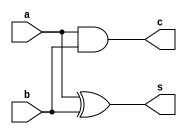

In [50]:
%%print_verilog -n half_adder.v

module half_adder(
    input a, b,
    output s, c);

    assign s = a ^ b;
    assign c = a & b;
endmodule

<h2>Somador completo (<i>full adder</i>)</h2>

Um somador completo pode ser combinado com outros para realizar a soma de vários bits, conforme [explicado anteriormente](#scrollTo=Aritm_tica_Bin_ria). Para isso adicionamos uma porta de entrada ($c_{in}$) para receber um bit adicional da soma anterior:

a | b | $c_{in}$ || $c_{out}$ | s
--|--|:-:||:-:|---
0|0|0||0|0
0|0|1||0|1
0|1|0||0|1
0|1|1||1|0
1|0|0||0|1
1|0|1||1|0
1|1|0||1|0
1|1|1||1|1

Ele pode ser implementado a partir de dois meio somadores e uma porta OR adicional como a seguir. Aproveitamos a ocasião para explicar outra forma de especificar hardware em Verilog. O módulo `half_adder` está descrito em uma forma que podemos chamar **funcional** (ou **dataflow**) , ou seja, cada saída é uma função direta das entradas. Já o módulo `full_adder` está escrito na forma **estrutural**, que é quando criamos um módulo de forma hierárquica, instanciando módulos menores ou primitivas básicas (note o comando que inclui o módulo definido anteriormente `include "half_adder.v"`).

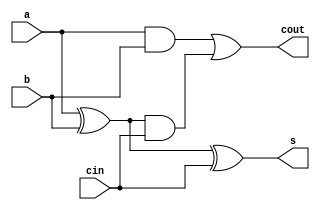

In [51]:
%%print_verilog -n full_adder.v
`include "half_adder.v"

module full_adder(
    input a, b, cin,
    output s, cout);

    wire c0, c1, s0; // podem ser omitidas já que possuem um único bit

    half_adder m0(a, b, s0, c0);
    half_adder m1(s0, cin, s, c1);
    or (cout, c0, c1);
endmodule

Na simulação a seguir usamos os bits da própria variável de iteração `i` para fornecer os estímulos em todas as combinações possíveis:

VCD info: dumpfile dump.vcd opened for output.
i                        ...3210||a|b|c||c|s
00000000000000000000000000000000||0|0|0||0|0
00000000000000000000000000000001||0|0|1||0|1
00000000000000000000000000000010||0|1|0||0|1
00000000000000000000000000000011||0|1|1||1|0
00000000000000000000000000000100||1|0|0||0|1
00000000000000000000000000000101||1|0|1||1|0
00000000000000000000000000000110||1|1|0||1|0
00000000000000000000000000000111||1|1|1||1|1
00000000000000000000000000001000||1|1|1||1|1



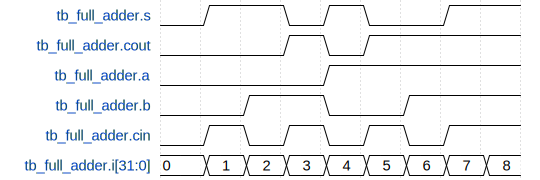

In [52]:
%%wavedrom
`include "full_adder.v"

module tb_full_adder;
  reg a, b, cin;
  wire s, cout;
  integer i;

  full_adder dut(a, b, cin, s, cout);

  initial
  begin
    $dumpvars(1);
    $display("i                        ...3210||a|b|c||c|s");
    $monitor("%3b||%b|%b|%b||%b|%b", i, a, b, cin, cout, s);
    for (i=0; i<8; i=i+1)
    begin
      cin = i[0];
        b = i[1];
        a = i[2];
      #5;
    end
    $finish;
  end
endmodule

<h2>Somador <i>ripple-carry</i></h2>

Um somador *ripple-carry* é a forma mais simples de realizar uma soma de vários bits. Ele é construido a partir de vários somadores complentos encadeados.

A seguir está o código Verilog e o respectivo circuito para um somador de 4 bits. Note que o caminho de propagação do sinal que vai de `cin` até `cout` é longo e vai aumentando a cada novo somador adicionado, esta é a sua desvantagem. A vantagem é a simplicidade, pois o circuito é uniforme, bastando um somador completo identico para cada novo bit.

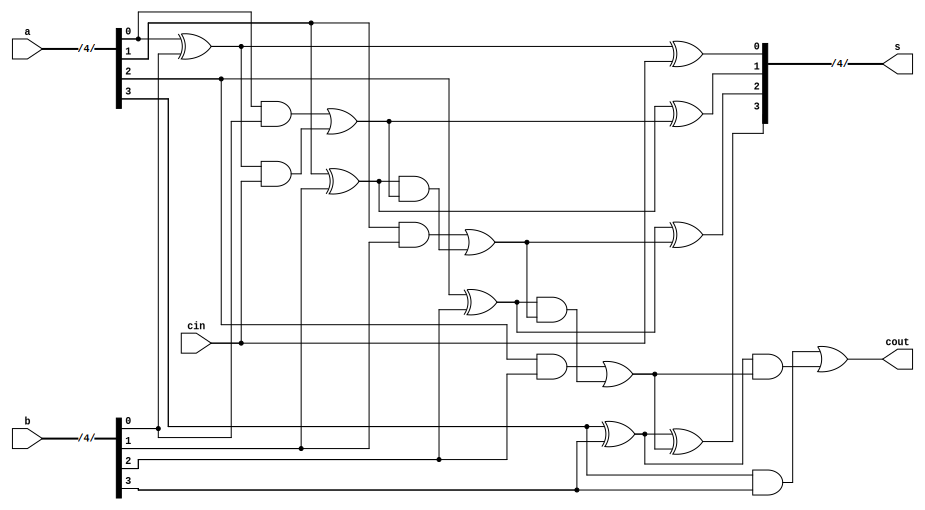

In [53]:
%%print_verilog -n adder4.v
`include "full_adder.v"

module adder4(
    input [3:0] a, b,
    input cin,
    output [3:0] s,
    output cout);

    wire [4:0] c;

    assign c[0] = cin;
    full_adder a0(a[0], b[0], c[0], s[0], c[1]);
    full_adder a1(a[1], b[1], c[1], s[1], c[2]);
    full_adder a2(a[2], b[2], c[2], s[2], c[3]);
    full_adder a3(a[3], b[3], c[3], s[3], c[4]);
    assign cout = c[4];
endmodule

No *test bench* a seguir usamos a mesma estratégia de atribuir partes do contador da iteração para as entadas, porém $2^9$ resultaria em 512 casos de teste, então estamos fazendo o incremento a cada 25 para reduzir o número de casos. Declaramos a saída `s` com um bit a mais e concatenamos o vai-um (`cout`) neste último bit para termos o número correto no resultado. No monitor informamos `%d` para obter os resultados em decimal, mas na simulação eles aparecem em hexadecimal.  

VCD info: dumpfile dump.vcd opened for output.
 a +  b + cin = {cout,s}
 0 +  0 +   1 =       1
 0 + 13 +   0 =      13
 1 +  9 +   1 =      11
 2 +  6 +   0 =       8
 3 +  2 +   1 =       6
 3 + 15 +   0 =      18
 4 + 11 +   1 =      16
 5 +  8 +   0 =      13
 6 +  4 +   1 =      11
 7 +  1 +   0 =       8
 7 + 13 +   1 =      21
 8 + 10 +   0 =      18
 9 +  6 +   1 =      16
10 +  3 +   0 =      13
10 + 15 +   1 =      26
11 + 12 +   0 =      23
12 +  8 +   1 =      21
13 +  5 +   0 =      18
14 +  1 +   1 =      16
14 + 14 +   0 =      28
15 + 10 +   1 =      26



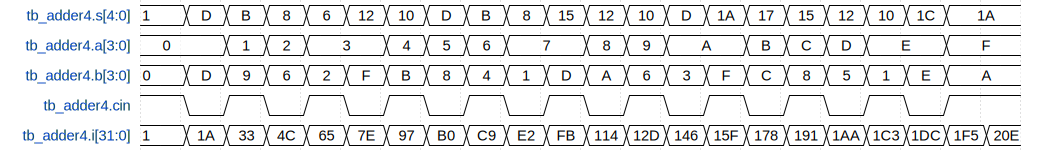

In [54]:
%%wavedrom
`include "adder4.v"

module tb_adder4;
  reg [3:0] a, b;
  reg cin;
  wire [4:0] s;
  integer i, j;

  adder4 dut(a, b, cin, s[3:0], s[4]);

  initial
  begin
    $dumpvars(1);
    $display(" a +  b + cin = {cout,s}");
    $monitor("%d + %d + %3b = %7d", a, b, cin, s);
    for (i=1; i<512; i=i+25)
    begin
      cin = i[0];
        b = i[4:1];
        a = i[8:5];
      #5;
    end
    $finish;
  end
endmodule

Para resolver o problema de atraso a cada bit adicionado é possível construir um circuito que antecipa o vai-um e dá o resultado mais rápido (*carry lookahead*), mas ele cresce a cada novo bit adicionado. Esta solução não será abordada aqui, você pode pesquisá-la por contra própria e testar nas células abaixo, trocando o código da implementação.

<h3>Módulos parametrizados</h3>

Vamos aproveitar a ocasião para introduzir o conceito de parâmetros em Verilog. Podemos definir um módulo, cujas propriedades são pametrizáveis, por exemplo, a largura de suas portas. Assim, quando ele for instanciado, podemos usá-lo com o valor padrão dos parâmetros ou modificar em cada instância para obter um módulo personalizado.

No trecho de código a seguir as portas `a`, `b` e `s` do somandor terão sua largura definida de acordo com o parâmetro `width` declarado logo abaixo:

```verilog
module N_bits_adder(
    input [width-1:0] a, b,
    input cin,
    output [width-1:0] s,
    output cout);

    parameter width = 8; //largura padrão
    ...
```

Depois declaramos um fio `c` com um bit a mais e a variável de geração `i`.

```verilog
    wire [width:0] c;
    genvar i;
```

Dentro de um bloco `generate`/`endgenerate` usamos o comando `for` para instanciar cada um dos somadores, usando o fio `c` para propagar os vai-uns.

```verilog
    generate
        for (i=0; i<width; i=i+1)
            full_adder bit(a[i], b[i], c[i], s[i], c[i+1]);
    endgenerate
```

Cada bit do fio `c` foi ligado nas duas pontas, exceto o primeiro e o último, então tratamos isso fora do bloco.

```verilog

    assign c[0] = cin;
    assign cout = c[width];
```

O código completo está a seguir:

In [55]:
%%verilog -n N_bits_adder.v
`include "full_adder.v"

module N_bits_adder(
    input [width-1:0] a, b,
    input cin,
    output [width-1:0] s,
    output cout);

    parameter width = 8; //largura padrão

    wire [width:0] c;
    genvar i;

    generate
        for (i=0; i<width; i=i+1)
            full_adder bit(a[i], b[i], c[i], s[i], c[i+1]);
    endgenerate

    assign c[0] = cin;
    assign cout = c[width];
endmodule


Assim conseguimos construir um somador de largura variável, bastando mudar o valor de `width` quando ele for instanciado. Isso pode ser feito de duas formas.

* Na forma mais compacta, usamos um bloco `#()` e colocamos os parâmetros dentro, separando por vírgula se houver mais de um:

```verilog
    N_bits_adder #(4) dut4 (a[3:0], b[3:0], cin, s[3:0], c);
```

* Na forma mais explícita, usamos o comando `defparam` para indicar cada valor individualmente:

```verilog
    defparam dut2.width = 2;
    N_bits_adder dut2 (a[5:4], b[5:4], c, s[5:4], cout);
```



Para demonstrar o conceito, vamos construir um somador de 6 bits a partir destas 2 instancias do somador parametrizável `N_bits_adder`.

* A primeira vai somar os 4 bits menos significativos:
* A segunda vai somar os 2 bits mais significativos:

Elas estão encadeadas pelo sinal de vai-um (`c`).

In [56]:
%%verilog -n adder6bits.v
`include "N_bits_adder.v"

module adder6bits(
    input [5:0] a, b,
    input cin,
    output [5:0] s,
    output cout);

    wire c;

    N_bits_adder #(4) dut4 (a[3:0], b[3:0], cin, s[3:0], c);

    defparam dut2.width = 2;
    N_bits_adder dut2 (a[5:4], b[5:4], c, s[5:4], cout);
endmodule

A estrutura deste módulo não faz muito sentido, uma vez que poderiamos ter instanciado o nosso somador genérico com 6 bits uma única vez, mas já que o fizemos, vamos testar para provar que ele funciona:

In [57]:
%%verilog
`include "adder6bits.v"

module tb_adder6bits;
  reg [5:0] a, b;
  reg cin;
  wire [6:0] s;
  integer i, j;

  adder6bits dut(a, b, cin, s[5:0], s[6]);

  initial
  begin
    $dumpvars(1);
    $display(" a +  b + cin = {cout,s}");
    $monitor("%d + %d + %3b = %7d", a, b, cin, s);
    for (i=0; i<1<<13; i=i+1333)
    begin
      cin = i[0];
        b = i[6:1];
        a = i[12:7];
      #5;
    end
    $finish;
  end
endmodule

VCD info: dumpfile dump.vcd opened for output.
 a +  b + cin = {cout,s}
 0 +  0 +   0 =       0
10 + 26 +   1 =      37
20 + 53 +   0 =      73
31 + 15 +   1 =      47
41 + 42 +   0 =      83
52 +  4 +   1 =      57
62 + 31 +   0 =      93



A própria linguagem Verilog possui operadores aritméticos, então é possível construir um somador apenas usando este operador. Note que é possível usar o operador de concatenação `{}` do lado esquerdo da expressão de atribuição para pegar o bit excedente no `cout`.

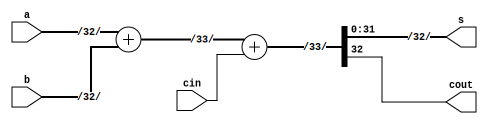

In [58]:
%%print_verilog

module adder(
    input [N-1:0] a, b,
    input cin,
    output [N-1:0] s,
    output cout);
    parameter N = 32;
    assign {cout, s} = a + b + cin;
endmodule

# Circuitos combinacionais típicos

Agora que já sabemos as formas de representação e manipulação de circuitos digitais, vamos conhecer alguns **circuitos combinacionais** típicos e suas respectivas construções em Verilog. Estes são chamados combinacionais porque suas saídas dependem exclusivamente das combinações de entradas, ou seja, sempre que uma determinada entrada é apresentada a saída correspondente a ela é a mesma. Posteriormente, veremos que **circuitos sequenciais** podem apresentar saídas diferentes com a mesma entrada, pois dependem também de um estado interno provido por elementos de memória.



## Multiplexador

Depois das portas lógicas básica, talvez seja o multiplexador (mux) o circuito mais conhecido e mais útil. Resumidamente ele é capaz de escolher entre duas (ou mais) entradas a partir de uma linha de seleção. Na tabela a seguir demonstramos o funcionamento de um mux de duas entradas de dados e uma de seleção. Note que a saída $f$ correponde à entrada $x_0$ quando $Sel=0$ e que quando $Sel=1$ a entrada $x_1$ é direcionada para a saída.

$Sel$|$x_0$|$x_1$|$f$
:-:|:-:|:-:|:-:
 0 | **0** | 0 | **0** |
 0 | **0** | 1 | **0** |
 0 | **1** | 0 | **1** |
 0 | **1** | 1 | **1** |
 1 | 0 | **0** | **0** |
 1 | 0 | **1** | **1** |
 1 | 1 | **0** | **0** |
 1 | 1 | **1** | **1** |

 Uma tabela resumida pode ser a seguinte:

 $Sel$|$f$
 :-:|:-:
 0|$x_0$
 1|$x_1$

A implementação mais direta deste circuito pode ser obtida a partir da expressão $f =  x_1 Sel + x_0\overline{Sel}$ demonstrada a seguir em Verilog.

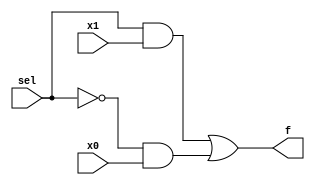

In [59]:
%%print_verilog -n mux2.v

module mux2(
  input sel, x0, x1,
  output f);
  assign f = sel & x1 | ~sel & x0;
endmodule

Em sua simulação a seguir, podemos ver que a saída `f` copia a entrada `x0` inicialmente, enquanto `sel` está embaixo. Já na segunda metade da simulação, enquanto `sel` é acionado, a saída `f` fica igual a entrada `x1`.

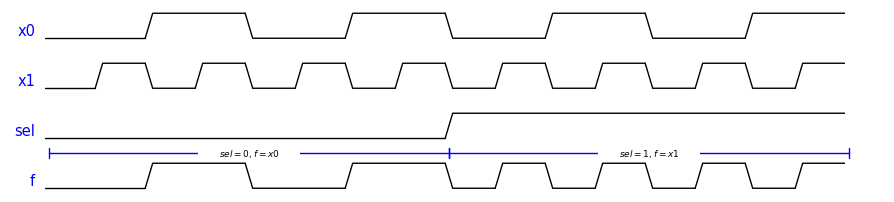

In [60]:
#@title
from schemdraw import logic
logic.TimingDiagram(
    {'signal': [
        {'name': 'x0', 'wave': '0.1.0.1.0.1.0.1.'},
        {'name': 'x1', 'wave': '0101010101010101'},
        {'name': 'sel','wave': '0.......1.......'},
        {'name': 'f',  'wave': '0.1.0.1.01010101'},
    ],
     'edge': ['[3^:0]+[3^:8] $sel=0, f=x0$',
              '[3^:8]+[3^:16] $sel=1, f=x1$',
             ]
    }, ygap=.5, grid=False)

Outra forma usada para gerar multiplexadores é usando o operador ternário da linguagem,  que possou três partes:
`condição ? verdadeiro : falso`. Ele pode ser lido na forma: se condição, então verdadeiro, senão falso. Notem que neste caso a ferramenta gráfica substitui sua representação por um trapézio, que é a forma mais comum de representar um multiplexador. Nesta forma simplificada de representar um mux as entradas são colocadas do lado maior, a saída do lado menor e o controle na lateral.

Podemos combinar multiplexadores menores para obter outro com um número maior de entradas. Eles devem ser organizados em camadas e devemos estar atentos às combinações da seleção do controle, principalmente se o número de entradas de dados não for uma potência de dois.

A animação abaixo ilustra o funcionamento com a seleção variando da entrada 0 até a entrada 3. O bit $sel_0$ seleciona o primeiro nível entre os pares $x_0,x_1$ e $x_2,x_3$. O  bit $sel_1$ irá selecionar o mux de cima (0 ou 1) ou o mux de baixo (2 ou 3). Você pode testar visualmente este e outros exemplos [seguindo este link](https://github.dev/menotti/ld/digitaljs/).

![](https://github.com/menotti/ld/blob/main/figs/mux4.gif?raw=true)

A seguir o código Verilog usando operadores ternários aninhados:

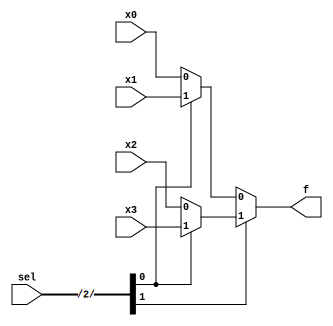

In [61]:
%%print_verilog

module mux4(
  input [1:0] sel,
  input x0, x1, x2, x3,
  output f);
  assign f = sel[1] ? (sel[0] ? x3 : x2) : (sel[0] ? x1 : x0);
endmodule

Da mesma forma, sua representação pode ser simplificada em uma única forma trapezoidal com todas as entradas juntas.

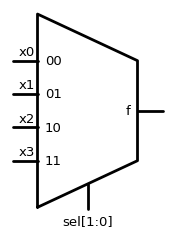

In [62]:
#@title
import schemdraw
from schemdraw import elements as elm

elm.Multiplexer(
    pins=[elm.IcPin(name='11', side='L', pin='x3'),
          elm.IcPin(name='10', side='L', pin='x2'),
          elm.IcPin(name='01', side='L', pin='x1'),
          elm.IcPin(name='00', side='L', pin='x0'),
          elm.IcPin(name='f', side='R'),
          elm.IcPin(side='B')],edgepadH=-.5).label('sel[1:0]', 'bottom', fontsize=11)

<h3>Exercício</h3>

No bloco de código abaixo, implementamos um mux de três entradas (a, b e c) de acordo com a seguinte tabela:

s0|s1|f
:-:|:-:|:-:
0|0|a
0|1|b
1|x|c

Ele foi implementado na forma funcional (`mux3f`) com operadores ternários aninhados (linha 11). Observe sua simulação na sequência do código, ela está na mesma ordem da tabela acima. Implemente uma versão estrutural (`mux3e`), a partir de dois `mux2` fornecidos. Para isso, preencha as portas correspondentes nas instancias das linhas 5 e 6. Depois execute a célula e veja se ele se comporta da mesma maneira, ou seja `tb_mux3.fe` = `tb_mux3.ff` .

VCD info: dumpfile dump.vcd opened for output.



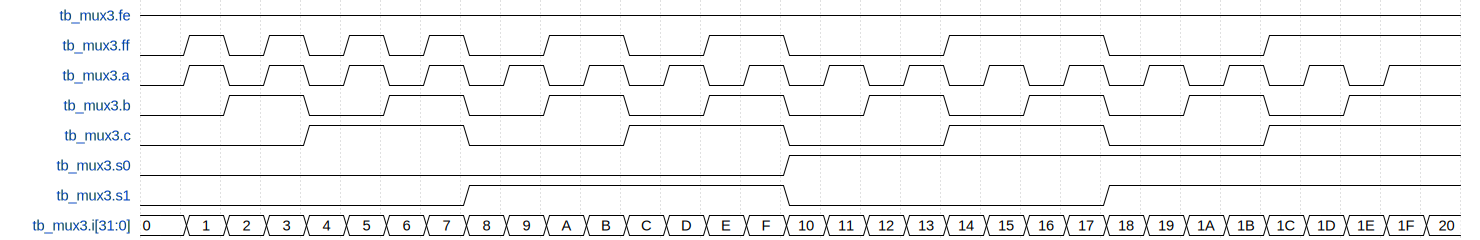

In [63]:
%%wavedrom
`include "mux2.v"

module mux3e(input a, b, c, s0, s1, output f);
  // implemente sua versão estrutural:
  mux2 interno(, , , );
  mux2 externo(, , , );
endmodule

module mux3f(input a, b, c, s0, s1, output f);
  // implementação funcional de referência:
  assign f = s0 ? c : (s1 ? b : a);
endmodule

module tb_mux3;
  reg a, b, c, s0, s1;
  wire ff, fe;
  integer i;

  mux3f dutf(a, b, c, s0, s1, ff);
  mux3e dute(a, b, c, s0, s1, fe);

  initial
  begin
    $dumpvars(1);
    for (i=0; i<32; i=i+1)
    begin
       a = i[0];
       b = i[1];
       c = i[2];
      s1 = i[3];
      s0 = i[4];
      #5;
    end
  end
endmodule

## Conversores de código

Também estão entre os circuitos combinacionais mais conhecidos os codificadores e decodificadores, chamados genericamente de conversores de código.

### Decodificador

Vamos começar com um decodificador simples, que recebe uma entrada codificada em 2 bits e a decodifica, ativando uma única saída ($y$), dependendo do código na entrada ($w$), conforme a tabela a seguir:

|$w_1$|$w_0$||$y_3$|$y_2$|$y_1$|$y_0$|
|-----|-----||-----|-----|-----|-----|
| 0 | 0 || 0 | 0 | 0 | 1 |
| 0 | 1 || 0 | 0 | 1 | 0 |
| 1 | 0 || 0 | 1 | 0 | 0 |
| 1 | 1 || 1 | 0 | 0 | 0 |

Em sua implementação mais direta, podemos extrair a expressão correspondente a cada saída $y$ a partir das entradas $w$:


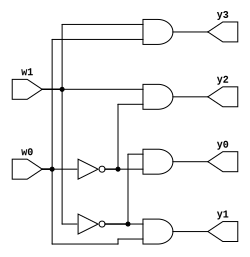

In [64]:
%%print_verilog -n dec2to4.v

module dec2to4(
  input w1, w0,
  output y3, y2, y1, y0);
  assign y0 = ~w1 & ~w0;
  assign y1 = ~w1 &  w0;
  assign y2 =  w1 & ~w0;
  assign y3 =  w1 &  w0;
endmodule

VCD info: dumpfile dump.vcd opened for output.



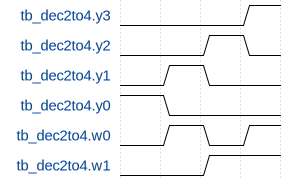

In [65]:
#@title
%%wavedrom
`include "dec2to4.v"

module tb_dec2to4;
  reg w1, w0;
  wire y3, y2, y1, y0;

  dec2to4 uut(w1, w0, y3, y2, y1, y0);

  initial begin
    $dumpvars(1);
       w1 = 0; w0 = 0;
    #5 w1 = 0; w0 = 1;
    #5 w1 = 1; w0 = 0;
    #5 w1 = 1; w0 = 1;
    #5 ;
  end
endmodule

Note que neste decodificador há sempre uma saída habilitada, pois todas as combinações de entrada são usadas. Podemos usar um sinal de habilita *(**En**able)* para que a saída só seja ativada enquanto ele estiver permitindo. Para isso, vamos usar um comando `case` que por sua vez só pode ser usado dentro de um bloco `always`. A lista que segue o início do bloco `@(W, En)` é chamada lista sensitiva e, como inclui todas as entradas, ainda gera um circuito combinacional. Usamos o operador de concatenação `{En,W}` para comparar as entradas juntas e incluimos a opção `default` que vai abrager todas as entradas em que o sinal habilita é falso. Note ainda que não precisamos usar um bloco `begin/end` no comando `always` já que ele só possui um único comando `case` que forma um bloco até o `endcase`.

A especificação comportamental é muito útil, mas devemos tomar cuidado com espeficicações incompletas que podem resultar em hardware completamente diferente do esperado. Por exemplo, experimente remover a opção `default` do `case` (linha 14) e observe o circuito gerado. A ferramente precisa introduzir elementos de memória (que veremos a seguir) para manter a saída anterior quando a entrada não é contemplada no `case`.

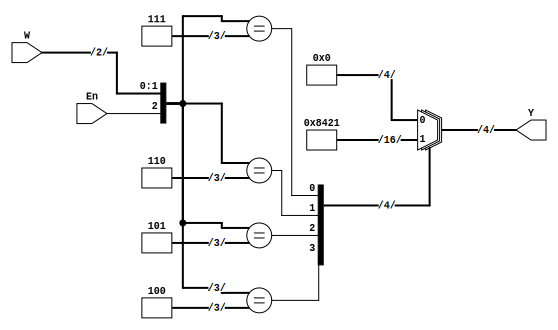

In [66]:
%%print_verilog -n dec2to4en.v

module dec2to4en (W, En, Y);
	input [1:0] W;
	input En;
	output reg [0:3] Y;

	always @(W, En)
		case ({En,W})
			3'b100: Y = 4'b1000;
			3'b101: Y = 4'b0100;
			3'b110: Y = 4'b0010;
			3'b111: Y = 4'b0001;
			default: Y = 4'b0000;
		endcase
endmodule

Para termos uma idéia melhor do circuito resultante, especificamos ele na forma funcional:

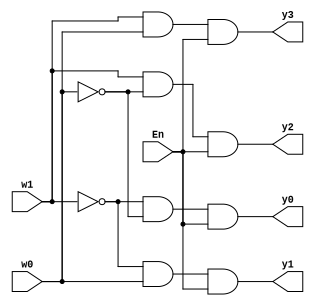

In [67]:
%%print_verilog

module dec2to4enW (
	input w1, w0, En,
	output y3, y2, y1, y0);

  assign y0 = ~w1 & ~w0 & En;
  assign y1 = ~w1 &  w0 & En;
  assign y2 =  w1 & ~w0 & En;
  assign y3 =  w1 &  w0 & En;
endmodule



 O circuito resultante parece bem mais complexo do que o anterior, mas as ferramentas de síntese são capazes de simplificá-lo internamente, tornando-o muito parecido com o anterior. A tabela a seguir demonstra o seu funcionamento:

 En| w0| w1|| y3| y2| y1| y0
:-:|:-:|:-:||:-:|:-:|:-:|:-:
 0 | x | x || 0 | 0 | 0 | 0
 1 | 0 | 0 || 0 | 0 | 0 | 1
 1 | 0 | 1 || 0 | 0 | 1 | 0
 1 | 1 | 0 || 0 | 1 | 0 | 0
 1 | 1 | 1 || 1 | 0 | 0 | 0

Vejamos sua simulação usando usando usando barramentos:

VCD info: dumpfile dump.vcd opened for output.



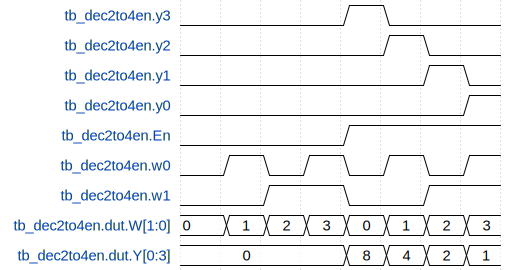

In [146]:
%%wavedrom
`include "dec2to4en.v"

module tb_dec2to4en;
	reg w1, w0, En;
	wire y3, y2, y1, y0;

  dec2to4en dut({w1,w0}, En, {y3, y2, y1, y0});

  initial begin
    $dumpvars(0);
       En = 0;
       w1 = 0; w0 = 0;
    #5 w1 = 0; w0 = 1;
    #5 w1 = 1; w0 = 0;
    #5 w1 = 1; w0 = 1;
    #5 En = 1;
       w1 = 0; w0 = 0;
    #5 w1 = 0; w0 = 1;
    #5 w1 = 1; w0 = 0;
    #5 w1 = 1; w0 = 1;
    #5;
  end
endmodule

 <h3>Codificador</h3>

 Um codificador faz exatamente o contrário de um decodificador 🤓, mas deixamos ele para depois porque há uma dificuldade adicional em seu projeto. Uma prioridade entre as entradas deve ser estabelecida, uma vez que cada uma delas aciona um código na saída.

 Na implementação a seguir estabelecemos os bits mais significativos como prioritários. Para isso, usamos o comando `casex`, capaz de fazer comparações com *don't cares*. Quando o bit mais significativo é `1`, não importa o valor dos demais e o código retornado é o mais alto. No caso seguinte ele é `0`, o bit seguinte é `1` e os demais não importam, assim fazemos sucessivamente até o último. Note que aqui também é necessário incluir um `default` para o caso de nenhum bit de entrada ser apresentado. Usamos uma saída `valid_data` para indicar que ao menos uma entrada foi apresentada, já que o caso `default` deixa a ferramenta escolher livremente a saída `code` no caso contrário.

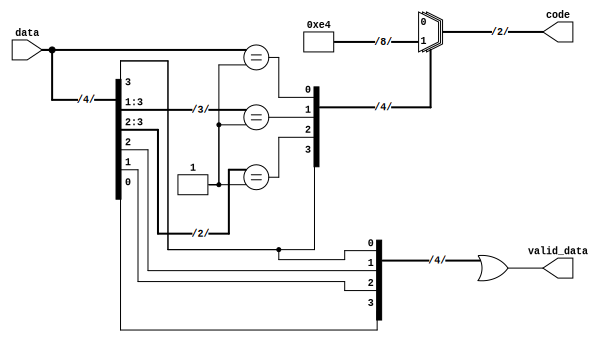

In [69]:
%%print_verilog -n priority_encoder.v

module priority_encoder (
  input [3:0] data,
  output reg [1:0] code,
  output valid_data);

  always @(data)
    casex (data)
      4'b1xxx : code=3;
      4'b01xx : code=2;
      4'b001x : code=1;
      4'b0001 : code=0;
      default : code=2'bx;
    endcase
  assign valid_data = |data; // Operador de redução
endmodule

No teste abaixo instanciamos nosso codificador e o testamos com todas as entradas possíveis para ter certeza de que a prioridade funciona. Apesar da especificação comportamental ser mais fácil de escrever e compreender, ela pode gerar circuitos inesperados caso não se especifique corretamente o hardware desejado. Além disso, a expressão para implementação funcional não é difícil de ser obtida, veja na linha 11 do nosso teste. Note que a única diferença nas saídas é o X para a entrada 0.

VCD info: dumpfile dump.vcd opened for output.



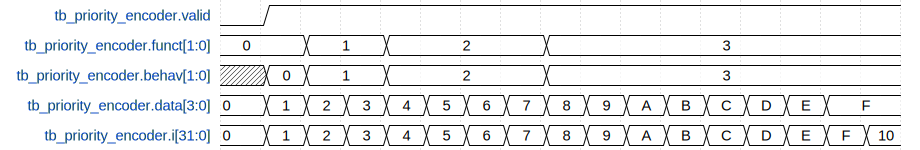

In [70]:
%%wavedrom
`include "priority_encoder.v"

module tb_priority_encoder;
  reg [3:0] data;
  wire [1:0] behav, funct;
  wire valid;
  integer i;

  priority_encoder dut(data, behav, valid);
  assign funct = {data[3] | data[2], ~data[3] & ~data[2] & data[1] | data[3]};

  initial
  begin
    $dumpvars(1);
    for (i=0; i<16; i=i+1)
    begin
      data = i; #5;
    end
  end
endmodule

Abaixo um exemplo com uma implementação funcional de um codificador de 8 bits para 3:

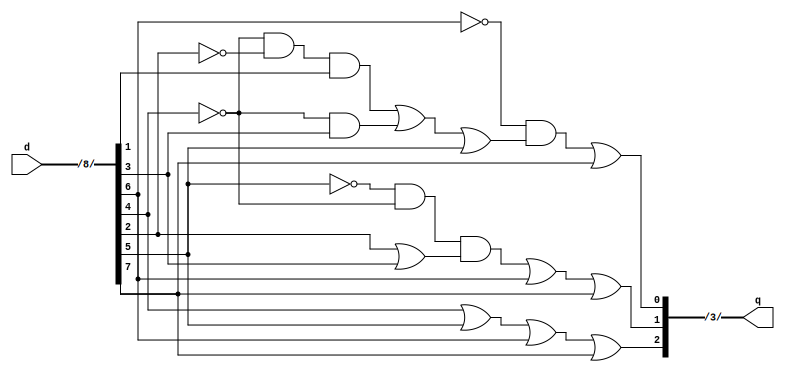

In [71]:
%%print_verilog
module encoder (
		input  [7:0] d, // definir as entradas
    output [2:0] q);  // definir as saidas

    assign q[0] = (~d[6] & (~d[4] & ~d[2] & d[1] | ~d[4] & d[3] | d[5])| d[7]);
    assign q[1] = (~d[5] & ~d[4] & (d[2] | d[3]) | d[6] |d[7]);
    assign q[2] = (d[4] | d[5] | d[6] | d[7]);
endmodule

Abaixo a simulação do circuito acima:

In [72]:
#@title

head = """
module encoder(
		input  [7:0]d, // definir as entradas
    output [2:0] q  // definir as saidas
    );
assign q[0]=(~d[6] & (~d[4] & ~d[2] & d[1] | ~d[4] & d[3] | d[5])| d[7]);
assign q[1]=(~d[5] & ~d[4] & (d[2] | d[3]) | d[6] |d[7]);
assign q[2]=(d[4] | d[5] | d[6] | d[7]);
endmodule




module logic_testbench();  // Esta parte do codigo é para gerar os 16 valores
reg [7:0] A;
wire [2:0] z;
integer k;
	encoder p(A,z);
	initial begin
		$display("A 76543210 | z ");
		$monitor("  %8b | %d", A,  z);
"""


tail ="""
    #1;
		$finish;
	end

endmodule
"""
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact
import subprocess

def geraverilog(A7,A6,A5,A4,A3,A2,A1,A0):
    # Função que recebe os valores dos sliders e faz algo com eles
    clear_output()  # Limpa a saída anterior
    # Adicione aqui a lógica para gerar o Verilog
    f = open("test_comp.v","w")
    f.write(head)
    to_string = lambda value: "1" if value else "0"
    s = "A[7] = "+to_string(A7)+"; "
    s += "A[6] = "+to_string(A6)+"; "
    s += "A[5] = "+to_string(A5)+"; "
    s += "A[4] = "+to_string(A4)+";"
    s += "A[3] = "+to_string(A3)+"; "
    s += "A[2] = "+to_string(A2)+"; "
    s += "A[1] = "+to_string(A1)+"; "
    s += "A[0] = "+to_string(A0)+";\n"
    f.write(s)
    f.write(tail)
    f.close()
    command = f"iverilog test_comp.v"
    output = subprocess.check_output(command, shell=True)
    command = f"./a.out"
    output = subprocess.check_output(command, shell=True)
    output_lines = output.decode('utf-8').split('\n')
    for line in output_lines:
      print(line)

# Criação dos sliders
a7 = widgets.Checkbox(description='A7:', value=False)
a6 = widgets.Checkbox(description='A6:', value=False)
a5 = widgets.Checkbox(description='A5:', value=False)
a4 = widgets.Checkbox(description='A4:', value=False)
a3 = widgets.Checkbox(description='A3:', value=False)
a2 = widgets.Checkbox(description='A2:', value=False)
a1 = widgets.Checkbox(description='A1:', value=False)
a0 = widgets.Checkbox(description='A0:', value=False)

# Vincula a função geraverilog ao interact
dummy = interact(geraverilog, A7=a7,A6=a6,A5=a5,A4=a4,A3=a3,A2=a2,A1=a1,A0=a0)



interactive(children=(Checkbox(value=False, description='A7:'), Checkbox(value=False, description='A6:'), Chec…

Codificadores e decodificadores são os conversores de código mais comuns, mas existem muitos outros possíveis de serem construidos de acordo com as necessidades de cada sistema digital. Você certamente já viu um equipamento (antigo?) com um display de sete segmentos como o da figura a seguir (execute a célula abaixo e deslize o comando para ver os digitos todos):

In [73]:
#@title
import schemdraw
import ipywidgets as widgets
from ipywidgets import interact
from schemdraw import elements as elm

def geradig(A):
  h=hex(A)[2]
  print('Hexadecimal:', h)
  display(elm.SevenSegment(segcolor='green', tilt=0, digit=h))

slider_A = widgets.IntSlider(min=0, max=15, description='Decimal:')
dummy = interact(geradig, A=slider_A)

interactive(children=(IntSlider(value=0, description='Decimal:', max=15), Output()), _dom_classes=('widget-int…

Cada dígito deste componente possui um segmento de LED independente que pode estar ou não aceso de acordo com um código de entrada. Mais uma vez vamos usar o comando `case`, pois facilita a construção do circuito, uma vez que teríamos que calcular as expressões para cada um dos sete segmentos separadamente. A implementação a seguir só funciona para os dígitos de 0 a 9, mas você pode completá-la para funcionar com hexadecimal (adicionando A, b, C, d, E, F). Depois, é só executar as células abaixo para gravar o arquivo e simular novamente.

In [74]:
%%verilog -n disp7seg.v
module disp7seg (
  input [3:0] dig,
  output reg [6:0] segs);

  always@(dig)
    case (dig)   // abcdefg
      0 : segs = 7'b1111110;
      1 : segs = 7'b0110000;
      2 : segs = 7'b1101101;
      3 : segs = 7'b1111001;
      4 : segs = 7'b0110011;
      5 : segs = 7'b1011011;
      6 : segs = 7'b1011111;
      7 : segs = 7'b1110000;
      8 : segs = 7'b1111111;
      9 : segs = 7'b1111011;
      // complete para os dígito de A..F
      default : segs = 7'b0000000;
    endcase
endmodule

VCD info: dumpfile dump.vcd opened for output.



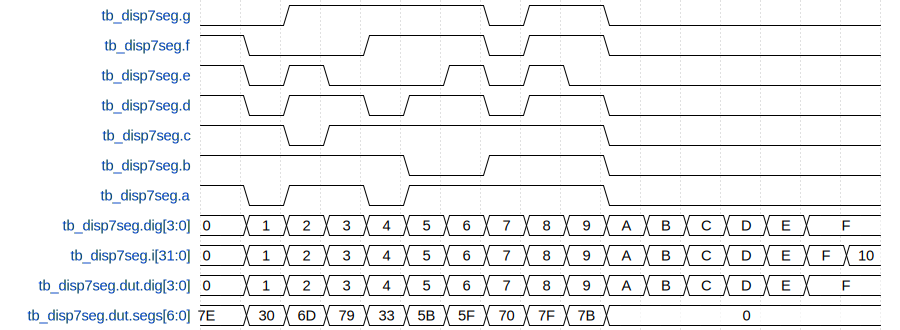

In [75]:
%%wavedrom
`include "disp7seg.v"

module tb_disp7seg;
  reg [3:0] dig;
  wire a,b,c,d,e,f,g;
  integer i;

  disp7seg dut(dig, {a,b,c,d,e,f,g});

  initial
  begin
    $dumpvars(0);
    for (i=0; i<16; i=i+1)
    begin
      dig = i; #5;
    end
  end
endmodule

O código abaixo executa o decodificador em Verilog e mostra uma animação com caracteres ASCII em Verilog que emula a saída do display de 7 segmentos. Ela só foi emplementada até o dígito 9, algumas células atrás, mas você pode completar a implementação e executar novamente para ver se funciona.

In [76]:
#@title
head = """`include "disp7seg.v"

module logic_testbench();
reg [3:0] A;
wire [6:0] D;
integer k;
	disp7seg M(A,D);
	initial begin
		$display("A3A2A1A0 | abcdefg");
		$monitor("%b %b %b %b  | %7b", A[3],A[2],A[1],A[0], D);
"""


tail ="""
    #1;
    if (D[6]== 1'b1) $display(" _ ");
    if (D[1]== 1'b1 && D[5]== 1'b1 && D[0]== 1'b1) $display("|_|");
    else if (D[1]== 1'b1 && D[5]== 1'b1) $display("| |");
    else if (D[1]== 1'b1 && D[0]== 1'b1) $display("|_");
    else if (D[5]== 1'b1 && D[0]== 1'b1) $display(" _|");
    else if (D[5]== 1'b1 ) $display("  |");
    else if (D[1]== 1'b1 ) $display("|");
    else if (D[0]== 1'b1 ) $display(" _ ");
    if (D[2]== 1'b1 && D[4]== 1'b1 && D[3]== 1'b1) $display("|_|");
    else if (D[2]== 1'b1 && D[4]== 1'b1) $display("| |");
    else if (D[2]== 1'b1 && D[3]== 1'b1) $display("|_");
    else if (D[4]== 1'b1 && D[3]== 1'b1) $display(" _|");
    else if (D[4]== 1'b1 ) $display("  |");
    else if (D[2]== 1'b1 ) $display("|");
    else if (D[3]== 1'b1 ) $display(" _ ");

		$finish;
	end

endmodule
"""
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact
import subprocess

def geraverilog(A):
    # Função que recebe os valores dos sliders e faz algo com eles
    clear_output()  # Limpa a saída anterior
    # Adicione aqui a lógica para gerar o Verilog
    h=hex(A)[2]
    print('Hexadecimal:', h)
    f = open("test_comp.v","w")
    f.write(head)
    s = "A = "+str(A)+"; \n"
    f.write(s)
    f.write(tail)
    f.close()
    command = f"iverilog test_comp.v"
    output = subprocess.check_output(command, shell=True)
    command = f"./a.out"
    output = subprocess.check_output(command, shell=True)
    output_lines = output.decode('utf-8').split('\n')
    for line in output_lines:
      print(line)
    e = elm.SevenSegment(segcolor='green', digit=h, tilt=0)
    display(e)

# Criação dos sliders
slider_A = widgets.IntSlider(min=0, max=15, description='A')

# Vincula a função geraverilog ao interact
dummy = interact(geraverilog, A=slider_A)




interactive(children=(IntSlider(value=0, description='A', max=15), Output()), _dom_classes=('widget-interact',…



## Comparadores

Iremos fazer a especificação do módulo básico com tabela verdade, minimizar com mapas de Karnaugh e Don't Care.

* Comparador de n bits Esquerda para Direita
* Comparador de n bits Direita para Esquerda
* Comparador de n bits em Àrvore



## [De]multiplexadores

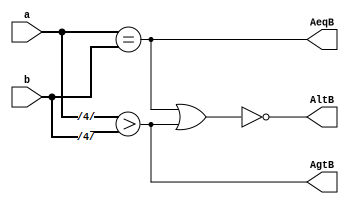

In [77]:
%%print_verilog

module comparador(
    input [3:0] a, b,
    output AeqB, AltB, AgtB);

    assign AeqB = a == b;
    assign AgtB = a > b;
    assign AltB = AeqB ~| AgtB; // a < b;
endmodule

## Unidade Lógica e Aritmética

Para termos uma noção de como a linguagem Verilog pode ser produtiva na especificação de hardware, vamos projetar uma Unidade Lógica e Aritmética (ULA) compatível com o circuito 74F381, bastante conhecido. Ela tem entradas e saída de 4 bits e 3 operações, de acordo com a tabela a seguir:

Operação|Op[2:0]|Saída
:-----|:---:|:---:
Clear | 000|0000
B-A   | 001|B - A
A-B   | 010|A - B
ADD   | 011|A + B
XOR   | 100|A ^ B
OR    | 101|A \| B
AND   | 110|A & B
Preset| 111|1111

In [78]:
%%verilog -n alu.v
// 74F381 ALU
module alu (
  input [2:0] op,
  input [3:0] A, B,
  output reg [3:0] S);

  always @(op or A or B)
    case (op)
      0: S = 4'b0000;
      1: S = B - A;
      2: S = A - B;
      3: S = A + B;
      4: S = A ^ B;
      5: S = A | B;
      6: S = A & B;
      7: S = 4'b1111;
  endcase
endmodule

Vamos usar novamente um arquivo de vetor de testes, mas agora em hexadecimal. Nele temos um único caso de teste para cada operação da nossa ULA e a ordem das variáveis no arquivo é a seguinte: `A_op_B_S`:

In [79]:
%%writefile values.tv
x_0_x_0
2_1_7_5
5_2_2_3
2_3_3_5
f_4_a_5
4_5_1_5
a_6_7_2
x_7_x_f

Overwriting values.tv


Vejamos algumas particularidades deste novo estilo de ***test bench***:
  1. Nosso arranjo de vetores foi declarado com mais linhas do que o arquivo (linha 9);
  1. Apesar de se tratar de um circuito combinacional, temos um relógio (`clk`) para sequenciar os testes, que gera uma onda quadrada (linha 22);
  1. A cada subida deste `clk` alimentamos as entradas do circuito e a saída esperada;
  1. Na descida do `clk` verificamos se a saída obtida confere com a esperada (linha 35);
  1. Incrementamos a variável de iteração `i` dos testes, verificamos se chegamos ao fim, ou seja, se lemos um valor indefinido (`x`) e finalizamos o teste (linhas 37-39).

Observe sua simulação realizando todas as operações. Você é capaz de interpretar os valores informados e obtidos?

VCD info: dumpfile dump.vcd opened for output.
x_xxx_x_x
x_000_x_0
2_001_7_5
5_010_2_3
2_011_3_5
f_100_a_5
4_101_1_5
a_110_7_2
x_111_x_f



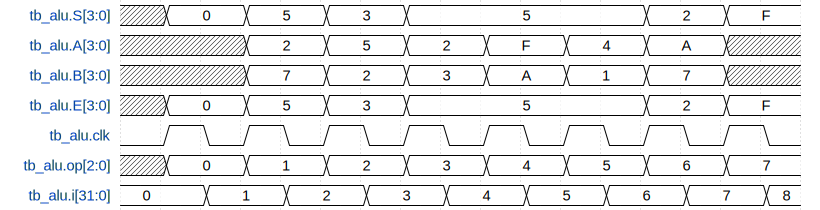

In [80]:
#@title
%%wavedrom
`include "alu.v"

module tb_alu;
  reg [2:0] op;
  reg [3:0] A, B, E;
  wire [3:0] S;
  reg [15:0] values [0:69];
  reg clk;
  integer i;

  alu dut(op, A, B, S);

  initial
  begin
    $monitor("%h_%3b_%h_%h", A, op, B, S);
    $dumpvars(1);
    $readmemh("values.tv", values);
    i = 0;
    clk = 1'b0;
    forever #5 clk = ~clk;
  end

  always@(posedge clk)
  begin
     A = values[i][15:12];
    op = values[i][10: 8];
     B = values[i][ 7: 4];
     E = values[i][ 3: 0];
  end

  always@(negedge clk)
  begin
    if (E !== S)
      $display("Erro no vetor %0d, operação %3b, esperado %b, obtido %b!", i, op, S, E);
    i = i + 1;
    if (values[i][0]===1'bx)
      $finish;
  end
endmodule

Experimente colocar novos casos de teste no arquivo, salve-o e execute novamente a simulação para ver se compreendeu.

# Elementos de memória

Até agora, todos os circuitos que abordamos podem ser chamados de combinacionais. Isso porque suas saídas só dependem da combinação das entradas. Para dizer de outra forma, sempre que apresentamos a eles uma mesma entrada, ele irá resultar nas mesmas saídas.

A partir de agora vamos introduzir elementos de memória capazes de armazenar um estado interno no circuito. Isso faz com que ele não dependa apenas das entradas, mas também da ordem em que foram modificadas ao longo do tempo. Isso é fundamental para os circuitos digitais, já que há cálculos complexos que precisam ser divididos em partes para serem realizados.

Os circuitos que contém estes elementos são chamados **circuitos sequenciais**, pois suas saídas dependem da sequência das entradas. As simulações interativas costumam ajudar muito na compreensão destes, então recomendamos o uso de simuladores como o [DigitalJS](https://github.com/tilk/digitaljs) que está [disponível online](https://digitaljs.tilk.eu) e também como uma [extensão do VS Code](https://marketplace.visualstudio.com/items?itemName=yuyichao.digitaljs). Alguns exemplos interessantes de serem simulados podem ajudar na compreensão e estão disponíveis [neste link](https://github.dev/menotti/ld/digitaljs/).



## Latch

O elemento de memória mais básico de ser contruído é o _latch_. Observe a tabela a seguir e o circuito que a implementa:

$S$|$R$|$Q$|$\overline{Q}$
-|-|:-:|:-:
0|0|$Q$(t-1)|$\overline{Q}$(t-1)
0|1|0|1
1|0|1|0
1|1|0|0



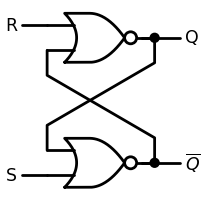

In [81]:
#@title
import schemdraw
from schemdraw import logic

with schemdraw.Drawing() as d:
    d += (g1 := logic.Nor())
    d.move_from(g1.in1, dy=-2.5)
    d += (g2 := logic.Nor().anchor('in1'))
    d += (g1out := logic.Line().right(.25).at(g1.out))
    d += logic.Wire('N', k=.5).at(g2.in1).to(g1out.end).dot()
    d += (g2out := logic.Line().right(.25).at(g2.out))
    d += logic.Wire('N', k=.5).at(g1.in2).to(g2out.end).dot()
    d += logic.Line().at(g1.in1).left(.5).label('R', 'left')
    d += logic.Line().at(g2.in2).left(.5).label('S', 'left')
    d += logic.Line().at(g1.out).right(.75).label('Q', 'right')
    d += logic.Line().at(g2.out).right(.75).label('$\overline{Q}$', 'right')


Neste circuito, usamos a entrada $S$ para armazenar 1 (*set*) e a entrada $R$ para armazenar 0 (*reset*), conforme as linhas centrais da tabela. A porta $Q$ apresenta o valor armazenado e a porta $\overline{Q}$ o seu inverso. Quando nenhuma das entradas é acionada, os valores de $Q$ e $\overline{Q}$ são mantidos. Quando as duas entradas são acionadas ao mesmo tempo, temos um estado inconsistente e as saídas se tornam ambas zero. Se as removemos ao mesmo tempo, temos uma condição de corrida que vai resultar em apenas uma das saídas zero. Observe na animação abaixo que quando $S$ e $R$ não estão ativados $Q$ guarda o último deles que foi acionado.

![](https://github.com/menotti/ld/blob/main/figs/latch.gif?raw=true)

Apesar de ser capaz de armazenar um bit, o *latch* acima não é muito útil. Vamos adicionar nele uma porta chamada ***enable***, para que possamos proteger ele de alterações quando esta porta não estiver ativa. Para isso, basta fazer um AND lógico desta entrada com as outras duas, conforme o circuito a seguir.  

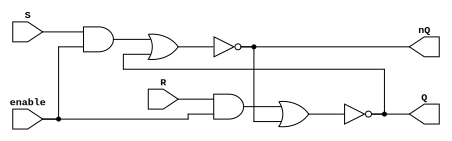

In [82]:
%%print_verilog -n latchSR.v

module latchSR(input enable, S, R, output Q, nQ);
  and (cS, S, enable);
  and (cR, R, enable);
  nor (Q, cR, nQ);
  nor (nQ, cS, Q);
endmodule

Observe na simulação a seguir que $S$ e $R$ só têm efeito quando o sinal ***enable*** está ativo:

VCD info: dumpfile dump.vcd opened for output.



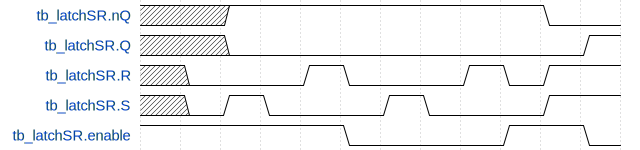

In [129]:
#@title
%%wavedrom
`include "latchSR.v"

module tb_latchSR;

  reg S, R, enable;
  wire Q, nQ;

  latchSR dut(S, R, enable, Q, nQ);

  initial
  begin
    $dumpvars(1);
    enable = 1;
    #5 S = 0; R = 0;
    #5 S = 1; R = 0;
    #5 S = 0; R = 0;
    #5 S = 0; R = 1;
    #5 S = 0; R = 0;
    enable = 0;
    #5 S = 1; R = 0;
    #5 S = 0; R = 0;
    #5 S = 0; R = 1;
    #5 S = 0; R = 0;
    enable = 1;
    #5 S = 1; R = 1;
    #5;
    enable = 0;
  end
endmodule

Isso não impede de fazermos $S$ e $R$ ativos ao mesmo tempo, levando a um estado inconsistente em que $Q$ = $\overline{Q}$ = $0$. Veja esta condição no final da simulação, o estado seguinte não pode ser previsto, pois acontece uma condição de corrida quando o ***enable*** é desligado.

Vamos aprimorar um pouco mais o nosso *latch*, incluindo uma porta $D$, fazendo ela acionar $S$ e sua negação acionar $R$. Assim, elas sempre terão valores contrários, mas estaremos sempre fazendo ***set*** ou ***reset***. Isso não será um problema, já que podemos bloquear as ações desabilitando o ***enable***.

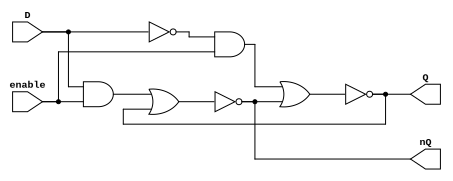

In [84]:
%%print_verilog

module latchD(input enable, D, output Q, nQ);
  and (cS, D, enable);
  and (cR, ~D, enable);
  nor (Q, cR, nQ);
  nor (nQ, cS, Q);
endmodule

Podemos também especificar um *latch* simples usando Verilog comportamental. O símbolo usado no bloco gerado pela ferramenta indica que a entrada $D$ é sensível ao nível de ***enable***.

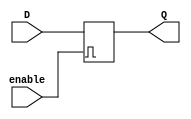

In [131]:
%%print_verilog -n latchD.v

module latchD(input enable, D, output reg Q);
  always @(D or enable)
    if (enable)
      Q = D;
endmodule

Observe sua simulação a seguir:

VCD info: dumpfile dump.vcd opened for output.



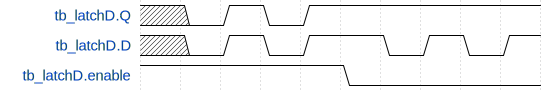

In [133]:
#@title
%%wavedrom
`include "latchD.v"

module tb_latchD;

  reg D, enable;
  wire Q;

  latchD dut(enable, D, Q);

  initial
  begin
    $dumpvars(1);
    enable = 1;
    #5 D = 0;
    #5 D = 1;
    #5 D = 0;
    #5 D = 1;
    #5;
    enable = 0;
    #5 D = 0;
    #5 D = 1;
    #5 D = 0;
    #5 D = 1;
  end
endmodule


## Flip-flop

Apesar dos *latches* serem capazes de armazenar valores em um circuito, eles podem causar condições de corrida indesejadas. Nos circuitos sequenciais, em geral, são usados *flip-flops*, circuitos sensíveis à borda ao invés do nível. Eles podem ser obtidos por dois *latches* em série, com os sinais ***enable*** invertidos. Eles são chamados mestre-escravo, pois quando o primeiro *latch* está habilitado (mestre) o segundo está desabilitado (escravo) e vice-versa. A combinação da figura a seguir torna o circuito sensível à borda de descida, pois neste exato momento o valor do mestre é transferido para o escravo.

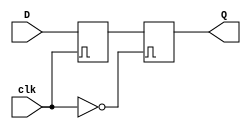

In [87]:
%%print_verilog
`include "latchD.v"

module FFD(input D, clk, output Q);
  latchD master(clk, D, iQ);
  latchD slave(~clk, iQ, Q);
endmodule

A forma mais comum de especificar circuitos sequenciais em Verilog comportamental é fazendo as atribuições de valores dentro de blocos `always@(posedge clk)`. Note que a entrada $D$ não aparece na lista sensitiva do comando e que um símbolo > foi adicionado à porta ***clk***, indicando que o circuito é sensível à borda de subida (posedge) ou descida (negedge).  

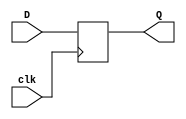

In [88]:
%%print_verilog -n FFD.v

module FFD(input clk, D, output reg Q);
  always@(posedge clk)
    Q = D;
endmodule

Veja sua simulação a seguir. Nós mudamos as entradas propositalmente nas bordas de descida, para que fique claro que ela só propaga para a saída na borda de subida. Mudar a entrada junto com a borda de subida pode tornar a simulação ambígua, mas é esperado que a entrada considerada seja a anterior.

VCD info: dumpfile dump.vcd opened for output.



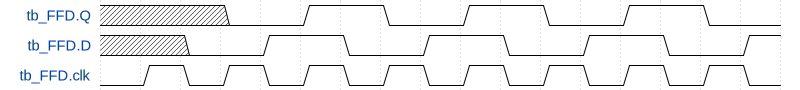

In [89]:
%%wavedrom
`include "FFD.v"

module tb_FFD;

  reg D, clk;
  wire Q;

  FFD dut(clk, D, Q);

  always
  begin
     clk = 0; #5 clk = 1; #5;
  end

  initial
  begin
    $dumpvars(1);
    #10 D = 0;
    #10 D = 1;
    #10 D = 0;
    #10 D = 1;
    #10 D = 0;
    #10 D = 1;
    #10 D = 0;
    #10 D = 1;
    $finish;
  end
endmodule



# Circuitos sequênciais típicos

Os flip-flops são a base de construção dos circuitos sequenciais e, em geral, uma especificação Verilog que gera *latches* é indesejada. Vejamos agora alguns circuitos sequências típicos e suas aplicações.



## Registradores

Se um flip-flop pode armazenar um bit, um conjunto deles pode armazenar um byte, palavras, etc. Vejamos um implementação genérica, que pode ser instanciada com vários bits. Nesta especificação usamos um reset assincrono (`rst`), mas você pode torná-lo síncrono removendo ele da linha 8 e deixando apenas `posedge clk` (observe a diferença no circuito).


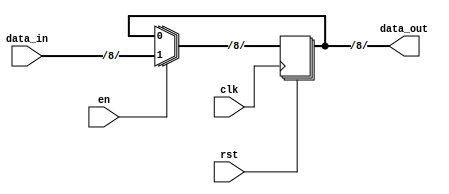

In [134]:
%%print_verilog -n regn.v

module regn #(parameter width = 8) (
  input clk, rst, en,
  input [width-1:0] data_in,
  output reg [width-1:0] data_out);

  always@(posedge clk or posedge rst)
    if (rst)
      data_out = 0;
    else
      if (en)
        data_out = data_in;
endmodule

Em sua simulação notamos que ele tem um valor indefinido inicialmente, depois é resetado na borda de subida e finalmente carregado com um valor de entrada apenas quando o sinal `en` está ativo no momento da subida do relógio. Experimente a simulação com o `rst` assíncrono e depois síncrono.

VCD info: dumpfile dump.vcd opened for output.



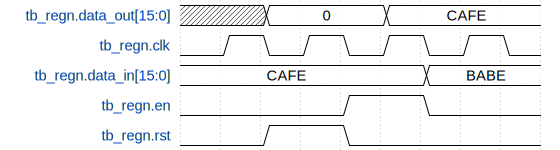

In [91]:
%%wavedrom
`include "regn.v"

module tb_regn;
  reg clk, rst, en;
  reg [15:0] data_in;
  wire [15:0] data_out;

  regn #(16) r16(clk, rst, en, data_in, data_out);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    clk = 0; en = 0; rst = 0; data_in = 16'hcafe;
    #10 rst = 1;
    #10 rst = 0; en = 1;
    #10 en = 0; data_in = 16'hbabe;
    #10 $finish;
  end

endmodule

Sem dúvidas nosso registrador com largura variável, reset síncrono ou assíncrono e sinal de habilita é muito útil, mas a linguagem Verilog tem uma forma de declarar exatamente isso com uma palavra chave `reg` e seu contexto adequado.

O módulo a seguir é capaz de gerar a sequência de Fibonacci com apenas dois registradores (`a` e `b`). Na maioria das linguagens de programação nós precisariamos de três variáveis para fazer isso, já que as instruções são executadas sequencialmente. Em Verilog, usando o operador de atribuição `<=` nas linhas 16 e 17, dizemos que os dois registradores são atualizados exatamente no mesmo instante, ou seja, na borda de subida do `clk`.

O operador de atribuição `=>` é chamado não-bloqueante por tornar as atribuições totalmente independentes entre si e, portanto, podem estar em qualquer ordem no código. O operador `=` é a versão bloqueante, ou seja, ela faz com que as atribuições posteriores dependam das anteriores quando usam a mesma variável. No nosso exemplo abaixo, a linha 17 usaria a nova versão de `a` que foi atribuida na linha anterior, ou seja, o próprio `b`, tornando o código ineficaz.

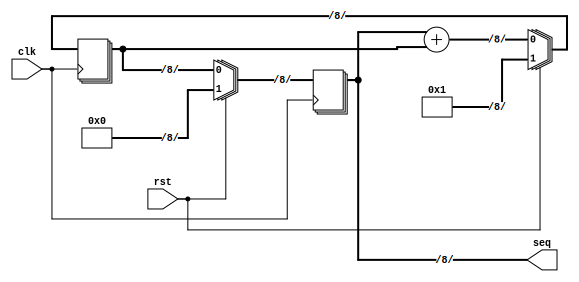

In [92]:
%%print_verilog -n fibo.v
module fibo(
  input clk, rst,
  output [7:0] seq);

  reg [7:0] a, b;

  always@(posedge clk)
    if (rst)
    begin
      a <= 0;
      b <= 1;
    end
    else
    begin
      a <= b; // experimente trocar por =
      b <= a + b; // experimente trocar por =
    end
  assign seq = a;
endmodule

Experimente alternar entre atribuições bloqueantes (`<=`) e não-bloqueantes (`=`), repita a geração do circuito acima e sua simulação abaixo para ver o seu resultado. Mude o parâmetro da função `$dumpvars(0)` para mostrar os valores internos de `a` e `b`.

<h2>Exercício</h2>

Tente implementar o mesmo circuito instanciando dois registradores do modelo [fornecido anteriormente](https://colab.research.google.com/drive/19Hx2VVszGURzVRCw6IQqC9SXse4hBxse?authuser=1#scrollTo=r_wAVKqVoTsV). Use o mesmo teste a seguir para comprovar o seu funcionamento.

VCD info: dumpfile dump.vcd opened for output.
  x
  0
  1
  2
  3
  5
  8
 13
 21
 34
 55
 89
144
233



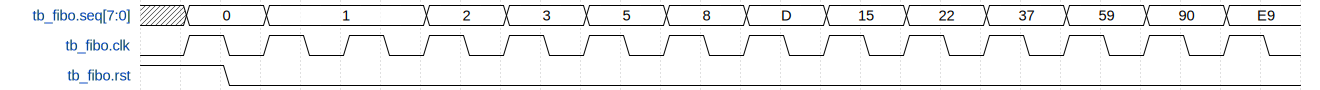

In [93]:
%%wavedrom
`include "fibo.v"

module tb_fibo;
  reg clk, rst;
  wire [7:0] seq;

  fibo uut(clk, rst, seq);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    $monitor("%d", seq);
    clk = 0; rst = 1;
    #10 rst = 0;
    #130 $finish;
  end
endmodule

Se você teve dificuldades em entender o exemplo anterior, vamos usar um mais simples primeiro. O módulo abaixo possui uma entrada `i`, um registrador intermediário `m` e um registrador na saída `o`. Tendo em conta que os registadores são atualizados sempre no mesmo instante, na subida do `clk`, experimente as mudanças a seguir no código, primeiro individualmente e depois combinações delas:
  * Troque `<=` por `=`;
  * Remova o `m` da saída;
  * Remova o `+1` da atribuição;
  * Troque a ordem das atribuições;

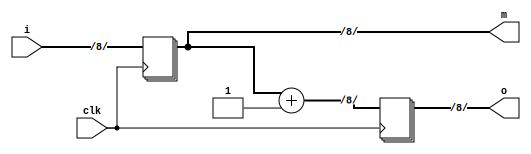

In [94]:
%%print_verilog
module nao_bloqueante(
  input clk,
  input [7:0] i,
  output [7:0] m,
  output reg[7:0] o);
  reg [7:0] m;
  always@(posedge clk)
  begin
    m <= i;
    o <= m+1;
  end
endmodule

## Contadores

Contadores são bastante úteis nos circuitos digitais para contabilizar eventos e controlar temporizações. Eles podem ser gerados a partir de flip-flops, mas para facilitar vamos especificá-los diretamente na forma comportamental.

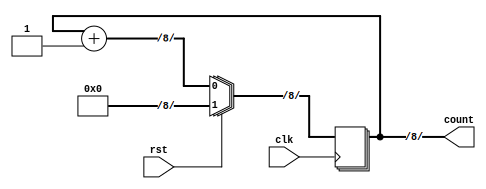

In [95]:
%%print_verilog -n counter.v
module counter(
    input clk, rst,
    output reg [7:0] count);

    always@(posedge clk)
      if (rst)
        count = 'b0;
      else
        count = count + 1;
endmodule

VCD info: dumpfile dump.vcd opened for output.



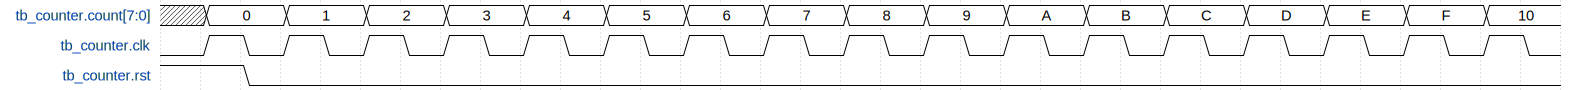

In [96]:
%%wavedrom
`include "counter.v"

module tb_counter;
  reg clk, rst;
  wire [7:0] count;

  counter dut(clk, rst, count);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    clk = 0; rst = 1;
    #10 rst = 0;
    #160 $finish;
  end
endmodule

Agora vamos construir um contador mais sofisticado, de largura parametrizável, capaz de carregar um valor inicial informado e que possa incrementar e decrementar. A porta de reset se chama `arst_n`, o prefixo **a** indica que é assíncrona e o sufixo **n** que é *active low*. Além da contagem, ele também possuiu uma saída que indica quando o limite da contagem foi atingido e o contador dará a volta (`wraparound`).

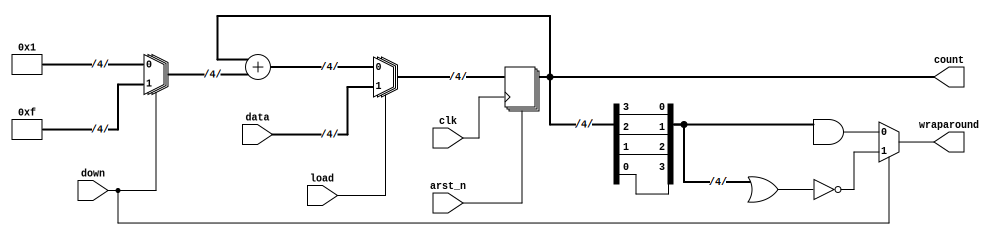

In [97]:
%%print_verilog -n updown_load_counter.v
module updown_load_counter
  #(parameter N = 4)(
  input clk, arst_n,
  input [N-1:0] data,
  input load, down,
  output reg [N-1:0] count,
  output wraparound);

  always @(posedge clk or negedge arst_n)
    if (!arst_n)
      count <= 'b0;
    else
      if (load)
        count <= data;
      else
        count <= count + (down ? -1 : +1);

  assign wraparound = down ? ~|count : &count;
endmodule

## Deslocadores

Fazer o deslocamento de bits é uma operação muito comum em circuitos digitais. Existem vários protocolos de comunicação que transmitem dados serialmente e, portanto, estes precisam ser enfileirados bit a bit. Já quando representamos números, deslocar o valor um bit para a esquerda significa multiplicá-lo por dois. Da mesma forma, deslocar o valor um bit para a direita significa dividi-lo por dois.

Vejamos a seguir um módulo que recebe os bits de um _nibble_ serialmente e permite sua leitura tanto serialmente quanto em paralelo ao final. Note que ele é carregado a partir do MSB e lido (serialmente) a partir do LSB.



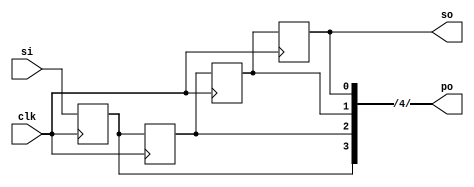

In [98]:
%%print_verilog -n shift_nibble.v
`include "FFD.v"

module shift_nibble(
    input clk, si,    // entrada serial
    output so,        // saída serial
    output [3:0] po); // saída paralela

    FFD b3(clk,    si, po[3]);
    FFD b2(clk, po[3], po[2]);
    FFD b1(clk, po[2], po[1]);
    FFD b0(clk, po[1], po[0]);

    assign so = po[0];
endmodule

Observe sua simulação:

VCD info: dumpfile dump.vcd opened for output.
s      s
i  po  o
1 xxxx x
1 1xxx x
1 11xx x
1 111x x
1 1111 1
0 1111 1
0 0111 1
0 0011 1
0 0001 1
0 0000 0



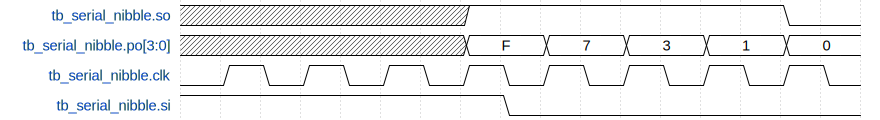

In [99]:
%%wavedrom
`include "shift_nibble.v"

module tb_serial_nibble;
  reg clk, si;
  wire so;
  wire [3:0] po;

  shift_nibble dut(clk, si, so, po);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    $display("s      s");
    $display("i  po  o");
    $monitor("%0b %4b %0b", si, po, so);
    clk = 0; si = 1;
    #40 si = 0;
    #40 $finish;
  end
endmodule

Vamos agora usar Verilog comportamental para especificar um deslocador mais versátil. Ele permite a carga de um valor arbitrário a partir da porta `i_data` e o sinal de controle `load`, o que pode substituir a necessidade de um reset. O circuito possui uma entrada serial `si` e é capaz de deslocar para a direita e para a esquerda.

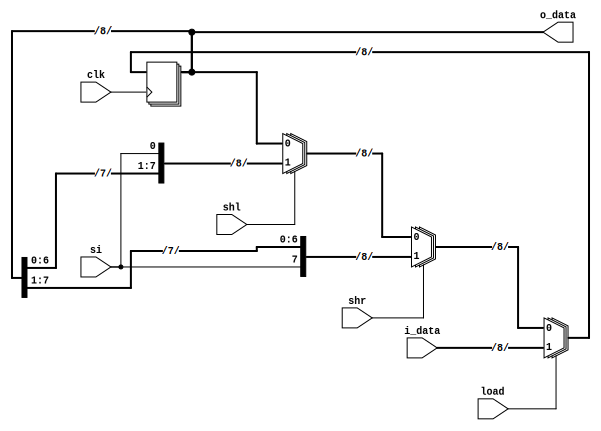

In [100]:
%%print_verilog -n shifter.v
module shifter #(parameter N = 8)(
    input clk, load, shl, shr,
    input si, input [N-1:0] i_data,
    output reg [N-1:0] o_data);

    always@(posedge clk)
      if (load)
        o_data <= i_data;
      else
        if (shr)
          o_data <= {si, o_data[N-1:1]};
        else
          if (shl)
            o_data <= {o_data, si};
endmodule

VCD info: dumpfile dump.vcd opened for output.
xxxxxxxxxxxxxxxx
load...
1100101011111110
>>
1110010101111111
1111001010111111
1111100101011111
1111110010101111
<<
1111100101011111
1111001010111111
1110010101111111
1100101011111110



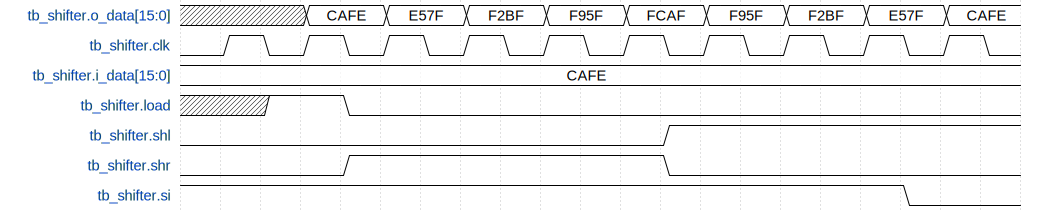

In [101]:
%%wavedrom
`include "shifter.v"

module tb_shifter;
    reg clk, load, shl, shr, si;
    reg [15:0] i_data;
    wire [15:0] o_data;

    shifter #(16) dut(clk, load, shl, shr, si, i_data, o_data);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    $monitor("%8b", o_data);
    clk = 0; si = 1; shl = 0; shr = 0; i_data = 16'hCAFE;
    #10 load = 1;
    $display("load...");
    #10 load = 0; shr = 1;
    $display(">>");
    #40  shl = 1; shr = 0;
    $display("<<");
    #30 si = 0;
    #10 $finish;
  end
endmodule

## Problemas

Antes de introduzirmos as máquinas de estados finitos, usadas para modelar cicuitos mais complexos, vejamos dois últimos exemplos de circuitos sequenciais com problemas reais.

O cicuito especificado a seguir calcula o **mínimo múltiplo comum** entre dois números por um método simples que consiste em acumular o menor deles interativamente até que os dois sejam iguais. Na tabela a seguir demostramos sua execução, destacando o menor em negrito a cada passo:

a|b
-:|-:
**3**|4
6|**4**
**6**|8
9|**8**
**9**|12
12|12

Sua implementação foi descrita em Verilog comportamental:

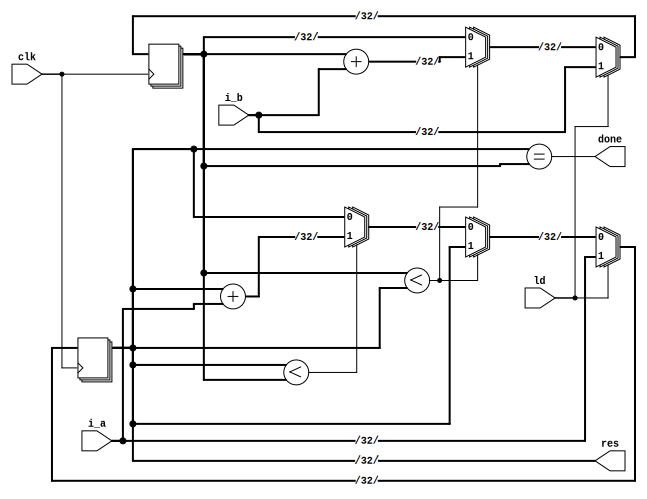

In [102]:
%%print_verilog -n mmc.v

module mmc_b( //comportamental
  input clk, ld,
  input [31:0] i_a, i_b,
  output [31:0] res, //resultado
  output done); //pronto

  reg [31:0] a, b;

  always @(posedge clk)
    if (ld) begin // carrega
      a <= i_a;   // valores
      b <= i_b;   // iniciais
    end
    else // acumula o menor
      if (b < a)
        b <= b + i_b;
      else
        if (a < b)
          a <= a + i_a;
  // ao final, os dois serao iguais
  assign res = a;
  assign done = (a == b);
endmodule

Note que o circuito obtido possui apenas os dois registradores declarados, multiplexadores, comparadores e somadores. Em seu teste abaixo, usando os mesmos valores já demonstrados, vamos uma um novo recurso, a clausulá `wait`. Como o número de ciclos depende dos valores computados, fazemos a carga inicial dos valores e aguardamos o sinal `done` que indica o término da computação (linha 21).

VCD info: dumpfile dump.vcd opened for output.



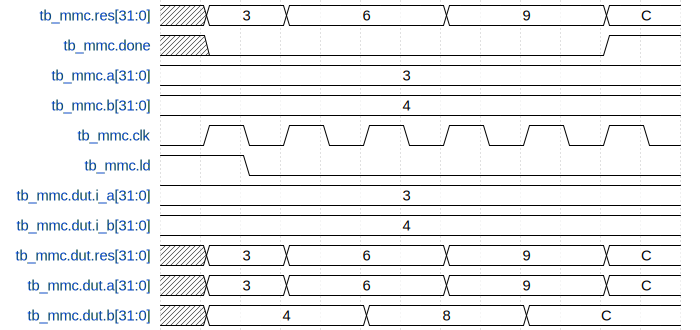

In [103]:
%%wavedrom
`include "mmc.v"

module tb_mmc;
  reg clk, ld;
  reg [31:0] a, b;
  wire [31:0] res;
  wire done;

  mmc_b dut(clk, ld, a, b, res, done);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(0);
    clk = 0; ld = 1;
    a = 3; b = 4; // experimente com outros valores
    #10 ld = 0;
    wait (done==1);
    #5 $finish;
  end
endmodule


O próximo circuito, apresentado a seguir, calcula o **máximo divisor comum** entre dois números. O algoritmo usado é bastante parecido com o anterior, mas desta vez vamos subtrair o menor do maior até que um deles seja zero, o restante será o resultado. Veja a tabela a seguir, destacando o menor a cada passo:

a|b
-:|-:
**18**|60
**18**|42
**18**|24
18|**6**
12|**6**
**6**|6
0|6

Desta vez, vamos usar Verilog estrutural e funcional para construir o circuito a partir de registradores e de atribuições contínuas. Note que sua descrição fica bastante diferente da anterior, apesar da semelhança entre os circuitos gerados.

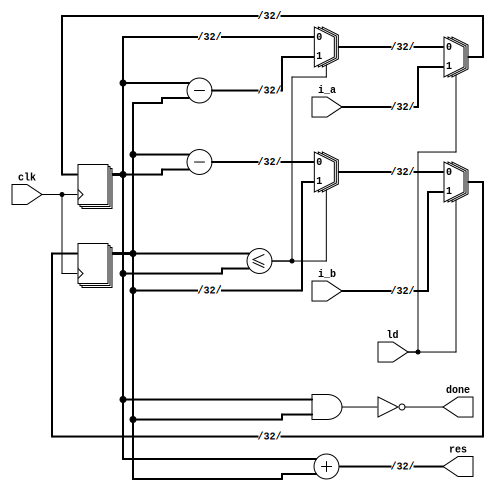

In [104]:
%%print_verilog -n mdc.v
module mdc_s( //estrutural
  input clk, ld,
  input [31:0] i_a, i_b,
  output [31:0] res, //resultado
  output done); //pronto

  wire [31:0] a, b, a_i_b, b_i_a;
  wire en;
  // subtrai o menor do maior
  assign a_i_b = a - b;
  assign b_i_a = b - a;
  assign en = b <= a;

  reg32 ra(ld, clk, en, i_a, a_i_b, a);
  reg32 rb(ld, clk, !en, i_b, b_i_a, b);
  // ao final, um deles sera zero
  assign res  = a + b;
  assign done = !(a && b);
endmodule

module reg32(
  input ld, clk, en,
  input [31:0] data_l, data_i,
  output reg [31:0] data_o);
  always @(posedge clk)
    if (ld) data_o  = data_l;
    else if (en) data_o = data_i;
endmodule

Usamos praticamente o mesmo teste para este novo problema, mas note que é possível incluir no `$monitor` valores que estão no módulo instanciado (linha 18):



VCD info: dumpfile dump.vcd opened for output.
         x         x
        18        60
        18        42
        18        24
        18         6
        12         6
         6         6
         0         6



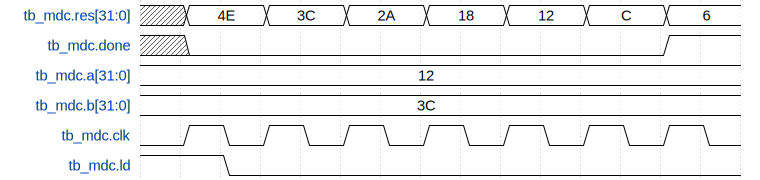

In [105]:
%%wavedrom
`include "mdc.v"

module tb_mdc;
  reg clk, ld;
  reg [31:0] a, b;
  wire [31:0] res;
  wire done;

  mdc_s dut(clk, ld, a, b, res, done);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    $monitor(dut.a, dut.b);
    clk = 0; ld = 1;
    a = 18; b = 60;
    #10 ld = 0;
    wait (done==1);
    #5 $finish;
  end
endmodule

<h3>Exercício</h3>

Tente implementar os dois algoritmos da outra forma, ou seja, o MMC na forma estrutural e o MDC na forma comportamental. Teste para ver se eles são equivalentes às implementações fornecidas.

# Máquinas de estados finitos (FSM)

Vimos até agora alguns circutos sequenciais simples, que possuem alguns poucos registradores e sinais de controle. Quando é necessário sincronizar muitas operações e sinais de controle, precisamos de uma metodologia que permita desenvolver o circuito de maneira mais organizada e sistemática. As máquinas de estados finitos permitem implementar adequadamente circuitos mais complexos. A seguir veremos como elas funcionam e como desenvolver circuitos baseados nelas. Na figura a seguir está uma representação de como as FSM funcionam. A partir do estado atual e das entradas, um novo estado é calculado. A saída depende apenas do estado atual no modelo de Moore mas também das entradas no modelo de Mealy (linha azul). Em ambos modelos, temos  um único estado ativo por vez.



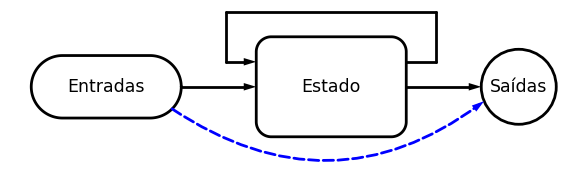

In [106]:
# @title
# import matplotlib.pyplot as plt
# plt.xkcd()
# plt.rcdefaults()
d = schemdraw.Drawing()
d.add(inicio := flow.Terminal().label('Entradas').drop('E'))
d += elm.Line(arrow='->').right(d.unit/2)
d.add(estado := flow.RoundBox(label='Estado'))
d += elm.Line(arrow='->').right(d.unit/2)
d.add(fim := flow.Connect().label('Saídas'))
#feedback
#d.add(flow.Arrow().at(estado.E).right(d.unit/4))
#d.add(flow.Line(arrow='->').up(d.unit/2))
#d.add(flow.Wire('c', k=-4.5, arrow='->').to(estado.W))
d += elm.Line(arrow='-').at(estado.ENE).right(d.unit/5)
d += elm.Line(arrow='-').up(d.unit/3)
d += elm.Line(arrow='-').left(d.unit*1.4)
d += elm.Line(arrow='-').down(d.unit/3)
d += elm.Line(arrow='->').right(d.unit/5)
#forward
d += elm.Arc2(arrow='->', color='blue', k=-0.35, ls='--').at(inicio.SE).to(fim.WSW)
d.draw()

## Modelo de Moore

Vamos começar com o modelo de Moore, no qual as saídas dependem apenas do estado atual. No exemplo a seguir, maquina de estados finitos controla uma luz (L) a partir de um botão (B), como em um controle remoto em que o mesmo botão serve tanto para ligar quanto para desligar um aparelho.

No modelo de Moore, as saída são anotadas nos estados, então temos $S_0$ com a luz apagada (L=0) e $S_1$ com a luz acesa (L=1). Já as entradas, estas são anotadas nas arestas, que representam as mudanças de estado. Neste exemplo, quando o botão está pressionado, ocorre a mudança no estado, caso contário, o estado permanece o mesmo. A aresta externa apontando para $S_0$ indica que ele é o estado inicial quando o circuito é inicializado. A FSM obtida a partir do enunciado é a seguinte:



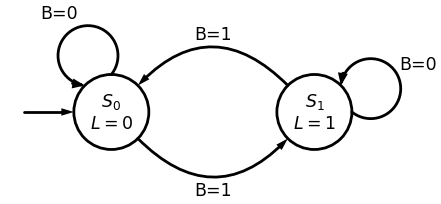

In [107]:
# @title
with schemdraw.Drawing() as d:
    d += elm.Arrow().length(1)
    d += (s1 := flow.State().anchor('W').label('$S_0$\n$L=0$'))
    d += elm.Arc2(arrow='<-').at(s1.NE).label('B=1')
    d += (s2 := flow.State().anchor('NW').label('$S_1$\n$L=1$'))
    d += elm.Arc2(arrow='<-').at(s2.SW).to(s1.SE).label('B=1')
    d += elm.ArcLoop(arrow='<-').at(s2.NE).to(s2.E).label('B=0')
    d += elm.ArcLoop(arrow='<-').at(s1.NW).to(s1.N).label('B=0')

Já podemos perceber que um flip-flop do tipo T resolveria nosso problema, mas vamos seguir uma metodologia que poderá ser usada posteriormente em problemas mais complexos.

O primeiro passo desta metodologia é  construir uma tabela com as regras de transição e saídas a partir da máquina de estados.

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Próximo Estado</th>
    <th>Saída</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>L</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>A</td>
    <td>A</td>
    <td>B</td>
    <td>0</td>
  </tr>
  <tr>
    <td>B</td>
    <td>B</td>
    <td>A</td>
    <td>1</td>
  </tr>
</tbody>
</table>

Depois, vamos definir quantos flip-flops precisamos para representar os estados e atribuir valores únicos a eles em cada estado. No nosso exemplo, um único flip-flop pode mapear os dois estados possíveis.

Vamos chamar sua saída de $E_0$ (maiúsculo) e de $e_0$ (minúsculo) a entrada deste flip-flop, ou seja, qual será o próximo estado. Nossa tabela de atribuição de estados fica assim:

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Próximo Estado</th>
    <th>Saída</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>L</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>0</td>
    <td>0</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>0</td>
    <td>1</td>
  </tr>
</tbody>
</table>

Assim temos $L(E_0)=E_0$, ou seja, a saída L é igual ao próprio estado $E_0$. Já a função de transição, que é única, pois só temos um flip-flop fica $e_0(B, E_0)=B.\overline{ E_0}+\overline{ B}.E_0 = B \oplus E_0$. Conforme explicamos anteriormente, neste modelo a saída só depende do estado atual e o próximo estado depende do estado atual e da entrada. Aqui temos uma implementação estrutural a partir de um único flip-flop D capaz de armazenar os dois estados da máquina (linha 7). A função de saída só depende deste estado (linha 8) e finalmente a função de transição depende do estado atual e da entrada (linha 9).


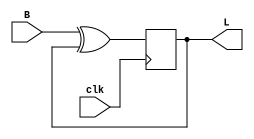

In [108]:
%%print_verilog
`include "FFD.v"

module fsm(
  input clk, B,
  output L);
  FFD E0(clk, e, E); //estado atual
  assign L = E;      //função de saída
  xor (e, B, E);     //função de transição
endmodule

Esta implementação é válida, porem o flip-flop D usado não possui reset, então não é possível saber o estado inicial do circuito e consequentemente simulá-lo. A seguir está uma implementação comportamental do mesmo circuito, incluindo um reset assíncrono. Também fizemos a saída `L` ser o próprio registrador de estado.

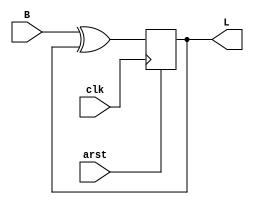

In [109]:
%%print_verilog -n BL.v
module BL(
  input clk, arst, B,
  output reg L);

  always@(posedge clk or posedge arst)
    if (arst)
      L = 0;
    else
      L = B ^ L;
endmodule

Na simulação a seguir, podemos observar que:

*   O reset é assíncrono e tem efeito imediatamente;
*   O circuito é capaz de acender e depois de apagar a luz (L) a partir do pressionamento do botão (B) durante a subida do relógio;
*   Se o botão ficar acionado a lâmpada irá piscar a cada subida do clock.

Em termos práticos, este funcionamento é inadequado, já que os circuitos costumam operar em frequências na casa dos MHz e seria praticamente impossível pressionar o botão por uma única subida do relógio como vemos na parte central da simulação.

VCD info: dumpfile dump.vcd opened for output.



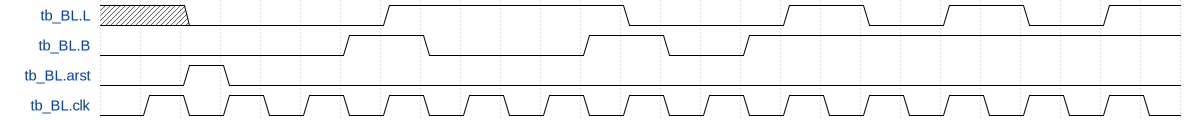

In [110]:
%%wavedrom
`include "BL.v"

module tb_BL;
  reg clk, arst, B;
  wire L;

  BL dut(clk, arst, B, L);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    clk = 0; arst = 0; B = 0;
    #10 arst = 1;
    #5 arst = 0;
    #15 B = 1; #10 B = 0;
    #20 B = 1; #10 B = 0;
    #10 B = 1;
    #50 $finish;
  end
endmodule

Para que o circuito funcione adequadamente, mesmo com um relógio em alta frequência, vamos reestruturar nossa FSM conforme o diagrama a seguir. Aqui a linha dupla indica que $S_0$ é o estado inicial, embora esta notação seja usada para indicar também estados finais. Quando o botão é pressionado, passamos ao estado $S_1$ no qual a luz é acesa e ficamos neste estado enquanto o botão permanecer pressionado. Passamos de $S_1$ para $S_2$ quando o botão é solto, mas a luz permanece acesa. Um novo pressionamento do botão nos leva para o estado $S_3$ quando a luz é apagada e voltamos para $S_0$ quando o botão é solto. Desta forma o pressionamento do botão não causa várias mudanças de estado, independentemente de quantos ciclos de relógio ele permanecer pressionado.

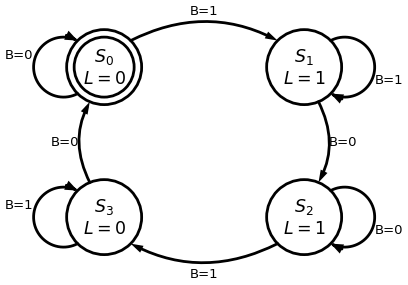

In [111]:
# @title
with schemdraw.Drawing() as d:
    d += (s0 := flow.StateEnd().at((0,3)).label('$S_0$\n$L=0$'))
    d += (s1 := flow.State().at(   (4,3)).label('$S_1$\n$L=1$'))
    d += (s2 := flow.State().at(   (4,0)).label('$S_2$\n$L=1$'))
    d += (s3 := flow.State().at(   (0,0)).label('$S_3$\n$L=0$'))

    d += elm.ArcLoop(arrow='->').at(s0.SW).to(s0.NW).label('B=0', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s1.NE).to(s1.SE).label('B=1', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s2.NE).to(s2.SE).label('B=0', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s3.SW).to(s3.NW).label('B=1', fontsize=11)

    d += elm.Arc2(k=.25, arrow='->').at(s0.NE).to(s1.NW).label('B=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s1.SSE).to(s2.NNE).label('B=0', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s2.SW).to(s3.SE).label('B=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s3.NNW).to(s0.SSW).label('B=0', fontsize=11)

Vamos aplicar novamente a mesma metodologia para desenvolver o circuito. Inicialmente construimos a **tabela de transições de estados** a partir da FSM:

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Próximo Estado</th>
    <th>Saída</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>L</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>S0</td>
    <td>S0</td>
    <td>S1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>S1</td>
    <td>S2</td>
    <td>S1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>S2</td>
    <td>S2</td>
    <td>S3</td>
    <td>1</td>
  </tr>
  <tr>
    <td>S3</td>
    <td>S0</td>
    <td>S3</td>
    <td>0</td>
  </tr>
</tbody>
</table>

Agora construimos a **tabela de atribuição de estados** e, novamente, faremos uma atribuição sequencial dos valores.

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Próximo Estado</th>
    <th>Saída</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>L</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>00</td>
    <td>00</td>
    <td>01</td>
    <td>0</td>
  </tr>
  <tr>
    <td>01</td>
    <td>10</td>
    <td>01</td>
    <td>1</td>
  </tr>
  <tr>
    <td>10</td>
    <td>10</td>
    <td>11</td>
    <td>1</td>
  </tr>
  <tr>
    <td>11</td>
    <td>00</td>
    <td>11</td>
    <td>0</td>
  </tr>
</tbody>
</table>

Para guardar os quatro estados listados na tabela precisamos de exatamente dois flip-flop, que vamos chamar de $E_1$ (MSB) e $E_0$ (LSB). Em FSMs mais complexas podemos fazer um Mapa de Karnaugh para cada expressão, usando *don't care* para as saídas que não representam nenhum estado. Aqui conseguimos inferi-las facilmente, apenas observando a tabela:

* $e_1(B, E_1, E_0)  = \overline{B}.(E_1 \oplus E_0) + B.E_1$
* $e_0(B, E_1, E_0) = B$
* $L(E_1, E_0) = E_1 \oplus E_0$

Seguindo as expressões para implementar o Verilog estrutural temos o seguinte:

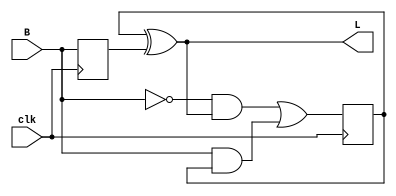

In [112]:
%%print_verilog -n fsm4.v
`include "FFD.v"

module fsm4(
  input clk, B,
  output L);
  wire [1:0] e, E;
  FFD E1(clk, e[1], E[1]); //estado atual
  FFD E0(clk, e[0], E[0]); //estado atual
  xor (L, E[1], E[0]);     //função de saída
  assign e[0] = B;         //funções de transição
  assign e[1] = ~B & L | B & E[1];
endmodule

Novamente, vamos fazer uma implementação com Verilog comportamental e incluir um reset assíncrono para poder simular.

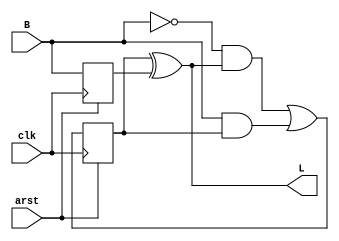

In [113]:
%%print_verilog -n BL2.v
module BL2(
  input clk, arst, B,
  output L);

  reg E1, E0;

  always@(posedge clk or posedge arst)
    if (arst)
    begin
      E1 <= 1'b0;
      E0 <= 1'b0;
    end
    else
    begin
      E1 <= ~B & L | B & E1;
      E0 <= B;
    end
  assign L = E1 ^ E0;
endmodule

Note que o circuito obtido é exatamente igual ao anterior, exceto pelo reset. Na simulação a seguir podemos observar que o pressionamento do botão por mais de um ciclo só causa uma transição de estado, o que evita que a luz pisque quando ele estiver acionado. Incluimos a entrada, o estado interno e a saída no monitor do console para facilitar a compreensão.

B Sn L
VCD info: dumpfile dump.vcd opened for output.
0 00 0
1 00 0
1 01 1
0 01 1
0 10 1
1 10 1
1 11 0
0 11 0
0 00 0
1 00 0
1 01 1
0 01 1
0 10 1



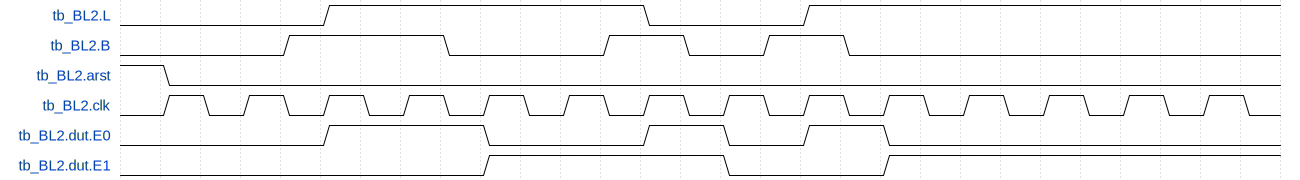

In [114]:
%%wavedrom
`include "BL2.v"

module tb_BL2;
  reg clk, arst, B;
  wire L;
  wire [1:0] S;

  BL2 dut(clk, arst, B, L);

  always
    #5 clk = ~clk;

  initial
  begin
    $display("B Sn L");
    $monitor("%b %b%b %b", B, dut.E1, dut.E0, L);
    $dumpvars(0);
    clk = 0; arst = 1; B = 0;
    #5 arst = 0;
    #15 B = 1; #20 B = 0;
    #20 B = 1; #10 B = 0;
    #10 B = 1; #10 B = 0;
    #50 $finish;
  end
endmodule

A atribuição sequencial que fizemos aos estados não é obrigatória e a escolha deles tem influência direta na complexidade do circuito. Para exemplificar, vamos fazer uma atribuição alternativa aos bits dos estados, trocando apenas $S_2$ para `11` e $S_3$ para `10`. Nossa tabela de atribuição de estados ficaria assim:

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Próximo Estado</th>
    <th>Saída</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>L</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>00</td>
    <td>00</td>
    <td>01</td>
    <td>0</td>
  </tr>
  <tr>
    <td>01</td>
    <td>11</td>
    <td>01</td>
    <td>1</td>
  </tr>
  <tr>
    <td>11</td>
    <td>11</td>
    <td>10</td>
    <td>1</td>
  </tr>
  <tr>
    <td>10</td>
    <td>00</td>
    <td>10</td>
    <td>0</td>
  </tr>
</tbody>
</table>

As novas expressões seriam:

* $e_1(B, E_1, E_0) = \overline{B}.E_0 + B.E_1$
* $e_0(B, E_1, E_0)  = \overline{B}.E_0 + B.\overline{E_1}$
* $L(E_1, E_0) = E_0$

Note que o circuito resultante é diferente do anterior, como é de se esperar, mas a simulação funciona exatamente igual. Em alguns casos, certas atribuições de estado podem resultar em circuitos muito mais simples do que outro. Não e possivel encontrar a melhor solução (mais otimizada) sem testar todas as possibilidades, o que torna este um problema NP-completo. As ferramentas de síntese usam heurísticas para resolve-lo e há parametros específicos para favorecer soluções com determinadas características, por exemplo, menor área, maior frequência, etc. Você pode usar o mesmo *test bench* do código anterior, pois estamos salvando a implementação com o mesmo nome.

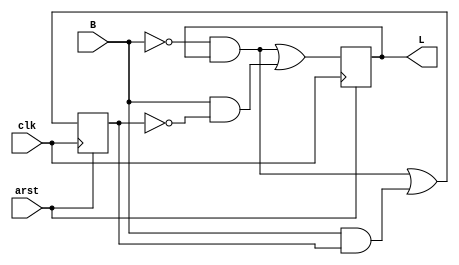

In [115]:
%%print_verilog -n BL2.v
module BL2(
  input clk, arst, B,
  output L);

  reg E1, E0;

  always@(posedge clk or posedge arst)
    if (arst)
    begin
      E1 <= 1'b0;
      E0 <= 1'b0;
    end
    else
    begin
      E1 <= ~B & E0 | B & E1;
      E0 <= ~B & E0 | B & ~E1;
    end
  assign L = E0;
endmodule

A metodologia usada aqui parte da especificação inicial da FSM e chega até as expressões de cada bit usado para guardar os estados. Além de termos que escolher uma codificação para os estados que não sabemos ser a mais adequada, temos que espeficiar manualmente cada expressão do circuito. Alternativamente, podemos construir o Verilog comportamental a partir da FSM, o que elimina a necessidade de descrever as expressões. Além de ser um processo mais simples, algumas ferramentas de síntese são capazes de alterar a codificação da FSM automaticamente para otimizar o circuito. A seguir está uma implementação da mesma FSM usando Verilog comportamental para a FSM (e não para os registradores como fizemos antes):

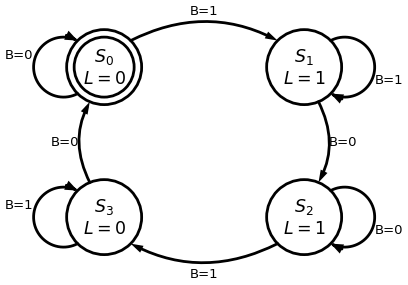

In [116]:
# @title
with schemdraw.Drawing() as d:
    d += (s0 := flow.StateEnd().at((0,3)).label('$S_0$\n$L=0$'))
    d += (s1 := flow.State().at(   (4,3)).label('$S_1$\n$L=1$'))
    d += (s2 := flow.State().at(   (4,0)).label('$S_2$\n$L=1$'))
    d += (s3 := flow.State().at(   (0,0)).label('$S_3$\n$L=0$'))

    d += elm.ArcLoop(arrow='->').at(s0.SW).to(s0.NW).label('B=0', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s1.NE).to(s1.SE).label('B=1', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s2.NE).to(s2.SE).label('B=0', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s3.SW).to(s3.NW).label('B=1', fontsize=11)

    d += elm.Arc2(k=.25, arrow='->').at(s0.NE).to(s1.NW).label('B=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s1.SSE).to(s2.NNE).label('B=0', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s2.SW).to(s3.SE).label('B=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s3.NNW).to(s0.SSW).label('B=0', fontsize=11)

Repetimos a figura da FSM para facilitar a escrita do código. Apesar de ser mais extenso, não precisamos nos preocupar com a codificação dos estados e as expressões decorrentes disso. Podemos definir como será a transição dos estados apenas observando a FSM e depois definir como será a saída. Alguns aspectos importantes do código a seguir:

* Cuidar para que os parâmetros definidos para cada estado não se repitam (linhas 7-10);
* Certificar-se de que as variáveis de estado (linha 13) têm a mesma largura dos parâmetros (lembre-se de que atribuições para espaços menores são permitidas);
* Listar todas as entradas e o estado atual na lista sensitiva do bloco que define o próximo estado (linha 16);
* Atribuir o próximo estado para `e` a partir do estado atual e das entradas;
* Incluir a opção `default` no `case` para as codifições que não serão usadas;
* Atribuir o estado inicial ou o próximo estado no bloco sequencial que funciona no reset ou na subida do relógio (linhas 30-32);
* Definir as saídas a partir dos estados desenhados (linha 35).

Note que declaramos `e` do tipo `reg` para poder atribuí-lo dentro de um bloco `always`, mas como ele não depende do relógio, não gera flip-flops, diferentemente de `E`.

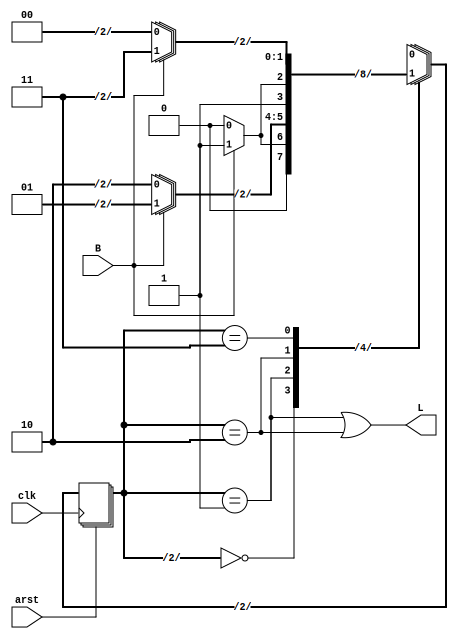

In [164]:
%%print_verilog -n BL4.v
module BL4(
  input clk, arst, B,
  output L);

  //Codificação dos estados
  parameter [1:0] S0 = 2'b00,
                  S1 = 2'b01,
                  S2 = 2'b10,
                  S3 = 2'b11;

  //Estado atual e próximo estado
  reg [1:0] E, e;

  // Bloco combinacional (calcula próximo estado)
  always @(B, E)
    case (E)
      S0: if (B) e = S1;
       else      e = S0;
      S1: if (B) e = S1;
       else      e = S2;
      S2: if (B) e = S3;
       else      e = S2;
      S3: if (B) e = S3;
       else      e = S0;
      default:   e = 'bx;
    endcase

  // Bloco sequencial (ativa próximo estado)
  always @(posedge arst or posedge clk)
    if (arst) E <= S0;
    else      E <= e;

  // Define a saída a partir dos estados
  assign L = (E == S1 | E == S2);
endmodule

O teste a seguir possui exatamente os mesmos estímulos do anterior, mas incluimos o estado atual e o próximo estado no monitor na console e na simulação. Note que o próximo estado `e` muda imediatamente com a mudança da entrada `B`, mas a saída `L` só muda efetivamente com a mudança para o próximo estado `E`.

B  E L
VCD info: dumpfile dump.vcd opened for output.
0 00 0
1 00 0
1 01 1
0 01 1
0 10 1
1 10 1
1 11 0
0 11 0
0 00 0
1 00 0
1 01 1
0 01 1
0 10 1



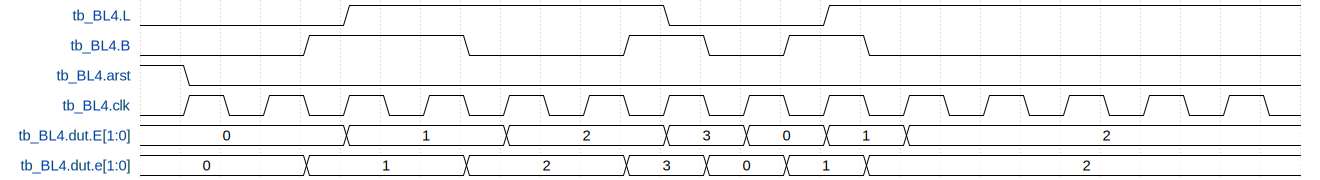

In [165]:
%%wavedrom
`include "BL4.v"

module tb_BL4;
  reg clk, arst, B;
  wire L;
  wire [1:0] S;

  BL4 dut(clk, arst, B, L);

  always
    #5 clk = ~clk;

  initial
  begin
    $display("B  E L");
    $monitor("%b %b %b", B, dut.E, L);
    $dumpvars(0);
    clk = 0; arst = 1; B = 0;
    #5 arst = 0;
    #15 B = 1; #20 B = 0;
    #20 B = 1; #10 B = 0;
    #10 B = 1; #10 B = 0;
    #50 $finish;
  end
endmodule

A seguir está uma implementação mais compacta, em que declaramos apenas o estado atual e fazemos a atribuição direta do próximo estado nesta mesma variável. Note que o circuito resultante é exatamente o mesmo. Você pode testá-lo usando o *test bench* anterior.

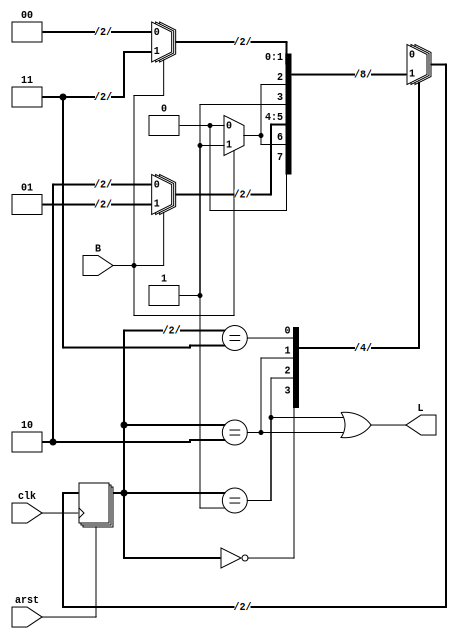

In [160]:
%%print_verilog -n BL4.v
module BL4(
  input clk, arst, B,
  output L);

  parameter [1:0] S0 = 2'b00, S1 = 2'b01, S2 = 2'b10, S3 = 2'b11;
  reg [1:0] E;

  always @(posedge arst or posedge clk)
    if (arst) E <= S0;
    else
      case (E)
        S0: if (B) E = S1;
         else      E = S0;
        S1: if (B) E = S1;
         else      E = S2;
        S2: if (B) E = S3;
         else      E = S2;
        S3: if (B) E = S3;
         else      E = S0;
        default:   E = 'bx;
      endcase

  assign L = (E == S1 | E == S2);
endmodule

Antes de seguir para o próximo modelo, vamos implementar ainda mais uma versão do mesmo problema. No exemplo abaixo, estamos usando uma codificação chamada *one-hot*, na qual temos um bit para cada estado e apenas um deles fica acionado em cada estado. Aqui estamos atribuindo cada bit de estado individualmente, como no primeiro método que usamos (com as tabelas), mas note que as expressões ficam muito mais simples usando esta codificação. Este circuito também pode ser testado com o *test bench* anterior.

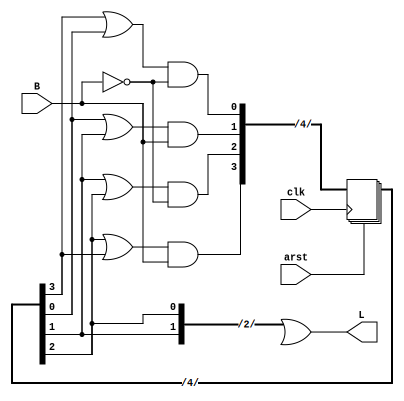

In [166]:
%%print_verilog -n BL4.v
module BL4(
  input clk, arst, B,
  output L);

  reg [3:0] E;

  always @(posedge arst or posedge clk)
    if (arst) E <= 4'b0001; //S0
    else
    begin
      E[0] <= (E[3] | E[0]) & ~B; //S0 = 0001
      E[1] <= (E[0] | E[1]) &  B; //S1 = 0010
      E[2] <= (E[1] | E[2]) & ~B; //S2 = 0100
      E[3] <= (E[2] | E[3]) &  B; //S3 = 1000
    end

  assign L = |E[2:1];
endmodule

## Modelo de Mealy

No modelo de Mealy, as saídas de uma FSM dependem do estado atual e das entradas, então anotamos as saídas nas transições e não nos estados. Considerando nosso problema anterior, já corrigido a questão da repetição da entrada do botão, teriamos a seguinte FSM:

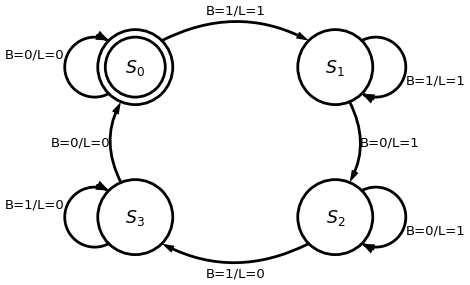

In [120]:
# @title
with schemdraw.Drawing() as d:
    d += (s0 := flow.StateEnd().at((0,3)).label('$S_0$'))
    d += (s1 := flow.State().at(   (4,3)).label('$S_1$'))
    d += (s2 := flow.State().at(   (4,0)).label('$S_2$'))
    d += (s3 := flow.State().at(   (0,0)).label('$S_3$'))

    d += elm.ArcLoop(arrow='->').at(s0.SW).to(s0.NW).label('B=0/L=0', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s1.NE).to(s1.SE).label('B=1/L=1', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s2.NE).to(s2.SE).label('B=0/L=1', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s3.SW).to(s3.NW).label('B=1/L=0', fontsize=11)

    d += elm.Arc2(k=.25, arrow='->').at( s0.NE).to(s1.NW ).label('B=1/L=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s1.SSE).to(s2.NNE).label('B=0/L=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at( s2.SW).to(s3.SE ).label('B=1/L=0', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s3.NNW).to(s0.SSW).label('B=0/L=0', fontsize=11)

Nossa tabela de transições de estados agora tem uma coluna a mais, pois a saída também depende da entrada.

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Próximo Estado</th>
    <th colspan="2">Saída L</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>B=0</th>
    <th>B=1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>S0</td>
    <td>S0</td>
    <td>S1</td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td>S1</td>
    <td>S2</td>
    <td>S1</td>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>S2</td>
    <td>S2</td>
    <td>S3</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>S3</td>
    <td>S0</td>
    <td>S3</td>
    <td>0</td>
    <td>0</td>
  </tr>
</tbody>
</table>

O mesmo acontece na tabela de atribuição de estados:

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Próximo Estado</th>
    <th colspan="2">Saída L</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>B=0</th>
    <th>B=1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>00</td>
    <td>00</td>
    <td>01</td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td>01</td>
    <td>10</td>
    <td>01</td>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>10</td>
    <td>10</td>
    <td>11</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>11</td>
    <td>00</td>
    <td>11</td>
    <td>0</td>
    <td>0</td>
  </tr>
</tbody>
</table>

Nossa função de saída $L$ agora também tem $B$ como variável de entrada:

* $e_1(B, E_1, E_0)  = \overline{B}.(E_1 \oplus E_0) + B.E_1$
* $e_0(B, E_1, E_0) = B$
* $L(B, E_1, E_0) = \overline{B}.(E_1 \oplus E_0) + B.\overline{E_1}$

Se observarmos o circuito gerado a seguir, podemos notar que há um caminho que começa na entrada $B$ e vai até a saída $L$, sem passar pelos elementos de estado:

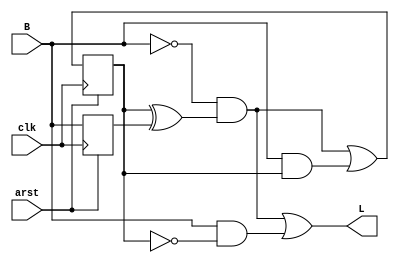

In [121]:
%%print_verilog -n BL2Mealy.v
module BL2Mealy(
  input clk, arst, B,
  output L);

  reg E1, E0;

  always@(posedge clk or posedge arst)
    if (arst)
    begin
      E1 <= 1'b0;
      E0 <= 1'b0;
    end
    else
    begin
      E1 <= ~B & (E1 ^ E0) | B & E1;
      E0 <= B;
    end
  assign L = ~B & (E1 ^ E0) | B & ~E1;
endmodule

O efeito disso pode ser notado na simulação. A transição dos estados ocorre exatamente como no modelo de Moore, mas a saída é modificada antes, já no acionamento do botão. Em certos casos, esta possibilidade permite resolver o mesmo problema com um número menor de estados, como veremos a seguir.

B Sn L
VCD info: dumpfile dump.vcd opened for output.
0 00 0
1 00 1
1 01 1
0 01 1
0 10 1
1 10 0
1 11 0
0 11 0
0 00 0
1 00 1
1 01 1
0 01 1
0 10 1



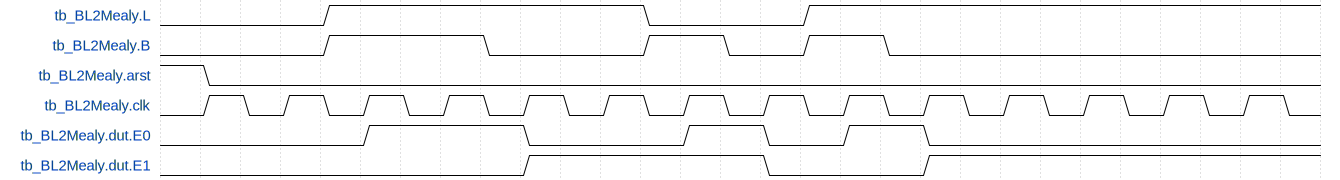

In [122]:
%%wavedrom
`include "BL2Mealy.v"

module tb_BL2Mealy;
  reg clk, arst, B;
  wire L;
  wire [1:0] S;

  BL2Mealy dut(clk, arst, B, L);

  always
    #5 clk = ~clk;

  initial
  begin
    $display("B Sn L");
    $monitor("%b %b%b %b", B, dut.E1, dut.E0, L);
    $dumpvars(0);
    clk = 0; arst = 1; B = 0;
    #5 arst = 0;
    #15 B = 1; #20 B = 0;
    #20 B = 1; #10 B = 0;
    #10 B = 1; #10 B = 0;
    #50 $finish;
  end
endmodule

# Memórias

A evolução natural dos registradores que vimos na segunda parte deste livro são as memórias. Elas consistem em um conjunto de registradores acessíveis por um determinado endereço, usado tanto para ler quanto para escrever. Na descrição a seguir, espeficicamos uma memória de 256 palavras, cada uma delas com 4 bytes (32 bits).


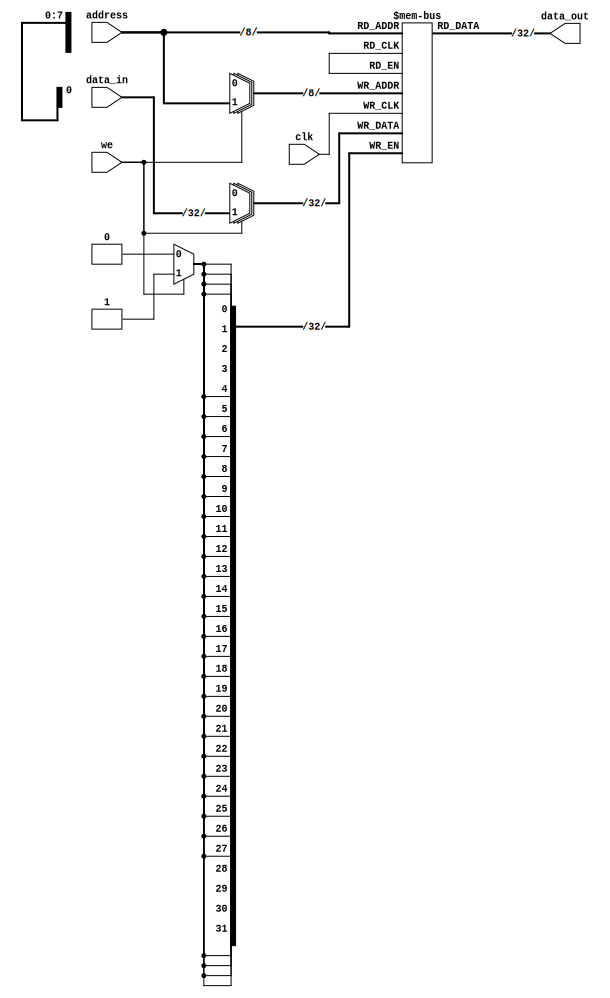

In [171]:
%%print_verilog -n mem.v
module mem (
  input clk, we,
  input [7:0] address,
  input [31:0] data_in,
  output [31:0] data_out);

  reg [31:0] RAM [255:0];

  assign data_out = RAM[address];

  always @(posedge clk)
    if (we) RAM[address] <= data_in;
endmodule

In [ ]:
%%wavedrom
`include "mem.v"

module tb_mem;
  reg clk, we;
  reg [7:0] address;
  reg [31:0] data_in;
  wire [31:0] data_out;

  mem dut(clk, we, address, data_in, data_out);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    clk = 1; we = 0; address = 0; data_in = 0;
    #5 we = 1;
    #10 address = 1; data_in = 2;
    #10 address = 2; data_in = 4;
    #5 we = 0; address = 0;
    #10 address = 1;
    #10 address = 2;
    #10 $finish;
  end
endmodule

# Barramentos

Até agora, nossos circuitos possuiam fios dedicados para conectar a saída de um componente até uma ou mais entradas de outros componentes. Em alguns casos, ter ligações dedicadas pode ser muito custoso e precisamos usar barramentos compartilhados. Para isso, precisamos usar *buffers* que permitem deixar saídas com **alta impedância** como se estivessem desconectadas. Em Verilog, as primitivas básicas para construir estes barramentos, chamados *tristate*, são as seguintes:

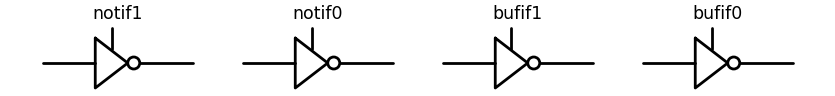

In [124]:
%load_ext autoreload
%autoreload 2

import schemdraw
from schemdraw import logic

with schemdraw.Drawing() as d:
    d += logic.Tristate().label('notif1')
    d += elm.Gap().length(1)
    d += logic.Tristate(controlnot = True).label('notif0')
    d += elm.Gap().length(1)
    d += logic.Tristate(outputnot = False).label('bufif1')
    d += elm.Gap().length(1)
    d += logic.Tristate(outputnot = False, controlnot = True).label('bufif0')


Ao invés de instanciar estas primitivas básicas, podemos simplesmente atribuir um valor `z` a um fio ou barramento para colocá-lo no estado de alta impedância, por exemplo:
```verilog
parameter N = 8;
wire [N-1:0] notif1bus, notif0bus, bufif1bus, bufif0bus, in;
assign notif1bus =  control ? ~in : 'bz;
assign notif0bus = ~control ? ~in : 'bz;
assign bufif1bus =  control ?  in : 'bz;
assign bufif0bus = ~control ?  in : 'bz;
```

In [170]:
%%verilog
module t_fibo;
  wire [31:0] bus;
  reg clk, rst, ec;

  fibo #(1) a(clk, rst,  ec, bus);
  fibo #(1) b(clk, rst, ~ec, bus);

  initial begin
    $dumpfile("dump.vcd");
    $display("a  bus    b");
    $monitor("%d %d %d", a.value, bus, b.value);
    rst = 1; ec = 0;
    #10 rst = 0;
    #120 $finish;
  end

  always begin
    clk = 0; #5; clk = 1; #5;
  end

  always @(negedge clk)
    ec = ~ec;
endmodule

module fibo #(parameter resetval = 0)(
  input clk, rst, enable,
  inout tri [31:0] bus);
  integer value;
  always @(posedge clk)
    if (rst)
      value = resetval;
    else
      if (enable)
        value = value + bus;
  assign bus = enable ? 'bz : value;
endmodule

a  bus    b
          x          x           x
          1          1           1
          1          1           1
          2          1           1
          2          2           1
          2          2           3
          2          3           3
          5          3           3
          5          5           3
          5          5           8
          5          8           8
         13          8           8
         13         13           8
         13         13          21
         13         21          21
         34         21          21
         34         34          21
         34         34          55
         34         55          55
         89         55          55
         89         89          55
         89         89         144
         89        144         144
        233        144         144
        233        233         144
        233        233         377
        233        377         377

